In [1]:
# This notebook requires several Python packages to be installed, and may depend on the version numbers of those packages.
# So, to reproducibly run this notebook, use the conda package management system to create a Python environment 
#     from the included .yml file: conda env create -f ramr_stereo_env.yml
# Then, use the resulting ramr_stereo_env to run this notebook.

# This notebook also requires the file, Supplementary Data 1.DMS results.csv, which is too large to put on GitHub. 
#     So, to run this notebook, manually move that SI data file to the Data sub-directory of the repository.

In [2]:
import glob #filenames and pathnames utility
import os   #operating sytem utility
import sys
import datetime

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps

import copy
import cmocean
import palettable

import numpy as np
import pandas as pd

import scipy
import scipy.stats as stats
from scipy.interpolate import interpn

import pickle

import seaborn as sns


%load_ext autoreload
%autoreload 2

%matplotlib inline

%autosave 0

Autosave disabled


In [3]:
# set global default plot styles:
sns.set()

sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True, })
#sns.set_style({"axes.labelsize": 20, "xtick.labelsize" : 16, "ytick.labelsize" : 16})

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.edgecolor'] = 'k'

box_size = 8

# Define functions used for plotting data

In [4]:
def project_2d(vectors):
    ret = vectors.transpose()
    ret = ret[:2]
    ret = ret.transpose()
    return ret

In [5]:
def rot_x(theta):
    theta = theta*np.pi/180
    rot = [[1, 0, 0],
           [0, np.cos(theta), -np.sin(theta)],
           [0, np.sin(theta), np.cos(theta)]]
    rot = np.array(rot)
    return rot

def rot_y(theta):
    theta = theta*np.pi/180
    rot = [[np.cos(theta), 0, -np.sin(theta)],
           [0, 1, 0],
           [np.sin(theta), 0, np.cos(theta)]]
    rot = np.array(rot)
    return rot

def dist_2d(v1, v2, x_scale=1, y_scale=1):
    diff = v1 - v2
    return np.sqrt((diff[0]/x_scale)**2 + (diff[1]/y_scale)**2)

In [6]:
theta_x = np.arccos(np.sqrt(2/3))*180/np.pi
print(theta_x)

default_scale = 1

def specificity_coords(log_ec50_1, log_ec50_2, log_ec50_3, min_ec50=None, max_ec50=None, scale=default_scale):
    if min_ec50 is None:
        ec50_list = list(log_ec50_1) + list(log_ec50_2) + list(log_ec50_3)
        min_ec50 = min(ec50_list)
        max_ec50 = max(ec50_list)
    x_list = (min_ec50 - log_ec50_1)/(max_ec50 - min_ec50) + 1
    y_list = (min_ec50 - log_ec50_2)/(max_ec50 - min_ec50) + 1
    z_list = (min_ec50 - log_ec50_3)/(max_ec50 - min_ec50) + 1
    
    v_list = np.array([[x, y, z] for x, y, z in zip(x_list, y_list, z_list)])
    rot_simp = np.matmul(rot_x(theta_x), rot_y(45))
    v_rot = np.array([np.matmul(rot_simp, v) for v in v_list])
    v_plot = project_2d(v_rot)
    x = scale*v_plot.transpose()[0]
    y = scale*v_plot.transpose()[1]
    
    return x, y

35.264389682754654


In [7]:
def hill_funct(x, low, high, mid, n):
    return low + (high-low)*( x**n )/( mid**n + x**n )

In [ ]:
notebook_directory = os.getcwd()
notebook_directory

In [9]:
titles_dict = {'EP':'Error-Prone', 'SS':'Site-Saturated', 'Shuffle':'Shuffle'}

In [10]:
def formatted_param(p):
    p = p.replace('log_g0', '$G_0$')
    p = p.replace('log_ginf_', '$G_∞$, ')
    p = p.replace('log_ec50_', '$EC_{50}$, ')
    p = p.replace('GP_log_g', '$G_{')
    p = p.replace('500_', '500}$, ')
    p = p.replace('_spec', ' specificity')
    p = p.replace(', g0_ratio_', '/$G_0$, ')
    
    return p

In [11]:
formatted_param('log_ginf_g0_ratio_1-DIQ')

'$G_∞$/$G_0$, 1-DIQ'

In [12]:
def density_scatter_cmap():
    # Diverging colormap from darkened sns.color_palette()[0] (blue) to sns.color_palette()[1] (orange),
    #     with yellow/off-white in the middle (taken from palettable.lightbartlein.diverging.BlueDarkOrange12_3)
    color_0 = colors.to_rgb((sns.color_palette()[0]))
    color_1 = colors.to_rgb((sns.color_palette()[1]))

    cmap = palettable.lightbartlein.diverging.BlueDarkOrange12_3.mpl_colormap
    c_arr = np.array(cmap(range(cmap.N)))
    new_c_arr = np.array([ c_arr[0], c_arr[127], c_arr[-20] ])
    for i, c in enumerate(new_c_arr):
        if i<1:
            #c[0] = c[0] * 0
            #c[1] = c[1] * 0
            #c[2] = c[2] * 0.75
            c[0] = color_0[0] * 0.75 #0.75 factor darkens the starting color
            c[1] = color_0[1] * 0.75
            c[2] = color_0[2] * 0.75
        if i>1:
            c[0] = color_1[0]
            c[1] = color_1[1]
            c[2] = color_1[2]
    new_cmap = colors.LinearSegmentedColormap.from_list("test_map", new_c_arr)
    
    return new_cmap

In [13]:
def density_scatter_plot(x , y, ax=None, sort=True, bins=50, log_x=True, log_y=False, log_z=True, z_cutoff=None, **kwargs)   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
        
    x_data = x
    y_data = y
    if log_x:
        x_data = np.log10(x)
    if log_y:
        y_data = np.log10(y)
        
    data, x_e, y_e = np.histogram2d( x_data, y_data, bins=bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1]) ), data, np.vstack([x_data,y_data]).T,
                method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = np.array(x)[idx], np.array(y)[idx], z[idx]
    
    if z_cutoff is not None:
        z[z<z_cutoff] = z_cutoff/10

    if log_z:
        #z = np.log(z)
        norm = colors.LogNorm()
    else:
        norm = None
    sc = ax.scatter( x, y, c=z, norm=norm, **kwargs )
    return ax, sc

In [14]:
def log_plot_errorbars(log_mu, log_sig):
    mu = np.array(10**log_mu)
    mu_low = np.array(10**(log_mu - log_sig))
    mu_high = np.array(10**(log_mu + log_sig))
    sig_low = mu - mu_low
    sig_high = mu_high - mu
    return np.array([sig_low, sig_high])

# Load the data

In [15]:
os.chdir(notebook_directory)
os.chdir('../Data')
reduced_data_df = pd.read_csv('Supplementary Data 1.DMS results.csv', low_memory=False)
os.chdir(notebook_directory)

In [16]:
reduced_data_df.columns.values

array(['variant', 'library', 'mutation_codes', 'total_counts',
       'total_counts_plate_2', 'nanopore_count', 'pacbio_count',
       'amino_type_count_f', 'ramR_amino_seq', 'log_g0', 'log_g0_err',
       'log_ginf_1-DIQ', 'log_ginf_1-DIQ_err', 'log_ec50_1-DIQ',
       'log_ec50_1-DIQ_err', 'n_1-DIQ', 'n_1-DIQ_err',
       'log_ginf_g0_ratio_1-DIQ', 'log_ginf_g0_ratio_1-DIQ_err',
       'log_g32_g0_ratio_1-DIQ', 'log_g32_g0_ratio_1-DIQ_err',
       'g32_spec_1-DIQ', 'g32_spec_1-DIQ_err', 'log_g500_g0_ratio_1-DIQ',
       'log_g500_g0_ratio_1-DIQ_err', 'log_g500_1-DIQ',
       'log_g500_1-DIQ_err', 'hill_invert_prob_1-DIQ', 'log_ginf_1R-TIQ',
       'log_ginf_1R-TIQ_err', 'log_ec50_1R-TIQ', 'log_ec50_1R-TIQ_err',
       'n_1R-TIQ', 'n_1R-TIQ_err', 'log_ginf_g0_ratio_1R-TIQ',
       'log_ginf_g0_ratio_1R-TIQ_err', 'log_g32_g0_ratio_1R-TIQ',
       'log_g32_g0_ratio_1R-TIQ_err', 'g32_spec_1R-TIQ',
       'g32_spec_1R-TIQ_err', 'log_g500_g0_ratio_1R-TIQ',
       'log_g500_g0_ratio_1R-TIQ_

In [17]:
barcode_count_frame_dict = {}
single_mutations_frame_dict = {}

os.chdir(notebook_directory)
os.chdir('../Data')

for k in ['EP', 'SS', 'Shuffle']:
    barcode_count_frame_dict[k] = reduced_data_df[reduced_data_df.library==k].copy()
    
for k in ['EP', 'SS']:
    single_mutations_frame_dict[k] = pd.read_csv(f"single_mut_frame.{k}.csv")

os.chdir(notebook_directory)

In [18]:
ligand_list = ['1-DIQ', '1R-TIQ', '1S-TIQ']

In [19]:
ec50_cols = [x for x in barcode_count_frame_dict['SS'].columns if ('ec50' in x) and ('err' not in x)]
ec50_cols = [x for x in ec50_cols if ('_quantiles' not in x) and ('_samples' not in x) and ('mean_log_ec50' not in x)]
ec50_cols

['log_ec50_1-DIQ', 'log_ec50_1R-TIQ', 'log_ec50_1S-TIQ']

In [20]:
ginf_cols = [x for x in barcode_count_frame_dict['SS'].columns if ('ginf' in x) and ('err' not in x)]
ginf_cols = [x for x in ginf_cols if ('_quantiles' not in x) and ('_samples' not in x) and ('ratio' not in x)]
ginf_cols

['log_ginf_1-DIQ', 'log_ginf_1R-TIQ', 'log_ginf_1S-TIQ']

In [21]:
n_cols = [c for c in barcode_count_frame_dict['SS'] if ('n_' in c) and ('mutation' not in c)]
n_cols = [c for c in n_cols if ('_err' not in c) and ('quant' not in c) and ('samp' not in c)]
n_cols

['n_1-DIQ', 'n_1R-TIQ', 'n_1S-TIQ']

In [22]:
# Use cytometry results for wild-type

os.chdir(notebook_directory)
os.chdir('../Data')
cytom_fits_df = pd.read_csv('Supplementary Data 2.Cytometry results.csv')
os.chdir(notebook_directory)

In [23]:
cytom_wt = cytom_fits_df
cytom_wt = cytom_wt[cytom_wt.variant=='pRamR-WT']
cytom_wt

variant  ligand   log_g0  log_g0_err  log_ginf  log_ginf_err  log_ec50  \
168  pRamR-WT   1-DIQ  1.98762    0.061713  4.573835      0.024206  2.058625   
169  pRamR-WT  1R-TIQ  1.98762    0.061713  4.544780      0.057917  2.496075   
170  pRamR-WT  1S-TIQ  1.98762    0.061713  4.645585      0.021834  2.074460   

     log_ec50_err         n     n_err  ...  ec50_spec  ec50_spec_err  \
168      0.024507  2.290020  0.069820  ...   0.226925       0.034219   
169      0.043943  2.237350  0.078509  ...  -0.429403       0.046483   
170      0.021036  2.239375  0.054170  ...   0.202893       0.032185   

     g32_spec  g32_spec_err  log_g32_g0_ratio  log_g32_g0_ratio_err  log_g500  \
168  0.375370      0.021106          1.316342              0.065068  4.559238   
169 -0.845176      0.027388          0.502321              0.059117  4.413919   
170  0.469450      0.019668          1.379143              0.063414  4.628589   

     log_g500_err  log_g500_g0_ratio  log_g500_g0_ratio_err  
168      0.021798           2.571358               0.066772  
169      0.032168           2.426799               0.072202  
170      0.019628           2.642011               0.066342  

[3 rows x 22 columns]

In [24]:
wild_type_params_dict = {}
lig_params_list = ['log_ginf', 'log_ec50', 'n', 'log_ginf_g0_ratio', 'ec50_spec', 'g32_spec', 'log_g32_g0_ratio', 
                   'log_g500', 'log_g500_g0_ratio']

for k in barcode_count_frame_dict:
    wild_type_params_dict[k] = {}
    wild_type_params_dict[k]['log_g0'] = (cytom_wt['log_g0'].iloc[0], cytom_wt['log_g0_err'].iloc[0])
    
    for p in lig_params_list:
        wt_p = p
        if wt_p == 'n':
            wt_p = 'sensor_n'
        
        for lig in ligand_list:
            df = cytom_wt
            df = df[df.ligand==lig]
            wild_type_params_dict[k][f'{wt_p}_{lig}'] = (df[p].iloc[0], df[f'{p}_err'].iloc[0])

In [25]:
wild_type_params_dict

{'EP': {'log_g0': (1.98762, 0.061713358),
  'log_ginf_1-DIQ': (4.573835, 0.024206307),
  'log_ginf_1R-TIQ': (4.54478, 0.057916546),
  'log_ginf_1S-TIQ': (4.645585, 0.021834084),
  'log_ec50_1-DIQ': (2.058625, 0.024507457),
  'log_ec50_1R-TIQ': (2.496075, 0.043943231),
  'log_ec50_1S-TIQ': (2.07446, 0.021035567),
  'sensor_n_1-DIQ': (2.29002, 0.069819573),
  'sensor_n_1R-TIQ': (2.23735, 0.078508993),
  'sensor_n_1S-TIQ': (2.239375, 0.054170312),
  'log_ginf_g0_ratio_1-DIQ': (2.585965, 0.068099125),
  'log_ginf_g0_ratio_1R-TIQ': (2.559045, 0.092416753),
  'log_ginf_g0_ratio_1S-TIQ': (2.65951, 0.067548456),
  'ec50_spec_1-DIQ': (0.226925, 0.034219145),
  'ec50_spec_1R-TIQ': (-0.4294025, 0.046483111),
  'ec50_spec_1S-TIQ': (0.2028925, 0.03218504),
  'g32_spec_1-DIQ': (0.375369905, 0.021106329),
  'g32_spec_1R-TIQ': (-0.845175824, 0.027387642),
  'g32_spec_1S-TIQ': (0.469450436, 0.019668135),
  'log_g32_g0_ratio_1-DIQ': (1.316341814, 0.065067588),
  'log_g32_g0_ratio_1R-TIQ': (0.502320714, 

# Plot of all dose-response curves for Fig. 1 d

In [26]:
ligand_conc_list = np.logspace(np.log10(1), np.log10(500), 20)
ligand_conc_list

array([  1.        ,   1.38691886,   1.92354391,   2.66779933,
         3.70002119,   5.13162916,   7.11715325,   9.87091404,
        13.69015682,  18.98713664,  26.33361783,  36.52259114,
        50.65387034,  70.25280792,  97.43494403, 135.13436117,
       187.42039367, 259.93687807, 360.51135771, 500.        ])

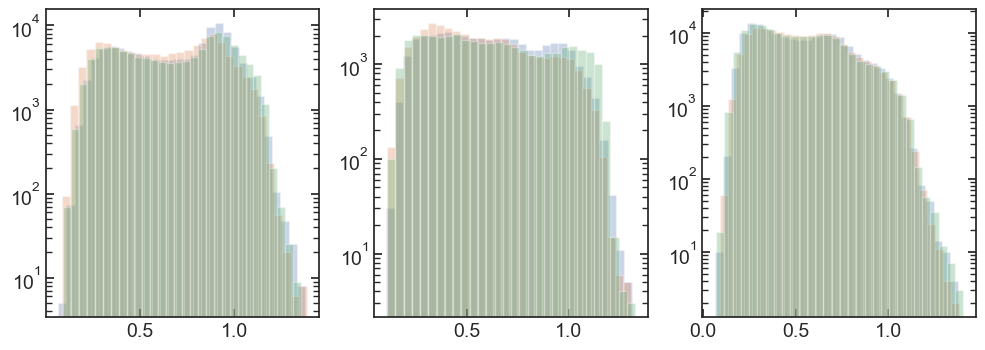

In [27]:
# Look at distribution of log_ec50_lig_err to set thresholds for data cleaning
plt.rcParams["figure.figsize"] = [12, 4]
fig, axs = plt.subplots(1, 3)

for ax, k in zip(axs, barcode_count_frame_dict):
    df = barcode_count_frame_dict[k]
    for c in ec50_cols:
        x = df[f'{c}_err']
        ax.hist(x, bins=30, alpha=0.3)
    ax.set_yscale('log');

In [28]:
# Data cleaning for variants with good ec50-based specificity measurement
min_ec50_thresh = 2.5
g0_thresh = 2.8
invert_thresh = 0.5
ginf_thresh = 3.5
count_thresh = 5000
sensor_n_thresh = 1.2
delta_ginf_thresh = np.log10(2)

for k in barcode_count_frame_dict:
    df = barcode_count_frame_dict[k]
    sel = df.log_g0<g0_thresh
    
    s = [df[f'hill_invert_prob_{lig}']<=invert_thresh for lig in ligand_list]
    sel = sel&(s[0]|s[1]|s[2])
    
    min_log_ec50 = np.array([x for x in df[ec50_cols].min(axis=1)])
    sel = sel&(min_log_ec50<min_ec50_thresh)
    
    min_lig = [x[x.rfind('_')+1:] for x in df[ec50_cols].idxmin(axis=1)]
    log_ginf_min_lig = []
    for (ind, row), m in zip(df.iterrows(), min_lig):
        c = f'log_ginf_{m}'
        log_ginf_min_lig.append(row[c])
    log_ginf_min_lig = np.array(log_ginf_min_lig)
    s1 = log_ginf_min_lig>ginf_thresh
    # Also make sure log_ginf for the specific variant is not too much lower than for the other variants
    max_ginf_lig = df[ginf_cols].max(axis=1)
    s2 = (max_ginf_lig - log_ginf_min_lig) < delta_ginf_thresh
    sel = sel&(s1&s2)
    
    sel = sel&(df.total_counts > count_thresh)
    
    n_zip = [list(df[c]) for c in n_cols]
    s2 = [np.all(np.array([a, b, c])>sensor_n_thresh) for a, b, c in zip(*n_zip)]
    sel = sel&s2
    
    df['good_ec50_spec'] = sel

In [29]:
# Pick highest specificity varaints to highlight in plot
highlight_index_dict = {}
for k in barcode_count_frame_dict:
    index_dict = {}
    df = barcode_count_frame_dict[k].iloc[2:]
    sel_num = int(len(df)/3000)
    print(f'{k}: {sel_num}')
    df = df[df.good_ec50_spec]
    for lig in ligand_list:
        df = df.sort_values(by=f'spec_{lig}', ascending=False)
        index_dict[lig] = list(df.index[:sel_num])
    print(f'    {len(index_dict[lig])}')
    highlight_index_dict[k] = index_dict

EP: 36
    36
SS: 13
    13
Shuffle: 53
    53


In [30]:
for k in barcode_count_frame_dict:
    df = barcode_count_frame_dict[k]
    df['highlight'] = 'none'
    for lig in ligand_list:
        index_list = highlight_index_dict[k][lig]
        df.loc[index_list, 'highlight'] = lig

In [31]:
# Print out info about highlighted variants
for k, df_0 in barcode_count_frame_dict.items():
    print(f'{k}, {len(df_0)}')
    for lig in ligand_list:
        df = df_0
        df = df[df[f'log_ec50_{lig}_err']<0.5]
        print(f'    log_ec50_{lig}_err, {len(df)}')
        df = df_0
        max_ginf = 10**df[f'log_ginf_{lig}'].max()
        print(f'    max_ginf: {max_ginf:.0f}')
        
        df = df[df[f'highlight']==lig]
        max_ginf = 10**df[f'log_ginf_{lig}'].max()
        print(f'    highlight {lig}, {len(df)}, max_ginf: {max_ginf:.0f}')
    print()

EP, 110274
    log_ec50_1-DIQ_err, 32665
    max_ginf: 40154
    highlight 1-DIQ, 36, max_ginf: 17527
    log_ec50_1R-TIQ_err, 40057
    max_ginf: 43375
    highlight 1R-TIQ, 36, max_ginf: 15512
    log_ec50_1S-TIQ_err, 35429
    max_ginf: 43865
    highlight 1S-TIQ, 36, max_ginf: 37947

SS, 40042
    log_ec50_1-DIQ_err, 15388
    max_ginf: 42679
    highlight 1-DIQ, 13, max_ginf: 31276
    log_ec50_1R-TIQ_err, 18193
    max_ginf: 45578
    highlight 1R-TIQ, 13, max_ginf: 31942
    log_ec50_1S-TIQ_err, 15895
    max_ginf: 44029
    highlight 1S-TIQ, 13, max_ginf: 36661

Shuffle, 159123
    log_ec50_1-DIQ_err, 78181
    max_ginf: 44034
    highlight 1-DIQ, 53, max_ginf: 27244
    log_ec50_1R-TIQ_err, 74723
    max_ginf: 41326
    highlight 1R-TIQ, 53, max_ginf: 21130
    log_ec50_1S-TIQ_err, 80048
    max_ginf: 41726
    highlight 1S-TIQ, 53, max_ginf: 30741



In [32]:
# to check how long it takes to make the plot (about 25 minutes):
print(datetime.datetime.now())

2024-12-31 14:12:30.056736


2024-12-31 14:12:31.305591
num_highlighted: 11
num_semi_highlighted: 15883
num_highlighted: 11
num_semi_highlighted: 15883
num_highlighted: 11
num_semi_highlighted: 15883


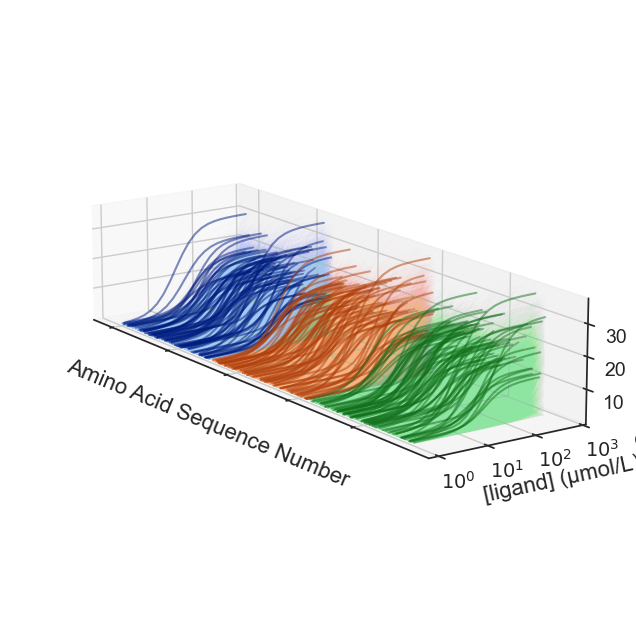

In [33]:
# Plot all the dose-response curves, with each ligand in a separate section:
# dark and pastel, separated by ligand (not library)
print(datetime.datetime.now())
rng_1 = np.random.default_rng(1)
rng_2 = np.random.default_rng(2)

plt.rcParams["figure.figsize"] = [12, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_ylabel(f'[ligand] (µmol/L)', labelpad=10);
ax.set_zlabel(f'Sensor Output');
ax.set_xlabel(f'Amino Acid Sequence Number', labelpad=40);

log_z_scale = False

x_offset = 0
x_gap = 10000
spec_quantile = 0.999


# Loop over ligands
for highlight_color, back_color, lig in zip(sns.color_palette('dark'), sns.color_palette('pastel'), ligand_list):

    # Loop over libraries
    for k in ['Shuffle', 'EP', 'SS']:
        num_highlighted = 0
        num_semi_highlighted = 0
        df = barcode_count_frame_dict[k].iloc[2:]
        df = df.sample(frac=1)
        #df = df.iloc[:1000]

        max_ind = len(df) + 1
        y = [np.log10(x) if x>0 else 0 for x in ligand_conc_list]

        ec_col_list = [f'log_ec50_{lig}_err' for lig in ligand_list]
        hill_params_list = ['log_g0']
        for lig in ligand_list:
            hill_params_list += [f'log_ginf_{lig}', f'log_ec50_{lig}', f'n_{lig}']
        iter_cols = ec_col_list + hill_params_list + ['highlight']
    
        # Loop over rows in each dataframe, using only the columns that are needed to reduce time
        for x, (ind, row) in enumerate(df[iter_cols].iterrows()):
            highlight = row.highlight
        
            x = [max_ind - x + x_offset]*len(y)
            #g_quant = row[f'GP_log_g_{lig}']
            #z = g_quant[2] #10**g_quant[2] / 1000
            
            ec50_err = row[f'log_ec50_{lig}_err']
            
            hill_params = ['log_g0', f'log_ginf_{lig}', f'log_ec50_{lig}', f'n_{lig}']
            hill_popt = [row[p] for p in hill_params]
            hill_popt = [10**x for x in hill_popt[:-1]] + hill_popt[-1:]
            
            if log_z_scale:
                z = np.log10(hill_funct(ligand_conc_list, *hill_popt))
            else:
                z = hill_funct(ligand_conc_list, *hill_popt)/1000

            if (highlight==lig) and (hill_popt[2]<200) and (hill_popt[1]>10000) and (hill_popt[1]<37000):
                alpha = 0.5
                linewidth = 1.5
                color = highlight_color
                z_order_bump = 50000
                num_highlighted += 1 
            elif ec50_err < 0.5:
                plot_p = 0.3
                alpha = rng_2.choice([0, 0.002], p=[1-plot_p, plot_p]) # 0.002
                linewidth = 1
                color = back_color
                z_order_bump = 40000
                num_semi_highlighted += 1
            else:
                plot_p = 0.01
                alpha = rng_2.choice([0, 0.002], p=[1-plot_p, plot_p]) # 0.002
                linewidth = 1
                color = back_color
                z_order_bump = 0
            z_order_bump += rng_1.integers(low=-1000, high=1001)
            ax.plot(x, y, z, alpha=alpha, color=color, linewidth=linewidth, zorder=x[0]+z_order_bump, rasterized=True);
        x_offset += len(df) #+ x_gap
    print(f'num_highlighted: {num_highlighted}')
    print(f'num_semi_highlighted: {num_semi_highlighted}')
    x_offset += x_gap
    
ax.set_box_aspect((1*x_offset/200000, 1.5, 1))
ax.view_init(15, -35)
ax.set_yticks([0, 1, 2, 3])
ax.set_zticks([10, 20, 30])
y_ticks = ax.get_yticks()
#y_tick_labels = [f"$10^{{{int(x)}}}$" if x>0 else 0 for x in y_ticks]
y_tick_labels = [f"$10^{{{int(x)}}}$" for x in y_ticks]
ax.yaxis.set_ticklabels(y_tick_labels)

if not log_z_scale:
    ax.set_zlim(0, 37)

ax.set_xticklabels([])

#ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    
os.chdir(notebook_directory)
#fig.savefig("Many dose-response curves.3D.svg", dpi=None, bbox_inches="tight")

In [34]:
print(datetime.datetime.now())

2024-12-31 14:36:36.345784


# Mutation histograms for EP and SS libraries

In [35]:
os.chdir(notebook_directory)
os.chdir('../Data')
mutation_stats_dict = {}
for k in ['EP', 'SS']:
    csv_file = f'mutation_stats.{k}.csv'
    mutation_stats_dict[k] = pd.read_csv(csv_file)
    
os.chdir(notebook_directory)

CDS
    EP
        median: 2.0
        mean: 2.35
    SS
        median: 7.0
        mean: 6.76
Amino Acid
    EP
        median: 1.0
        mean: 1.49
    SS
        median: 3.0
        mean: 2.82


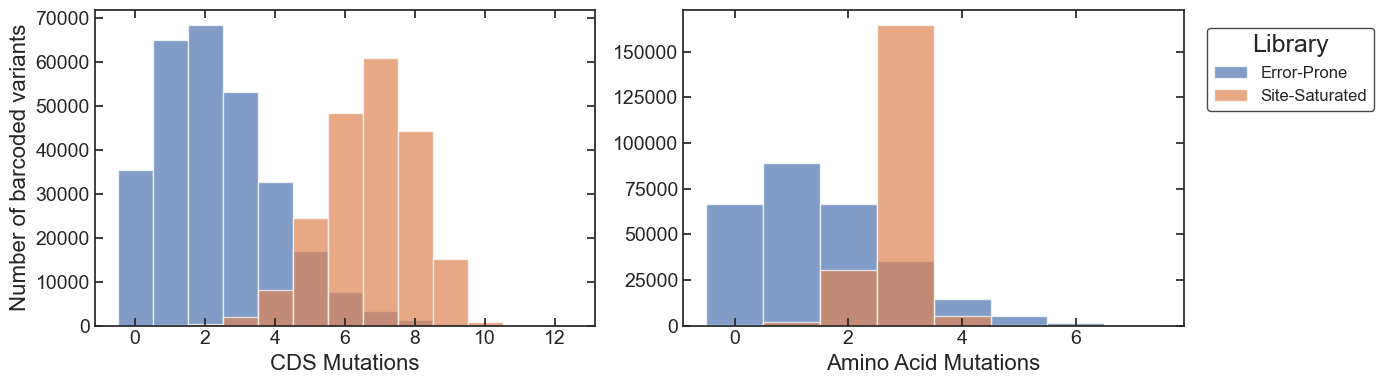

In [36]:
plt.rcParams["figure.figsize"] = [14, 4]
fig, axs = plt.subplots(1, 2, layout='tight')

param = 'ramR_amino_mutations'

for ax, param, bin_max, lab in zip(axs, ['ramR_cds_mutations', 'ramR_amino_mutations'], [12, 7], ['CDS', 'Amino Acid']):
    print(lab)
    bins = [n - 0.5 for n in range(bin_max+2)]
    #ax.set_title(param)
    for k, df in mutation_stats_dict.items():
        x = df[param]
        ax.hist(x, bins=bins, zorder=-10, alpha=0.7, label=titles_dict[k]);
        print(f'    {k}')
        print(f'        median: {np.median(x)}')
        print(f'        mean: {np.mean(x):.2f}')
    
    #ax.set_xscale('log');
    #ax.set_yscale('log');
    
    ax.set_xlabel(f'{lab} Mutations');
axs[0].set_ylabel('Number of barcoded variants');
axs[1].legend(loc='upper left', bbox_to_anchor= (1.03, 0.97), ncol=1, title='Library', title_fontsize=18);

# G0, EC50, and dynamic range histograms for each library

In [37]:
sns.set()

sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True, })
#sns.set_style({"axes.labelsize": 20, "xtick.labelsize" : 16, "ytick.labelsize" : 16})

plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.edgecolor'] = 'k'

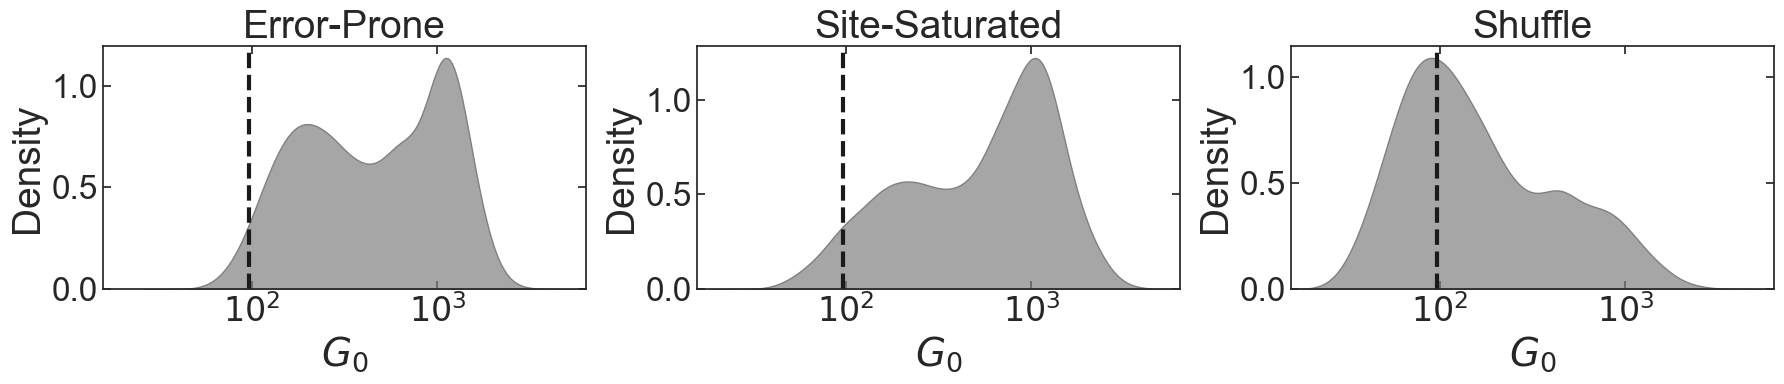

In [38]:
plt.rcParams["figure.figsize"] = [18, 4]
fig, axs = plt.subplots(1, 3, layout='tight')

bw_method = np.log10(1.5)

param = 'log_g0'

err_cutoff = 1.5

bin_min = 10
bin_max = -10
for k in barcode_count_frame_dict:
    df = barcode_count_frame_dict[k]
    df = df[df[f'{param}_err']<np.log10(err_cutoff)]
    x = df[param]
    bin_min = min(bin_min, min(x))
    bin_max = max(bin_max, max(x))

bins = np.logspace(bin_min, bin_max, 31)
for ax, k in zip(axs, barcode_count_frame_dict):
    ax.set_title(titles_dict[k])
    df = barcode_count_frame_dict[k]
    df = df[df[f'{param}_err']<np.log10(err_cutoff)]
    x = df[param]
    #x = 10**x
    #ax.hist(x, bins=bins, zorder=-10);
    sns.kdeplot(x=x.values, ax=ax, fill=True, color='gray', alpha=0.7, bw_method=bw_method);
    
    ylim = ax.get_ylim()
    ax.set_ylim(ylim)
    #wt_g0 = 10**wild_type_params_dict[k][param][0]
    wt_g0 = wild_type_params_dict[k][param][0]
    ax.plot([wt_g0]*2, ylim, '--k', lw=3)
    
    #ax.set_xscale('log');
    #ax.set_yscale('log');
    
    ax.set_xlim(bin_min, bin_max)
    
    ax.set_xlabel(formatted_param(param));
    

xticks = [n for n in range(1, 5)]
for ax in axs.flatten():
    #xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{' + f'{x:n}' + '}$' for x in xticks]);
    ax.set_xlim(1.2, 3.8)
os.chdir(notebook_directory)
#fig.savefig('g0_kde_plots.svg')

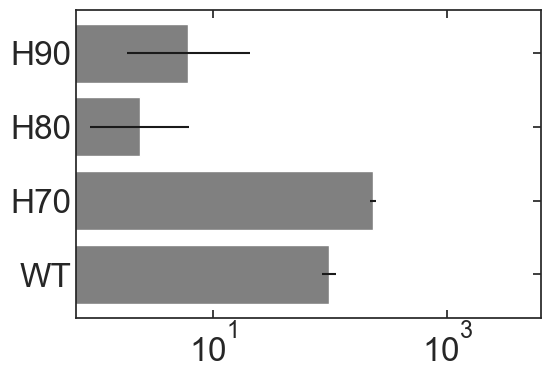

In [39]:
plt.rcParams["figure.figsize"] = [6, 4]
fig, ax = plt.subplots()

var_list = ['pRamR-WT', 'pRamR-H70', 'pRamR-H80', 'pRamR-H90']
y = [v.replace('pRamR-', '') for v in var_list]
x = []
xerr = []
for var in var_list:
    df = cytom_fits_df
    df = df[df.variant==var]
    log_g0 = df.iloc[0]['log_g0']
    x.append(log_g0)
    
    log_g0_err = df.iloc[0]['log_g0_err']
    xerr.append(log_g0_err)

x = np.array(x)
xerr = np.array(xerr)
xerr = log_plot_errorbars(x, xerr)
x = 10**x
    
ax.barh(y, x, color='gray', xerr=xerr)
ax.set_xscale('log')
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], 10**3.8);
#fig.savefig('g0_bar_plot.svg')
#fig.savefig('g0_bar_plot.axis_matched.svg')

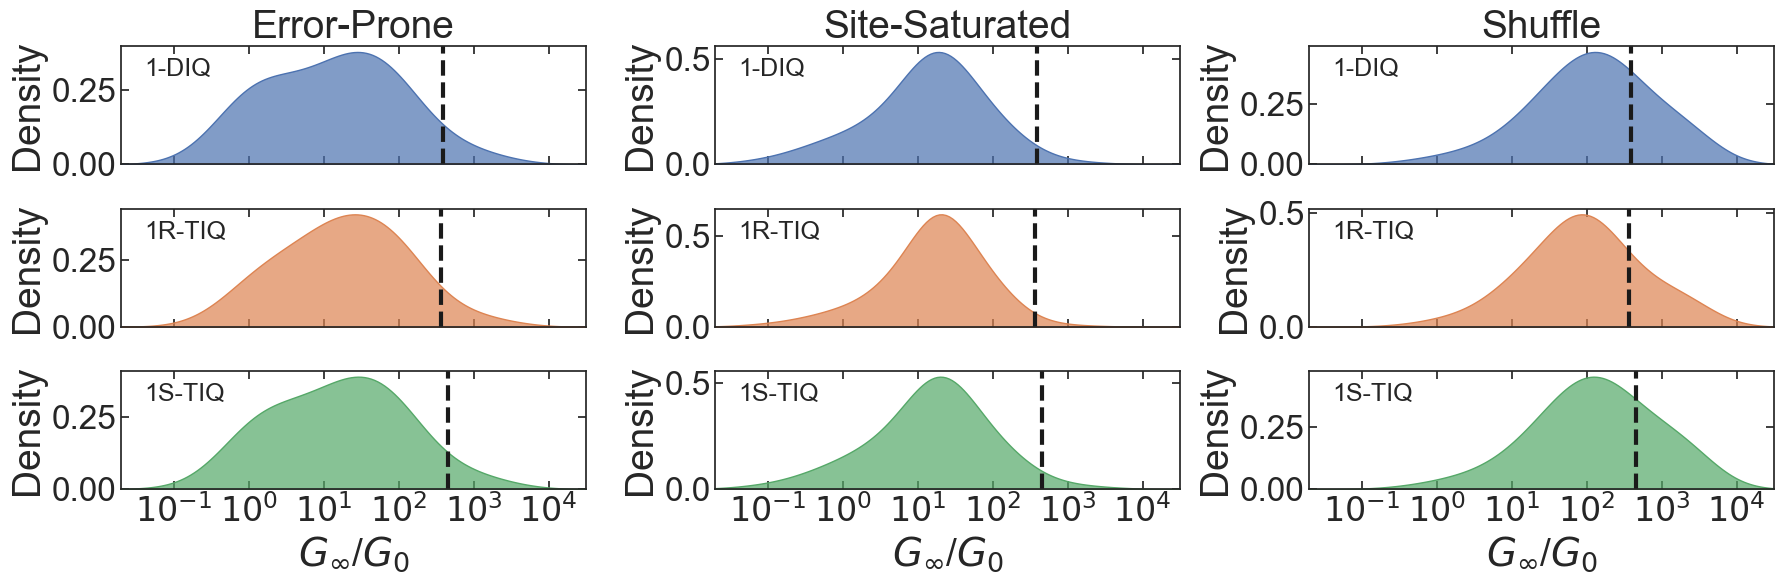

In [40]:
# Ginf histograms oriented the same way as the G0 histograms
# KDE plots for Fig. 2
plt.rcParams["figure.figsize"] = [18, 6]
fig, axs = plt.subplots(3, 3, layout='tight')

bw_method = np.log10(3)

err_cutoff = 1000 # set cutoff very high - so nothing is cut, since the higher err variants are the flat-line ones

bin_min = 10
bin_max = -10
for lig in ligand_list:
    param = f'log_ginf_g0_ratio_{lig}'
    for k in barcode_count_frame_dict:
        df = barcode_count_frame_dict[k]
        df = df[df[f'{param}_err']<np.log10(err_cutoff)]
        x = df[param]
        bin_min = min(bin_min, min(x))
        bin_max = max(bin_max, max(x))
#bin_min = -1.7 # manually override lower bin limit
#bin_max = 4.3 # manually override upper bin limit
bins = np.logspace(bin_min, bin_max, 31)

for ax_row, lig, color in zip(axs, ligand_list, sns.color_palette()):
    param = f'log_ginf_g0_ratio_{lig}'
    for ax, k in zip(ax_row, barcode_count_frame_dict):
        #ax.set_xscale('log');
        #ax.set_yscale('log');
        if ax in axs[0]:
            ax.set_title(titles_dict[k])
            
        if ax in axs[-1]:
            ax.set_xlabel(formatted_param(param).replace(', 1S-TIQ', ''));
        else:
            ax.tick_params(labelbottom=False)
            
        df = barcode_count_frame_dict[k]
        df = df[df[f'{param}_err']<np.log10(err_cutoff)]
        x = df[param]
        #x = 10**x
        #ax.hist(x, bins=bins, zorder=-10, color=color);
        sns.kdeplot(x=x.values, ax=ax, fill=True, color=color, alpha=0.7, bw_method=bw_method);
            
        ylim = ax.get_ylim()
        ax.set_ylim(ylim)
        wt_g0 = wild_type_params_dict[k][param][0]
        ax.plot([wt_g0]*2, ylim, '--k', lw=3)

        ax.text(x=0.05, y=0.9, s=lig, horizontalalignment='left', verticalalignment='top',
                     transform=ax.transAxes, fontsize=18)
    
xticks = [n for n in range(-1, 5)]
for ax in axs.flatten():
    #xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{' + f'{x:n}' + '}$' for x in xticks]);
    
    ax.set_xlim(-1.7, 4.5)
os.chdir(notebook_directory)
#fig.savefig('ginf_g0_kde_plots.svg')

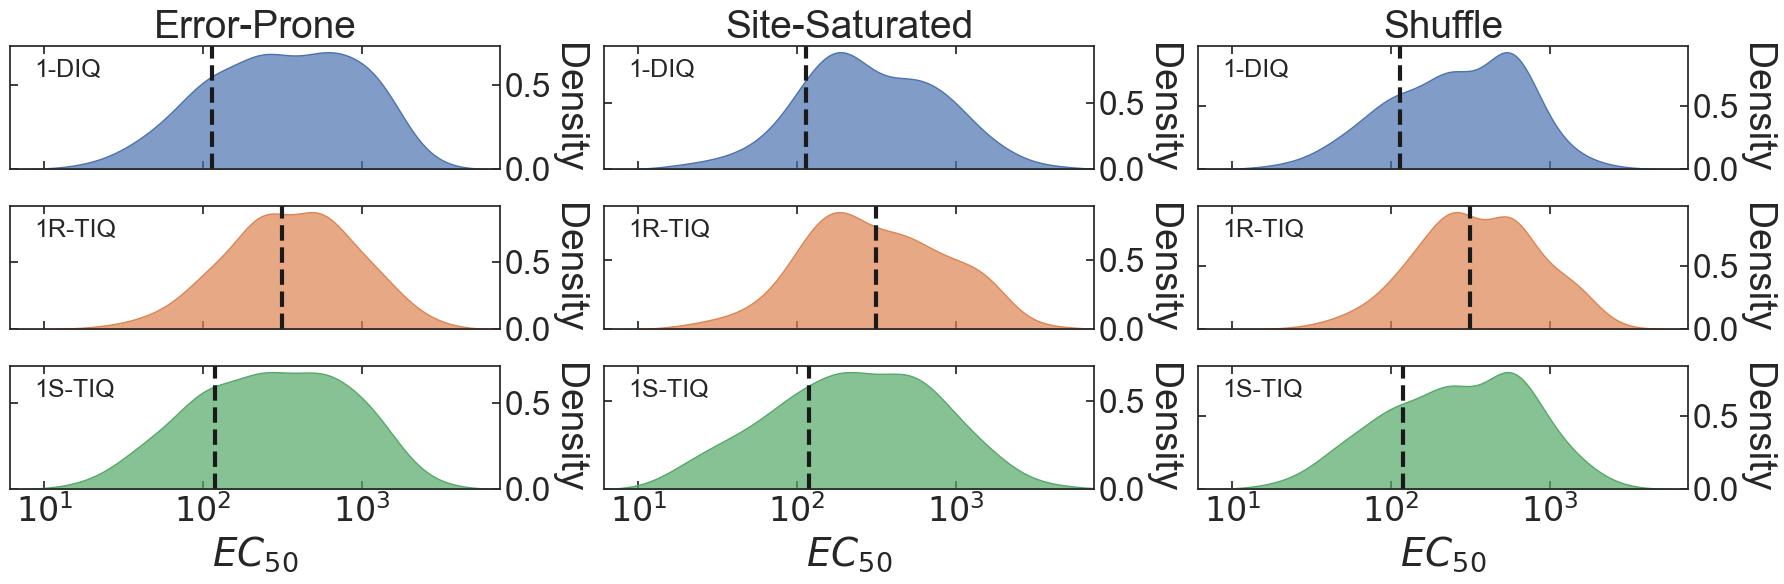

In [41]:
# EC50 oriented the same way as the G0 histograms
# KDE plots for Fig. 2
plt.rcParams["figure.figsize"] = [18, 6]
fig, axs = plt.subplots(3, 3, layout='tight')

bw_method = np.log10(2)

# again, no error cutoff, since the higher err variants are the flat-line ones (high EC50)

bin_min = 10
bin_max = -10
for lig in ligand_list:
    param = f'log_ec50_{lig}'
    for k in barcode_count_frame_dict:
        df = barcode_count_frame_dict[k]
        x = df[param]
        bin_min = min(bin_min, min(x))
        bin_max = max(bin_max, max(x))
#bin_min = -1.7 # manually override lower bin limit
bins = np.logspace(bin_min, bin_max, 31)

for ax_row, lig, color in zip(axs, ligand_list, sns.color_palette()):
    param = f'log_ec50_{lig}'
    for ax, k in zip(ax_row, barcode_count_frame_dict):
        #ax.set_xscale('log');
        #ax.set_yscale('log');
        if ax in axs[0]:
            ax.set_title(titles_dict[k])
            
        if ax in axs[-1]:
            ax.set_xlabel(formatted_param(param).replace(', 1S-TIQ', ''));
        else:
            ax.tick_params(labelbottom=False)
            
        df = barcode_count_frame_dict[k]
        x = df[param]
        #x = 10**x
        #ax.hist(x, bins=bins, zorder=-10, color=color);
        sns.kdeplot(x=x.values, ax=ax, fill=True, color=color, alpha=0.7, bw_method=bw_method);
            
        ylim = ax.get_ylim()
        ax.set_ylim(ylim)
        wt_g0 = wild_type_params_dict[k][param][0]
        ax.plot([wt_g0]*2, ylim, '--k', lw=3)

        ax.text(x=0.05, y=0.9, s=lig, horizontalalignment='left', verticalalignment='top',
                     transform=ax.transAxes, fontsize=18)
        
        
        ax.set_xlim(bin_min, bin_max)
    

xticks = [n for n in range(1, 4)]
for ax in axs.flatten():
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Density', rotation=270, labelpad=25)
    #xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{' + f'{x:n}' + '}$' for x in xticks]);
    
os.chdir(notebook_directory)
#fig.savefig('ec50_kde_plots.svg')

# Specificity plots

In [42]:
# Set of variants to highlight in specificity plots
selected_vars = ['homolog_70', 'homolog_80', 'homolog_90', 'wild-type']

In [43]:
def add_wild_type_mean(df, library):
    if 'variant' not in df.columns:
        df['variant'] = ''
    rng_1 = np.random.default_rng(1)
    
    new_row = df[['wt' in x for x in df.variant]].iloc[0].copy()
    
    wt_dict = wild_type_params_dict[library]
    
    copy_cols = np.intersect1d(df.columns, list(wt_dict.keys()))
    print(copy_cols)
    
    for k in copy_cols:
        v = wt_dict[k]
        x = v[0]
        xerr = v[1]
        new_row[k] = x
        new_row[f'{k}_err'] = xerr
        if f'{k}_samples' in new_row.keys():
            new_row[f'{k}_samples'] = rng_1.normal(x, xerr, len(new_row[f'{k}_samples']))
        if f'{k}_samp' in new_row.keys():
            new_row[f'{k}_samp'] = rng_1.normal(x, xerr, len(new_row[f'{k}_samp']))
            
    new_row['variant'] = 'wild-type'
    new_row.name = -1
    
    new_df = pd.DataFrame([new_row])
    df = pd.concat([new_df, df], axis=0)
    
    return df

In [44]:
for k in barcode_count_frame_dict:
    barcode_count_frame_dict[k] = add_wild_type_mean(barcode_count_frame_dict[k], k)

['g32_spec_1-DIQ' 'g32_spec_1R-TIQ' 'g32_spec_1S-TIQ' 'log_ec50_1-DIQ'
 'log_ec50_1R-TIQ' 'log_ec50_1S-TIQ' 'log_g0' 'log_g32_g0_ratio_1-DIQ'
 'log_g32_g0_ratio_1R-TIQ' 'log_g32_g0_ratio_1S-TIQ' 'log_g500_1-DIQ'
 'log_g500_1R-TIQ' 'log_g500_1S-TIQ' 'log_g500_g0_ratio_1-DIQ'
 'log_g500_g0_ratio_1R-TIQ' 'log_g500_g0_ratio_1S-TIQ' 'log_ginf_1-DIQ'
 'log_ginf_1R-TIQ' 'log_ginf_1S-TIQ' 'log_ginf_g0_ratio_1-DIQ'
 'log_ginf_g0_ratio_1R-TIQ' 'log_ginf_g0_ratio_1S-TIQ']
['g32_spec_1-DIQ' 'g32_spec_1R-TIQ' 'g32_spec_1S-TIQ' 'log_ec50_1-DIQ'
 'log_ec50_1R-TIQ' 'log_ec50_1S-TIQ' 'log_g0' 'log_g32_g0_ratio_1-DIQ'
 'log_g32_g0_ratio_1R-TIQ' 'log_g32_g0_ratio_1S-TIQ' 'log_g500_1-DIQ'
 'log_g500_1R-TIQ' 'log_g500_1S-TIQ' 'log_g500_g0_ratio_1-DIQ'
 'log_g500_g0_ratio_1R-TIQ' 'log_g500_g0_ratio_1S-TIQ' 'log_ginf_1-DIQ'
 'log_ginf_1R-TIQ' 'log_ginf_1S-TIQ' 'log_ginf_g0_ratio_1-DIQ'
 'log_ginf_g0_ratio_1R-TIQ' 'log_ginf_g0_ratio_1S-TIQ']
['g32_spec_1-DIQ' 'g32_spec_1R-TIQ' 'g32_spec_1S-TIQ' 'log_ec50_1-DI

## Specificity based on GP_log_g_ at 32 umol/L (index=3), Fig. 2c:

In [45]:
def add_wild_type_log_g_32(df):
    rng_1 = np.random.default_rng(1)
    wt_index = df[df.variant=='wild-type'].index[0]
    
    for lig in ligand_list:
        p = f'log_g32_g0_ratio_{lig}'

        mu = wild_type_params_dict['EP'][p][0]
        std = wild_type_params_dict['EP'][p][1]
        
        df.at[wt_index, p] = mu
        
    return df

In [46]:
# Specificity based on GP_log_g_ at 32 umol/L (index=3)
# Add GP_log_g_32_ columns; then initial data filtering for plotting

g0_thresh = 2.8
invert_thresh = 0
count_thresh = 5000

df_plots_GP = {}
for k, df in barcode_count_frame_dict.items():
    df = df.copy()
    print(f'{k}, starting length: {len(df)}')
    
    for lig in ligand_list:
        #log_g_arr = np.array([log_g for log_g in df[f'GP_log_g_{lig}']])
        
        #log_g_32 = log_g_arr[:,2,3] - log_g_arr[:,2,0]
        #df[f'log_g_32_{lig}'] = log_g_32
        
        #log_g_samp = np.array([log_g for log_g in df[f'GP_log_g_{lig}_samp']])
        #log_g_32_samp = (log_g_samp[:, 3, :] - log_g_samp[:, 0, :])
        #df[f'log_g_32_{lig}_samp'] = list(log_g_32_samp)
        
        #log_g_500 = log_g_arr[:,2,-1]
        #df[f'log_g_500_{lig}'] = log_g_500
        
        #dlog_g_arr = np.array([x for x in df[f'GP_dlog_g_{lig}']])
        s1 = np.array([x in selected_vars for x in df.variant])
        #s2 = [np.all(x>invert_thresh) for x in dlog_g_arr[:,4,:]]
        #df = df[s1]#|s2]
    print(f'    All GP_dlog_g_ > {invert_thresh}: {len(df)}')
    
    #log_g_arr = np.array([log_g for log_g in df[f'GP_log_g_{lig}']])
    #GP_log_g0 = log_g_arr[:,2,0]
    #df['GP_log_g0'] = GP_log_g0
    s1 = np.array([x in selected_vars for x in df.variant])
    s2 = df.log_g0 < g0_thresh
    df = df[s1|s2]
    print(f'    log_g0 < {g0_thresh}: {len(df)}')
    
    
    s1 = np.array([x in selected_vars for x in df.variant])
    s2 = df.total_counts > count_thresh
    df = df[s1|s2]
    print(f'    total_counts > {count_thresh}: {len(df)}')
    
    df = add_wild_type_log_g_32(df)
    
    print()
    df_plots_GP[k] = df

EP, starting length: 110275
    All GP_dlog_g_ > 0: 110275
    log_g0 < 2.8: 70641
    total_counts > 5000: 47222

SS, starting length: 40043
    All GP_dlog_g_ > 0: 40043
    log_g0 < 2.8: 17951
    total_counts > 5000: 16452

Shuffle, starting length: 159124
    All GP_dlog_g_ > 0: 159124
    log_g0 < 2.8: 145668
    total_counts > 5000: 86695



In [47]:
log_g_32_all = []
for k, df in df_plots_GP.items():
    for lig in ligand_list:
        log_g_32_all += list(df[f'log_g32_g0_ratio_{lig}'])

In [48]:
# For min_log_g_32, higher vaules are more specific; so specificity is reversed relative to log_ec50
min_log_g_32 = -max(log_g_32_all)
max_log_g_32 = -min(log_g_32_all)

In [49]:
min_log_g_32, max_log_g_32

(-4.03153264, 0.882589008)

In [50]:
tick_lists = np.array([[min_log_g_32, min_log_g_32, min_log_g_32+1, min_log_g_32+2, min_log_g_32+1, min_log_g_32+2],
                       [min_log_g_32+1, min_log_g_32+2, min_log_g_32, min_log_g_32, min_log_g_32+1, min_log_g_32+2],
                       [min_log_g_32+1, min_log_g_32+2, min_log_g_32+1, min_log_g_32+2, min_log_g_32, min_log_g_32]])

In [51]:
x_l, y_l = specificity_coords(*tick_lists, min_ec50=min_log_g_32, max_ec50=max_log_g_32)
log_tick_scale = min(y_l[np.isclose(x_l, 0)])
spec_scale = 1/log_tick_scale
log_tick_scale, spec_scale

(0.16615310719058662, 6.018545285782382)

In [52]:
specificity_coords(*tick_lists, min_ec50=min_log_g_32, max_ec50=max_log_g_32, scale=spec_scale)

(array([ 0.8660254 ,  1.73205081,  0.        ,  0.        , -0.8660254 ,
        -1.73205081]),
 array([-0.5, -1. ,  1. ,  2. , -0.5, -1. ]))

In [53]:
specificity_coords(*(tick_lists+1), min_ec50=min_log_g_32, max_ec50=max_log_g_32, scale=spec_scale)

(array([ 0.8660254 ,  1.73205081,  0.        ,  0.        , -0.8660254 ,
        -1.73205081]),
 array([-0.5, -1. ,  1. ,  2. , -0.5, -1. ]))

In [54]:
def short_lig(lig):
    if lig == '1-DIQ':
        s = 'D'
    else:
        s = lig[lig.find('-')-1]
    return s

In [55]:
%%time
# Add collumns for specificy to each ligand, with specificity := the y-coordinate in the simplex plot
# most specific variants for whicever ligand is 2nd in the list, 'ligands' (top of the specificity plots):

for ligands in [['1-DIQ', '1R-TIQ', '1S-TIQ'],
                ['1S-TIQ', '1-DIQ', '1R-TIQ'],
                ['1R-TIQ', '1S-TIQ', '1-DIQ']]:
    lig = ligands[1]
    print(lig)
    lig_char = short_lig(lig)

    for k, df in df_plots_GP.items():
        # Minus sign is to reverse specificity relative to log_ec50
        g_32_lists = [-np.array(df[f'log_g32_g0_ratio_{lig}']) for lig in ligands]
        
        x, y = specificity_coords(*g_32_lists, min_ec50=min_log_g_32, max_ec50=max_log_g_32, scale=spec_scale)
        df[f'{lig}_specificity'] = y
        df[f'{lig}_cross_spec'] = x
        df[f'{lig}_spec_theta'] = np.arctan2(x, y)*180/np.pi

1R-TIQ
1-DIQ
1S-TIQ
CPU times: total: 1.2 s
Wall time: 1.21 s


In [56]:
# Make histogram of _specificity_err
spec_err_list = []
for k, df in df_plots_GP.items():
    for lig in ligands:
        spec = df[f'g32_spec_{lig}_err']
        spec_err_list += list(spec)
len(spec_err_list)

451107

In [57]:
spec_err_thresh = np.log10(2)

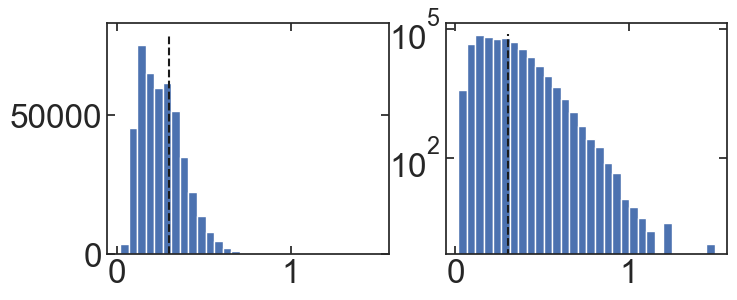

In [58]:
plt.rcParams["figure.figsize"] = [8, 3]
fig, axs = plt.subplots(1, 2)
for ax in axs:
    ax.hist(spec_err_list, bins=30);
    ylim = ax.get_ylim()
    ax.plot([spec_err_thresh]*2, ylim, '--k');
ax.set_yscale('log');

In [59]:
spec_cols = [x for x in df.columns if 'specificity' in x]
spec_cols = [x for x in spec_cols if ('cross' not in x) and ('theta' not in x) and ('err' not in x)]
spec_cols

['1R-TIQ_specificity', '1-DIQ_specificity', '1S-TIQ_specificity']

In [60]:
df = df_plots_GP['EP']
[x for x in df.columns if 'log' in x]

['log_g0',
 'log_g0_err',
 'log_ginf_1-DIQ',
 'log_ginf_1-DIQ_err',
 'log_ec50_1-DIQ',
 'log_ec50_1-DIQ_err',
 'log_ginf_g0_ratio_1-DIQ',
 'log_ginf_g0_ratio_1-DIQ_err',
 'log_g32_g0_ratio_1-DIQ',
 'log_g32_g0_ratio_1-DIQ_err',
 'log_g500_g0_ratio_1-DIQ',
 'log_g500_g0_ratio_1-DIQ_err',
 'log_g500_1-DIQ',
 'log_g500_1-DIQ_err',
 'log_ginf_1R-TIQ',
 'log_ginf_1R-TIQ_err',
 'log_ec50_1R-TIQ',
 'log_ec50_1R-TIQ_err',
 'log_ginf_g0_ratio_1R-TIQ',
 'log_ginf_g0_ratio_1R-TIQ_err',
 'log_g32_g0_ratio_1R-TIQ',
 'log_g32_g0_ratio_1R-TIQ_err',
 'log_g500_g0_ratio_1R-TIQ',
 'log_g500_g0_ratio_1R-TIQ_err',
 'log_g500_1R-TIQ',
 'log_g500_1R-TIQ_err',
 'log_ginf_1S-TIQ',
 'log_ginf_1S-TIQ_err',
 'log_ec50_1S-TIQ',
 'log_ec50_1S-TIQ_err',
 'log_ginf_g0_ratio_1S-TIQ',
 'log_ginf_g0_ratio_1S-TIQ_err',
 'log_g32_g0_ratio_1S-TIQ',
 'log_g32_g0_ratio_1S-TIQ_err',
 'log_g500_g0_ratio_1S-TIQ',
 'log_g500_g0_ratio_1S-TIQ_err',
 'log_g500_1S-TIQ',
 'log_g500_1S-TIQ_err']

In [61]:
# Extra filtering based on _specificity_err
ginf_thresh = 3.5

new_df_plots_GP = {}
for k, df in df_plots_GP.items():
    print(f'Starting length: {len(df)}')
    for lig in ligands:
        spec = df[f'g32_spec_{lig}_err']
        s_var = np.array([x in selected_vars for x in df.variant])
        df = df[(spec < spec_err_thresh)|(s_var)]
    print(f'    _specificity_err < {spec_err_thresh:.3f}: {len(df)}')
    
    max_lig = [c[:c.find('_')] for c in df[spec_cols].idxmax(axis=1)]
    
    s2 = []
    for (ind, row), ml in zip(df.iterrows(), max_lig):
        log_g = row[f'log_g500_{ml}']
        s2.append(log_g>ginf_thresh)
    s1 = np.array([x in selected_vars for x in df.variant])
    s2 = np.array(s2)
    df = df[s1|s2]
    print(f'    log_g500_lig > {ginf_thresh}: {len(df)}')
    
    new_df_plots_GP[k] = df
df_plots_GP = new_df_plots_GP

Starting length: 47222
    _specificity_err < 0.301: 31578
    log_g500_lig > 3.5: 15326
Starting length: 16452
    _specificity_err < 0.301: 13372
    log_g500_lig > 3.5: 6203
Starting length: 86695
    _specificity_err < 0.301: 40856
    log_g500_lig > 3.5: 19756


In [62]:
# Set of variants to highlight
cols = ['variant', 'log_ec50_1-DIQ', 'log_ec50_1R-TIQ', 'log_ec50_1S-TIQ', 
        'log_ginf_1-DIQ', 'log_ginf_1R-TIQ', 'log_ginf_1S-TIQ', 'log_g0', 'total_counts']
cols = ['variant', 'total_counts']
#cols += [x for x in df_plots_GP[0].columns if '_specificity' in x]
cols += [x for x in df_plots_GP['EP'].columns if '_specificity' in x]
df_selected_GP = {}
for k, df in df_plots_GP.items():
    df = df[[x in selected_vars for x in df.variant]]
    df_selected_GP[k] = df
    display(df[cols])

variant  total_counts  1R-TIQ_specificity  1-DIQ_specificity  \
-1  wild-type         76180           -0.845421            0.37561   

    1S-TIQ_specificity  
-1            0.469811

variant  total_counts  1R-TIQ_specificity  1-DIQ_specificity  \
-1  wild-type         22633           -0.845421            0.37561   

    1S-TIQ_specificity  
-1            0.469811

variant  total_counts  1R-TIQ_specificity  1-DIQ_specificity  \
-1        wild-type         30737           -0.845421           0.375610   
 164599  homolog_90       1080988            0.107002          -0.052787   
 212273  homolog_80      28596082           -0.222423           0.179243   
 231153  homolog_70       8138952            0.373315           0.000937   

         1S-TIQ_specificity  
-1                 0.469811  
 164599           -0.054215  
 212273            0.043181  
 231153           -0.374251

In [63]:
def var_text_pos_GP(variant):
    x = None
    y = None
    ha = 'center'
    if variant == 'homolog_70':
        x = -0.5
        y = 0.35
        ha = 'center'
    elif variant == 'homolog_80':
        x = 0.35
        y = 0.6
        ha = 'center'
    elif variant == 'homolog_90':
        x = -0.05
        y = -0.45
        ha = 'center'
    elif 'wild-type' in variant:
        x = 0.8
        y = -0.1
        ha = 'center'
    scale = 3
    return (x*scale, y*scale, ha)

In [64]:
spec_axis_scale = 3.5

In [65]:
x_list = -np.array([1, 1, 0, 1, 0, 1, 1])
y_list = -np.array([0, 1, 1, 1, 0, 1, 0])
z_list = -np.array([0, 1, 0, 1, 1, 1, 0])

ligand_coords_3d = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, -1]])

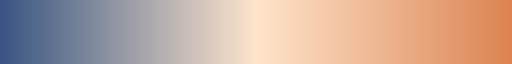

In [66]:
cmap = density_scatter_cmap()
cmap

log10 marker: 1.000
log10 marker: 2.000
max(y): 1.196
max(y): 1.718
max(y): 1.394


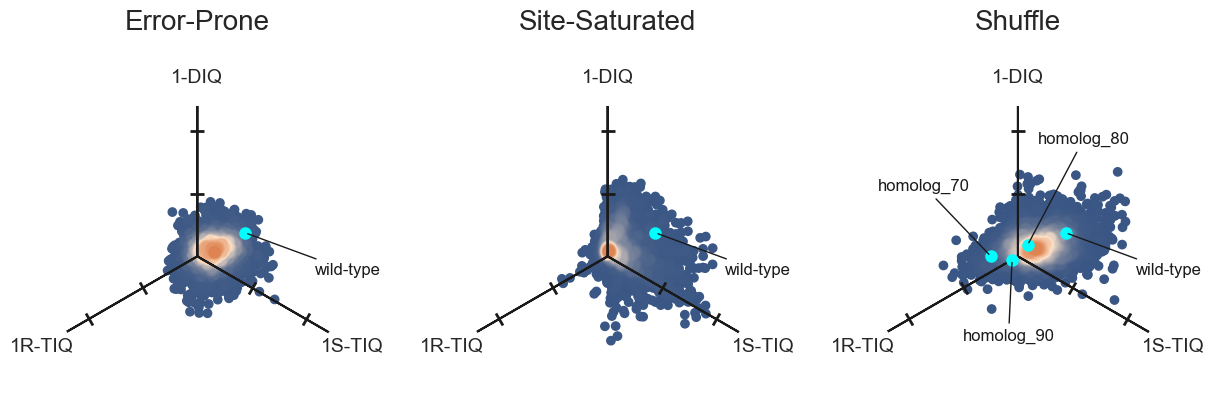

In [67]:
# The list, 'ligands' sets the orientation of ligand specificities in the plots:
#     the 2nd ligand in the list will be at the top
ligands = ['1S-TIQ', '1-DIQ', '1R-TIQ']

plt.rcParams["figure.figsize"] = [15, 5]
fig, axs = plt.subplots(1, 3)

for ax, (k, df) in zip(axs, df_plots_GP.items()):
    title = titles_dict[k]
    df_sel = df_selected_GP[k]
    ax.set_axis_off()
    ax.set_title(title, y=0.95, size=20)

    # This draws the axes
    x, y = specificity_coords(x_list, y_list, z_list, scale=spec_axis_scale)
    ax.plot(x, y, '-k');

    # This puts the ligand labels at the end of each axis
    x_l, y_l = specificity_coords(*ligand_coords_3d, scale=spec_axis_scale)
    for x, y, t in zip(x_l, y_l, ligands):
        ax.plot([x], [y], 'o', c='w', ms=40);
        ax.annotate(t, (x, y), ha='center', va='center', size=14)

    # This adds the tick marks
    x_l, y_l = specificity_coords(*tick_lists, min_ec50=min_log_g_32, max_ec50=max_log_g_32, scale=spec_scale)
    phi = [-30, -30, 90, 90, 210, 210]
    for x, y, p in zip(x_l, y_l, phi):
        ax.plot([x], [y], ls="none", c='k', zorder=100, marker=(2, 0, p), ms=10, markeredgewidth=2);
        if (p == 90) and (ax is axs[0]):
            print(f'log10 marker: {y:.3f}')
    ax.axis('equal')

    g_32_lists = [-np.array(df[f'log_g32_g0_ratio_{lig}']) for lig in ligands]
    g_32_sel = [-np.array(df_sel[f'log_g32_g0_ratio_{lig}']) for lig in ligands]
    var_list = df_sel.variant
    
    # This plots the data from the big tables
    x, y = specificity_coords(*g_32_lists, min_ec50=min_log_g_32, max_ec50=max_log_g_32, scale=spec_scale)
    if len(x) > 100:
        density_scatter_plot(x , y, ax=ax, log_x=False, log_y=False, log_z=False, cmap=cmap);
    else:
        ax.plot(x, y, 'o');
    print(f'max(y): {max(y):.3f}')
    
    # This plots the selected variants
    if len(g_32_sel[0])>0:
        x_l, y_l = specificity_coords(*g_32_sel, min_ec50=min_log_g_32, max_ec50=max_log_g_32, scale=spec_scale)
        for x, y, var in zip(x_l, y_l, var_list):
            ann_str = var
            fmt = 'o'
            ms = 8
            ax.plot([x], [y], fmt, c='cyan', zorder=50, ms=ms);
            xt, yt, ha = var_text_pos_GP(var)
            if xt is None:
                xytext = (2*x, 2*y)
                print(var)
            else:
                xytext = (xt, yt)
            ax.annotate(ann_str, (x, y), xytext=xytext, 
                        arrowprops=dict(arrowstyle='-', color='k'), 
                        c='k', zorder=55, ha=ha)

#fig.savefig('RamR G32-based specificity plots.svg', bbox_inches='tight')

# Mutation heat maps for EP and SS libraries

In [68]:
# Wild-type amino acid sequence

wild_type_aminos = 'MVARPKSEDKKQALLEAATQAIAQSGIAASTAVIARNAGVAEGTLFRYFATKDELINTLYLHLKQDLCQSMIMELDRSITDAKMMTRFIWNSYISWGLNHPARHRAIRQLAVSEKLTKETEQRADDMFPELRDLCHRSVLMVFMSDEYRAFGDGLFLALAETTMDFAARDPARAGEYIALGFEAMWRALTREEQ'

In [69]:
amino_codes = np.array([ x for x in 'RKHDEQNSTYWFAILMVGPC' ])
amino_codes, len(amino_codes)

(array(['R', 'K', 'H', 'D', 'E', 'Q', 'N', 'S', 'T', 'Y', 'W', 'F', 'A',
        'I', 'L', 'M', 'V', 'G', 'P', 'C'], dtype='<U1'),
 20)

In [70]:
#positions givien to these funnctions are residue positions (with 1-based indexing)
# function to outline SNP accessible substitutions
def outline_pos(pos, ax, c='k', linewidth=2, linestyle='-'):
    pos = np.array([pos[0]-1, pos[1]])
    r = plt.Rectangle(pos-0.45, 0.9,0.9, facecolor="none", edgecolor=c, linewidth=linewidth, linestyle=linestyle)
    ax.add_patch(r) 
#ax.add_patch(patches.Rectangle(*rect, transform=ax.transAxes, clip_on=False, zorder=zorder, color='w'));

# function to draw 'X' over substitution to indicate wild-type
def draw_x_pos(pos, ax, c='k', linewidth=2):
    w = linewidth
    pos = np.array([pos[0]-1, pos[1]])
    ax.plot([pos[0]-0.45, pos[0]+0.45], [pos[1]-0.45, pos[1]+0.45], linewidth=w, color=c)
    ax.plot([pos[0]-0.45, pos[0]+0.45], [pos[1]+0.45, pos[1]-.45], linewidth=w, color=c)

# function to draw '|' over substitution 
def draw_line_pos(pos, ax, c='k', linewidth=2):
    w = linewidth
    pos = np.array([pos[0]-1, pos[1]])
    ax.plot([pos[0], pos[0]], [pos[1]-0.45, pos[1]+0.45], linewidth=w, color=c)
    
# function to draw '+' over substitution
def draw_plus_pos(pos, ax, c='k', linewidth=2):
    w = linewidth
    pos = np.array([pos[0]-1, pos[1]])
    ax.plot([pos[0], pos[0]], [pos[1]-0.45, pos[1]+0.45], linewidth=w, color=c)
    ax.plot([pos[0]-0.45, pos[0]+0.45], [pos[1], pos[1]], linewidth=w, color=c)

## Mutation count heat maps

In [71]:
# Make arrays for heat-map plots of substitution abundance (variant count for each mutation)

substitution_counts = {}
for k in single_mutations_frame_dict:
    print(k)
    sub_count_arr = []
    missing_mut_list = []
    for i, c1 in enumerate(wild_type_aminos):
        pos = i+1
        count_sub_arr = []
        for c2 in amino_codes:
            if c2 == 'd':
                mut = f'{c1}{pos}del'
            else:
                mut = f'{c1}{pos}{c2}'
            df = single_mutations_frame_dict[k]
            df = df[df.mutation==mut]

            if len(df)==0:
                if c1 == c2:
                    count = 0.1 # mark the wild-type differently than zero
                else:
                    count = 0
                    missing_mut_list.append(mut)
            else:
                count = df.variant_count.sum()

            count_sub_arr.append(count)
        sub_count_arr.append(count_sub_arr)
    sub_count_arr = np.array(sub_count_arr)
    substitution_counts[k] = sub_count_arr
    print(sub_count_arr.shape)

EP
(194, 20)
SS
(194, 20)


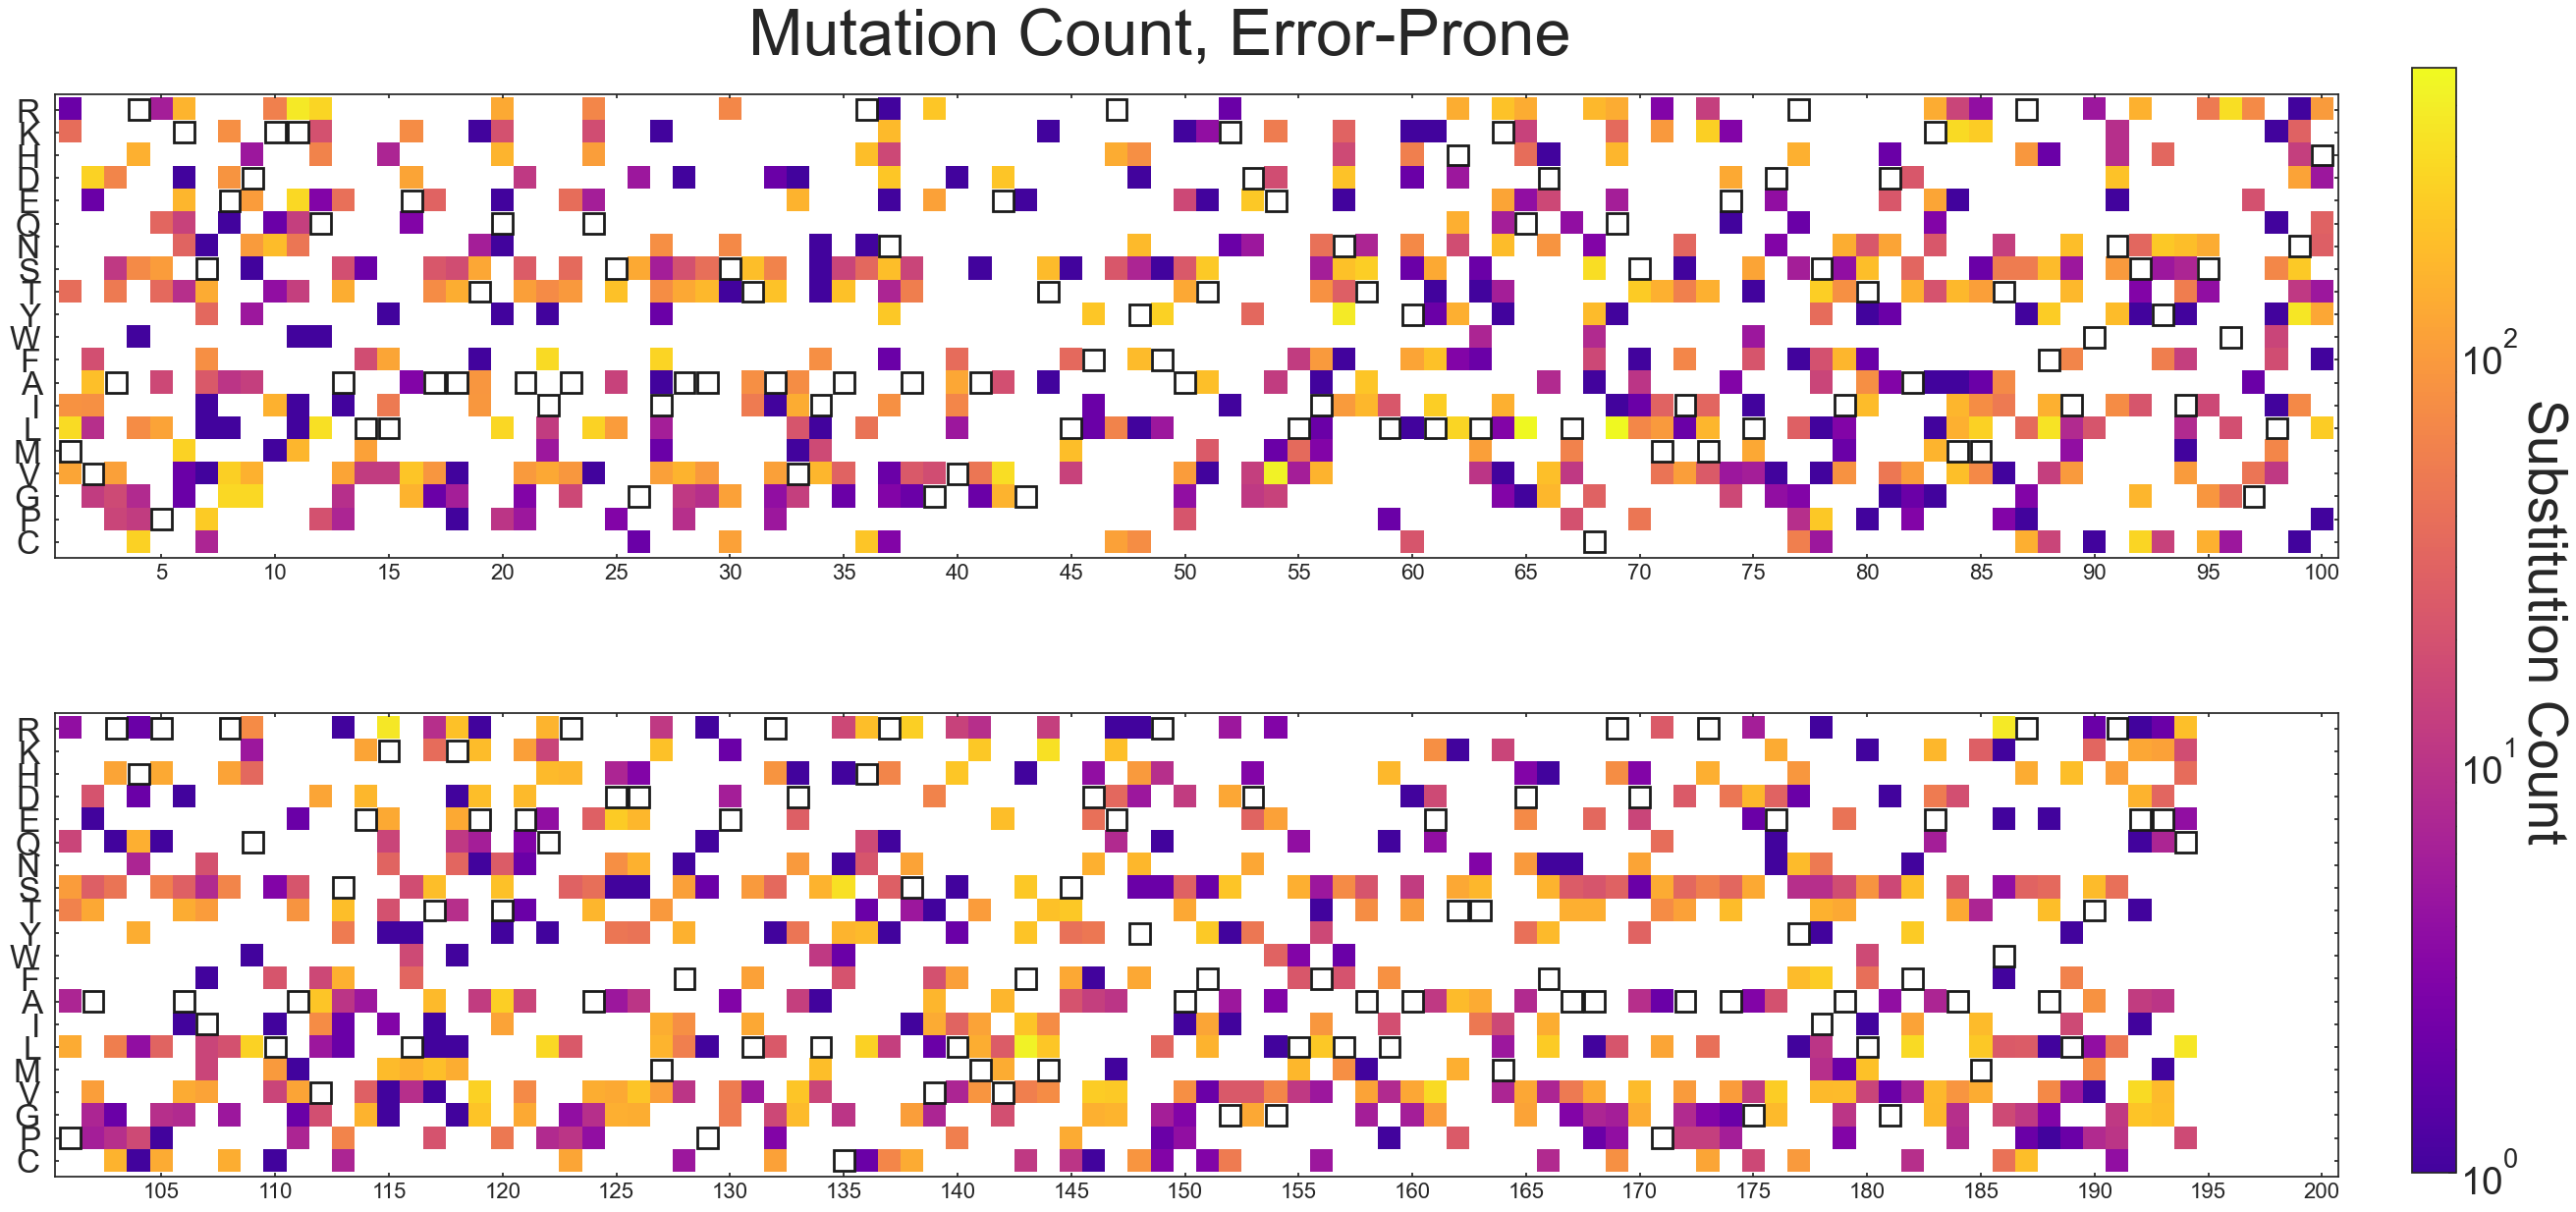

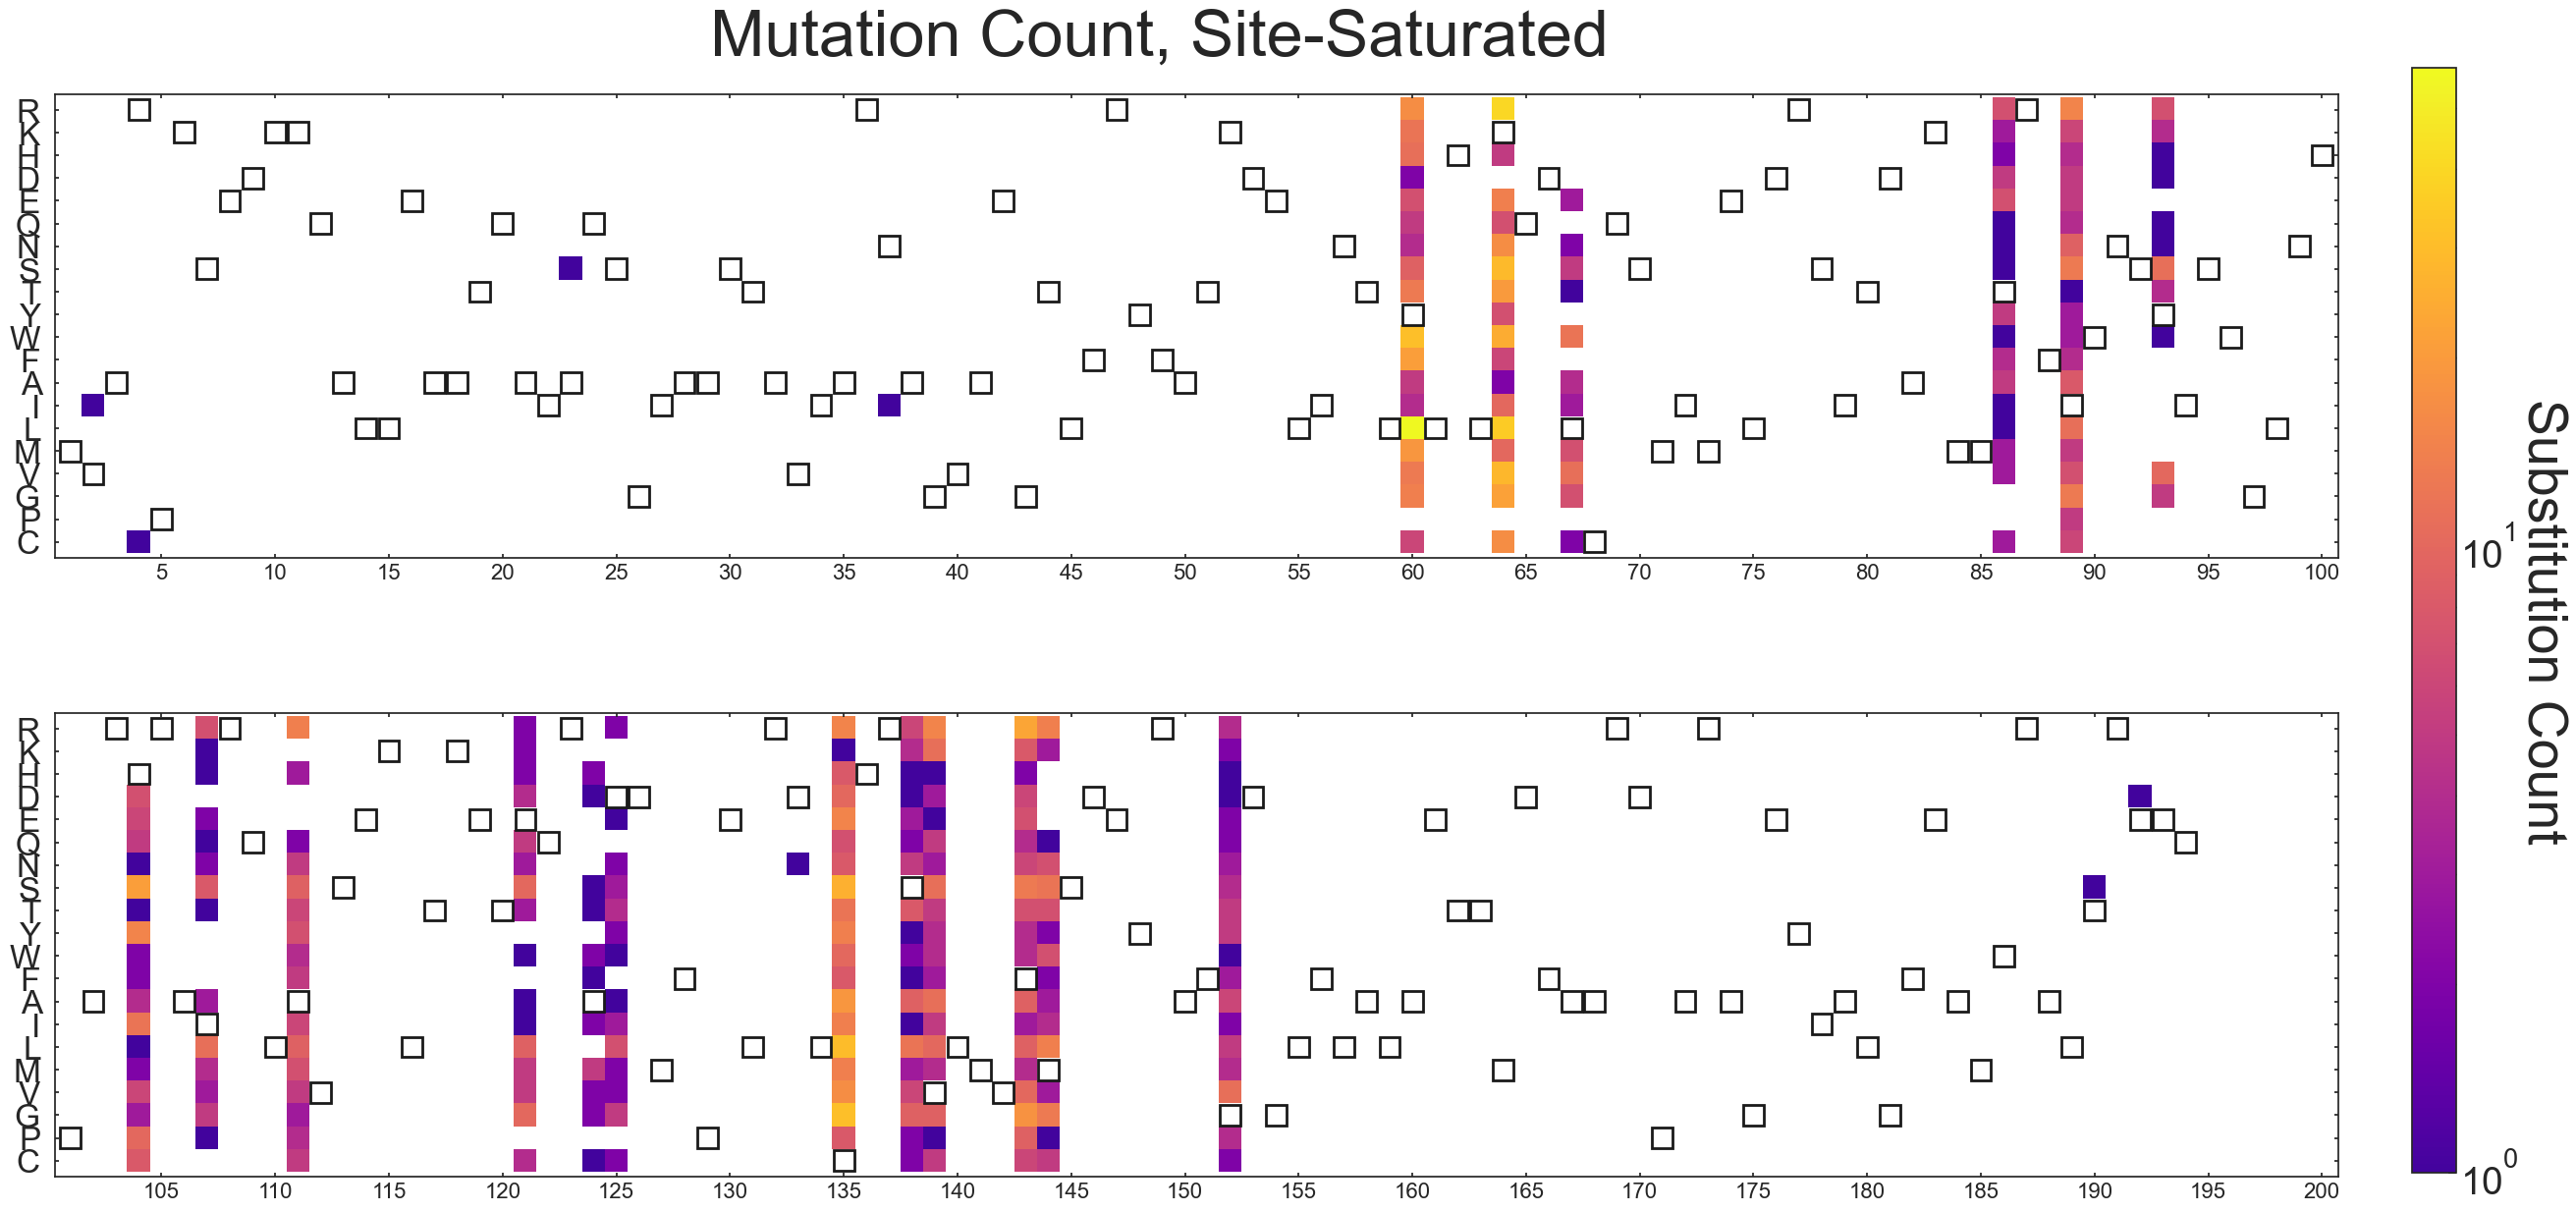

In [72]:
plt.rcParams["figure.figsize"] = [30,15]

for k, plot_arr in substitution_counts.items():
    fig, axs = plt.subplots(2, 1)
    fig.suptitle(f'Mutation Count, {titles_dict[k]}', size=48, y=0.92)

    vmin = 1
    vmax = np.max(plot_arr)

    cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

    cmap = copy.copy(colormaps["plasma"])
    cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
    cmap.set_under(color='white')
    cmap.set_bad(color='white')

    axis_cut_point = 101

    plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

    for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
        #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
        im = ax.imshow(arr.transpose(), norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap);
        #ax.set_axis_off();
        ax.grid(visible=False);
        if ax is axs[0]:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        else:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        ax.set_yticks([i for i in range(len(amino_codes))]);
        ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
        ax.set_yticklabels(ylabels) #, size=16);
        #ax.set_ylim(-0.5, 7.5);
        ax.tick_params(length=3);
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)
    fig.colorbar(im, cax=cb_ax);

    # outline and draw X to mark wild-type 
    for i, c in enumerate(wild_type_aminos):
        y_pos = np.where(amino_codes==c)[0][0]
        if i < axis_cut_point - 1:
            x_pos = i + 1
            ax = axs[0]
        else:
            x_pos = i - axis_cut_point + 2
            ax = axs[1]
        outline_pos((x_pos, y_pos), ax)
        #draw_x_pos((x_pos, y_pos), ax)

    cb_ax.tick_params(axis='y', labelsize=28)
    cb_ax.set_ylabel('Substitution Count', size=40, rotation=270, labelpad=35)

    axs[1].set_xlim(axs[0].get_xlim())

    os.chdir(notebook_directory)
    #fig.savefig(f"Mutation count heatmap.{k}.svg", dpi=None, bbox_inches="tight")

## G0 heat maps

In [73]:
# Make array for heat-map plot of G0 for each substitution

missing_fill_value = -5

single_log_g0_dict = {}
for k in single_mutations_frame_dict:
    log_g0_arr = []
    for i, c1 in enumerate(wild_type_aminos):
        pos = i+1
        log_g0_sub_arr = []
        for c2 in amino_codes:
            mut = f'{c1}{pos}{c2}'
            
            df = single_mutations_frame_dict[k]
            df = df[df.mutation==mut]

            if len(df)==0:
                if c1 == c2:
                    log_g0 = wild_type_params_dict[k]['log_g0'][0]
                else:
                    log_g0 = missing_fill_value
            else:
                log_g0 = df.sort_values(by='total_counts', ascending=False).iloc[0].log_g0

            log_g0_sub_arr.append(log_g0)
        log_g0_arr.append(log_g0_sub_arr)
    log_g0_arr = np.array(log_g0_arr)
    print(log_g0_arr.shape)
    single_log_g0_dict[k] = log_g0_arr

(194, 20)
(194, 20)


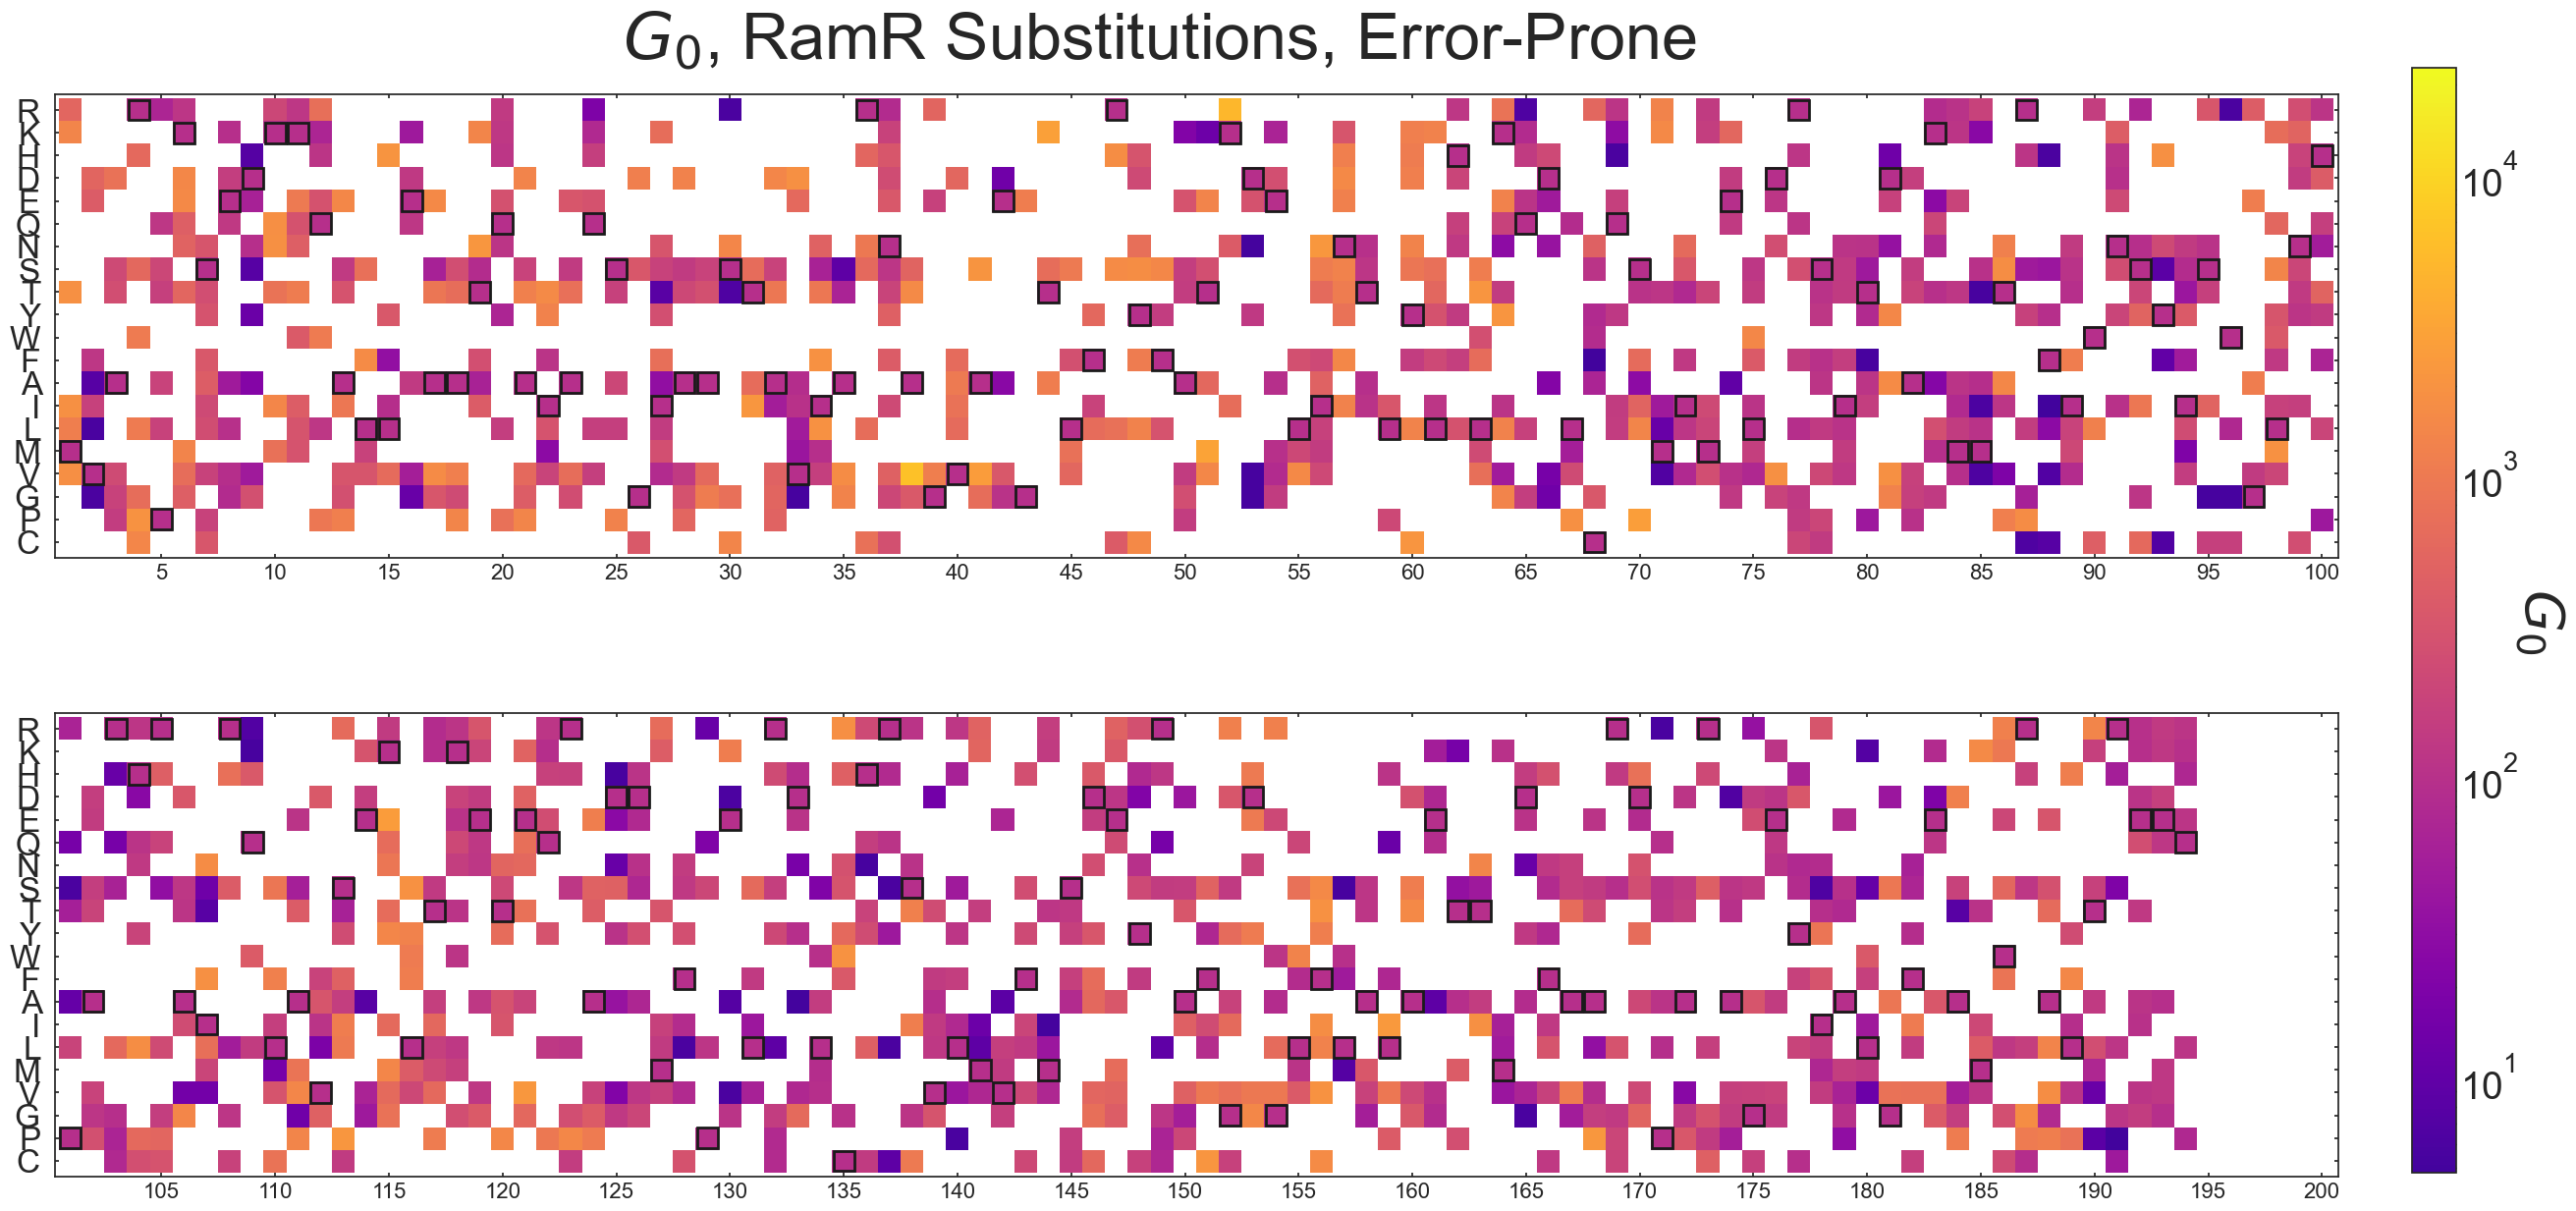

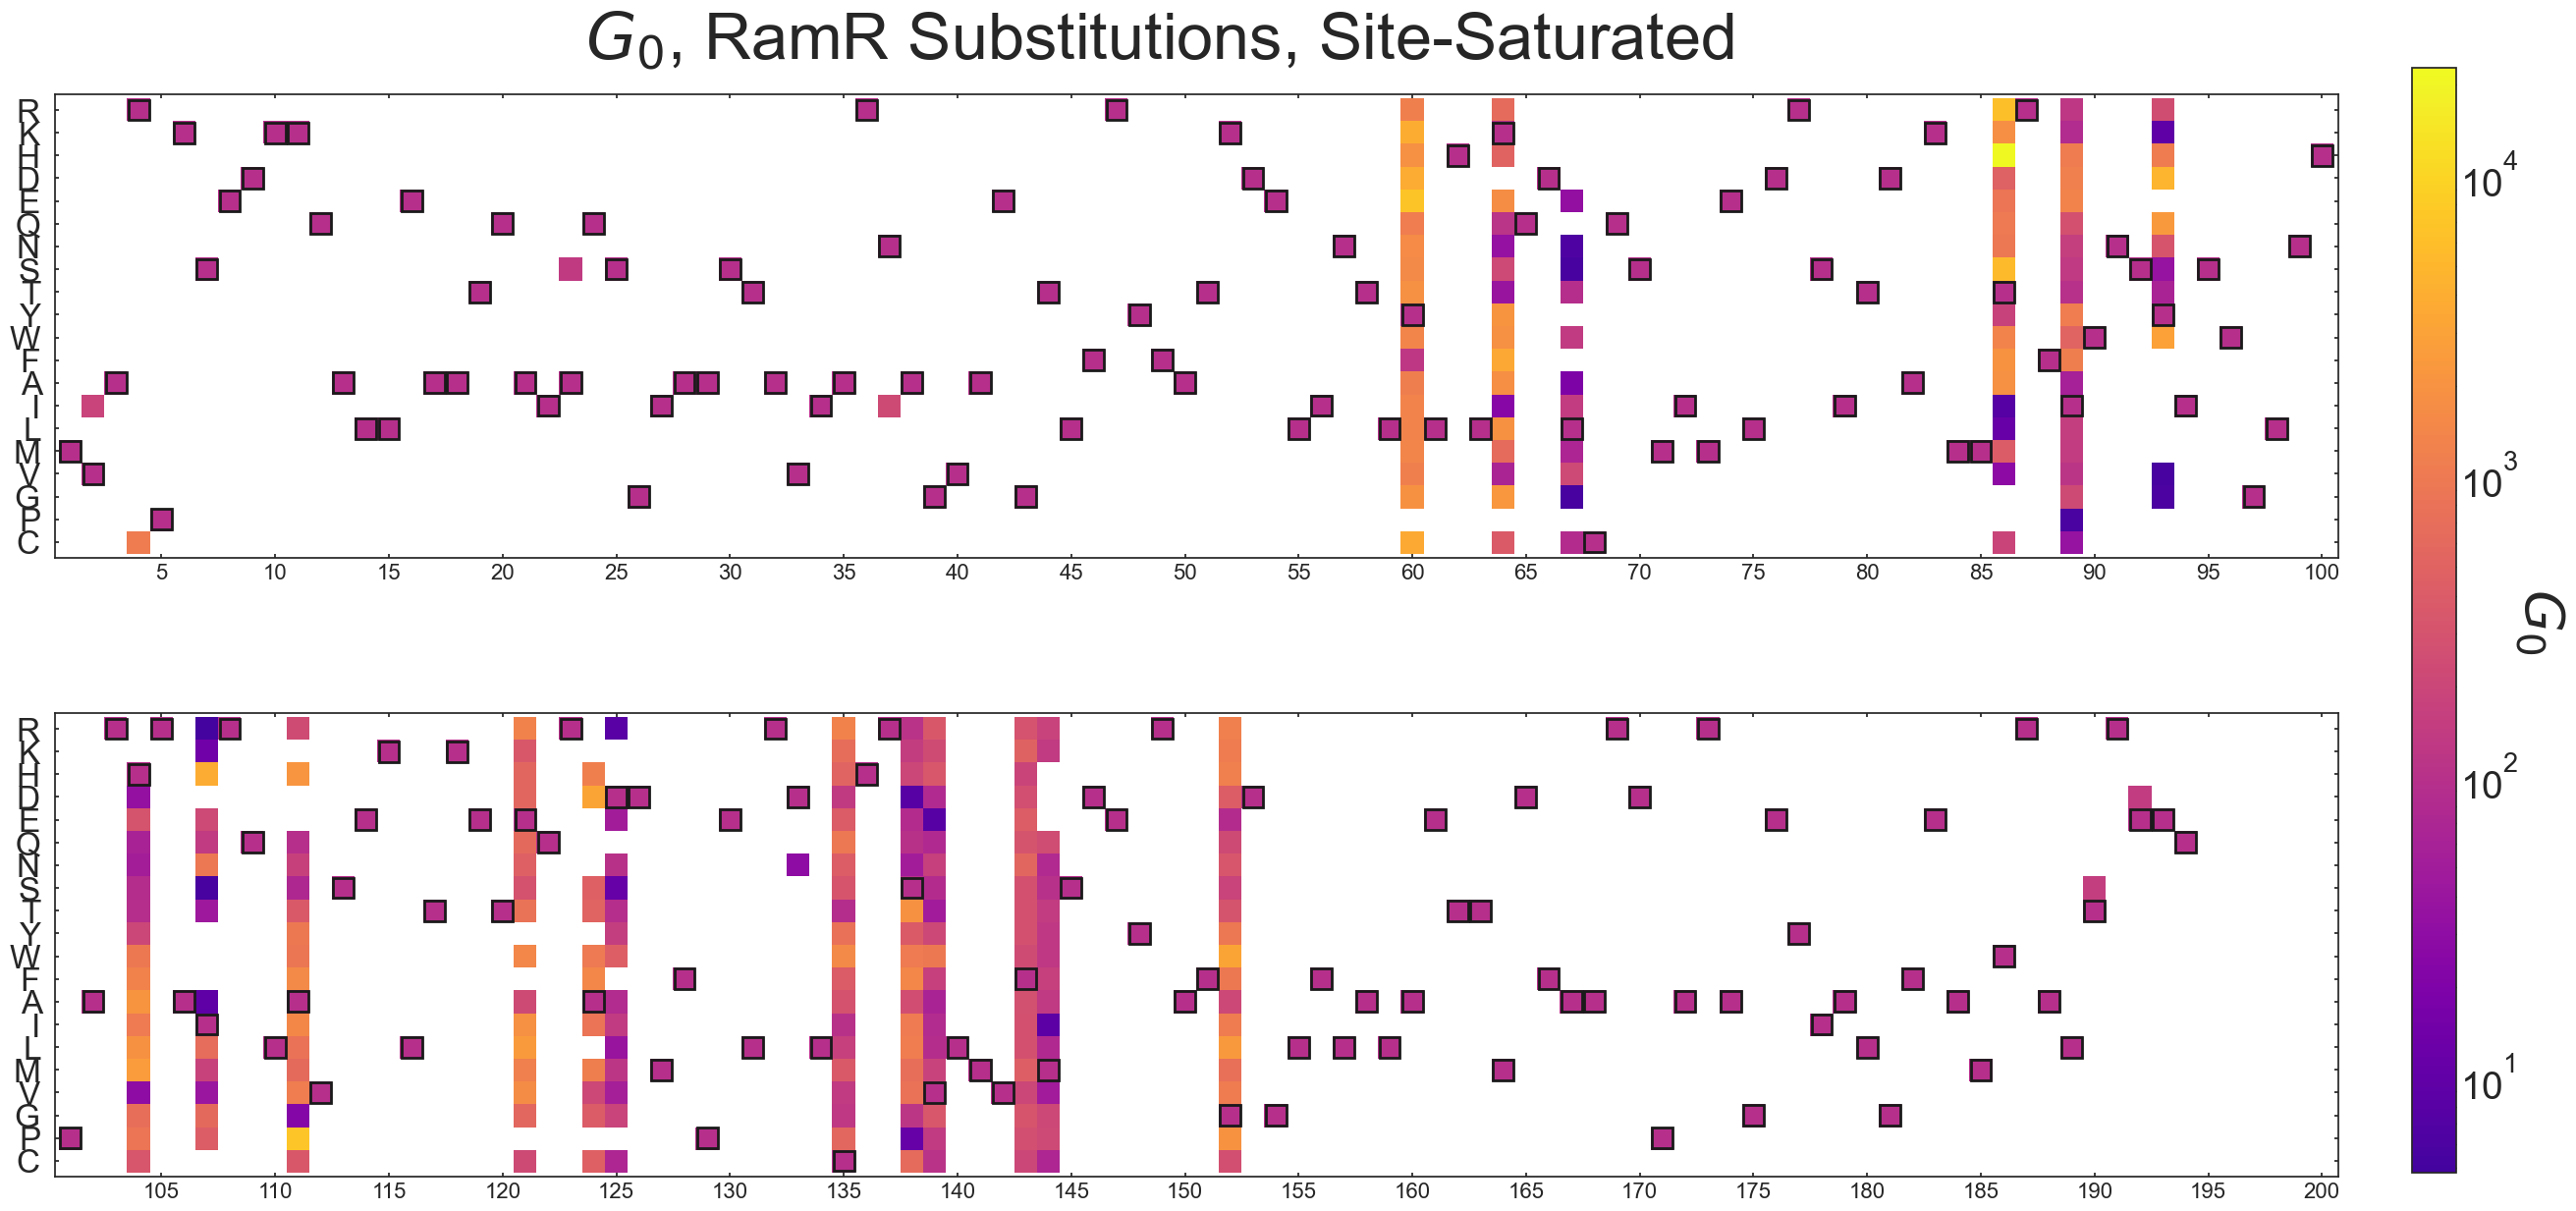

In [74]:
plt.rcParams["figure.figsize"] = [30,15]


vmin_ep = 10**single_mutations_frame_dict['EP'].log_g0.min()
vmax_ep = 10**single_mutations_frame_dict['EP'].log_g0.max()
vmin_ss = 10**single_mutations_frame_dict['SS'].log_g0.min()
vmax_ss = 10**single_mutations_frame_dict['SS'].log_g0.max()
vmin = min(vmin_ep, vmin_ss)
vmax = max(vmax_ep, vmax_ss)

for k, plot_arr in single_log_g0_dict.items():
    fig, axs = plt.subplots(2, 1)
    fig.suptitle('$G_0$, RamR Substitutions' + f', {titles_dict[k]}', size=48, y=0.92)

    plot_arr = 10**plot_arr

    cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

    cmap = copy.copy(colormaps["plasma"])
    cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
    cmap.set_under(color='white')
    cmap.set_bad(color='white')

    axis_cut_point = 101

    plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

    for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
        #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
        im = ax.imshow(arr.transpose(), norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap);
        #ax.set_axis_off();
        ax.grid(visible=False);
        if ax is axs[0]:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        else:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        ax.set_yticks([i for i in range(len(amino_codes))]);
        ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
        ax.set_yticklabels(ylabels) #, size=16);
        #ax.set_ylim(-0.5, 7.5);
        ax.tick_params(length=3);
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

        #for i, c in enumerate(arr):
        #    x_pos = i + 1
        #    for y_pos in np.where(c==10**missing_fill_value)[0]:
        #        draw_x_pos((x_pos, y_pos), ax)

    fig.colorbar(im, cax=cb_ax);

    # outline and draw X to mark wild-type 
    for i, c in enumerate(wild_type_aminos):
        y_pos = np.where(amino_codes==c)[0][0]
        if i < axis_cut_point - 1:
            x_pos = i + 1
            ax = axs[0]
        else:
            x_pos = i - axis_cut_point + 2
            ax = axs[1]
        outline_pos((x_pos, y_pos), ax)
        #draw_x_pos((x_pos, y_pos), ax)

    cb_ax.tick_params(axis='y', labelsize=28)
    cb_ax.set_ylabel('$G_0$', size=40, rotation=270, labelpad=35)

    axs[1].set_xlim(axs[0].get_xlim())

    os.chdir(notebook_directory)
    #fig.savefig(f"G0 heatmap.{k}.png", dpi=None, bbox_inches="tight")

## mean_log_ec50

In [75]:
ec50_cmap = colormaps['RdYlBu_r']

In [76]:
for k in wild_type_params_dict:
    mu = 0
    for lig in ligand_list:
        mu += wild_type_params_dict[k][f'log_ec50_{lig}'][0]
    mu = mu/len(ligand_list)
    wild_type_params_dict[k]['mean_log_ec50'] = (mu, 0.02)

In [77]:
# Make array for heat-map plot of plot_param for each substitution

plot_param = 'mean_log_ec50'
missing_fill_value = -5
err_cutoff = 0.5

single_mean_log_ec50_dict = {}
for k, df_0 in single_mutations_frame_dict.items():
    df_0 = df_0[df_0[f'{plot_param}_err']<err_cutoff]

    log_ec50_arr = []
    for i, c1 in enumerate(wild_type_aminos):
        pos = i+1
        log_g_ratio_sub_arr = []
        for c2 in amino_codes:
            if c2 == 'd':
                mut = f'{c1}{pos}del'
            else:
                mut = f'{c1}{pos}{c2}'
            df = df_0
            df = df[df.mutation==mut]

            if len(df)==0:
                if c1 == c2:
                    log_ec50 = wild_type_params_dict[k][plot_param][0]
                else:
                    log_ec50 = missing_fill_value
            else:
                log_ec50 = df.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]

            log_g_ratio_sub_arr.append(log_ec50)
        log_ec50_arr.append(log_g_ratio_sub_arr)
    log_ec50_arr = np.array(log_ec50_arr)
    print(log_ec50_arr.shape)
    single_mean_log_ec50_dict[k] = log_ec50_arr

(194, 20)
(194, 20)


In [78]:
wt_log_ec50 = wild_type_params_dict[k][plot_param][0]

log_ec50_min = single_mutations_frame_dict['EP'][plot_param].min()
log_ec50_min = min(log_ec50_min, single_mutations_frame_dict['SS'][plot_param].min())

log_ec50_max = np.log10(500)

min_span = wt_log_ec50 - log_ec50_min
max_span = log_ec50_max - wt_log_ec50

if min_span > max_span:
    vmin_ec50 = 10**(wt_log_ec50 - min_span)
    vmax_ec50 = 10**(wt_log_ec50 + min_span)
else:
    vmin_ec50 = 10**(wt_log_ec50 - max_span)
    vmax_ec50 = 10**(wt_log_ec50 + max_span)

vmin_ec50, vmax_ec50

(24.715515322412994, 1062.8459696035304)

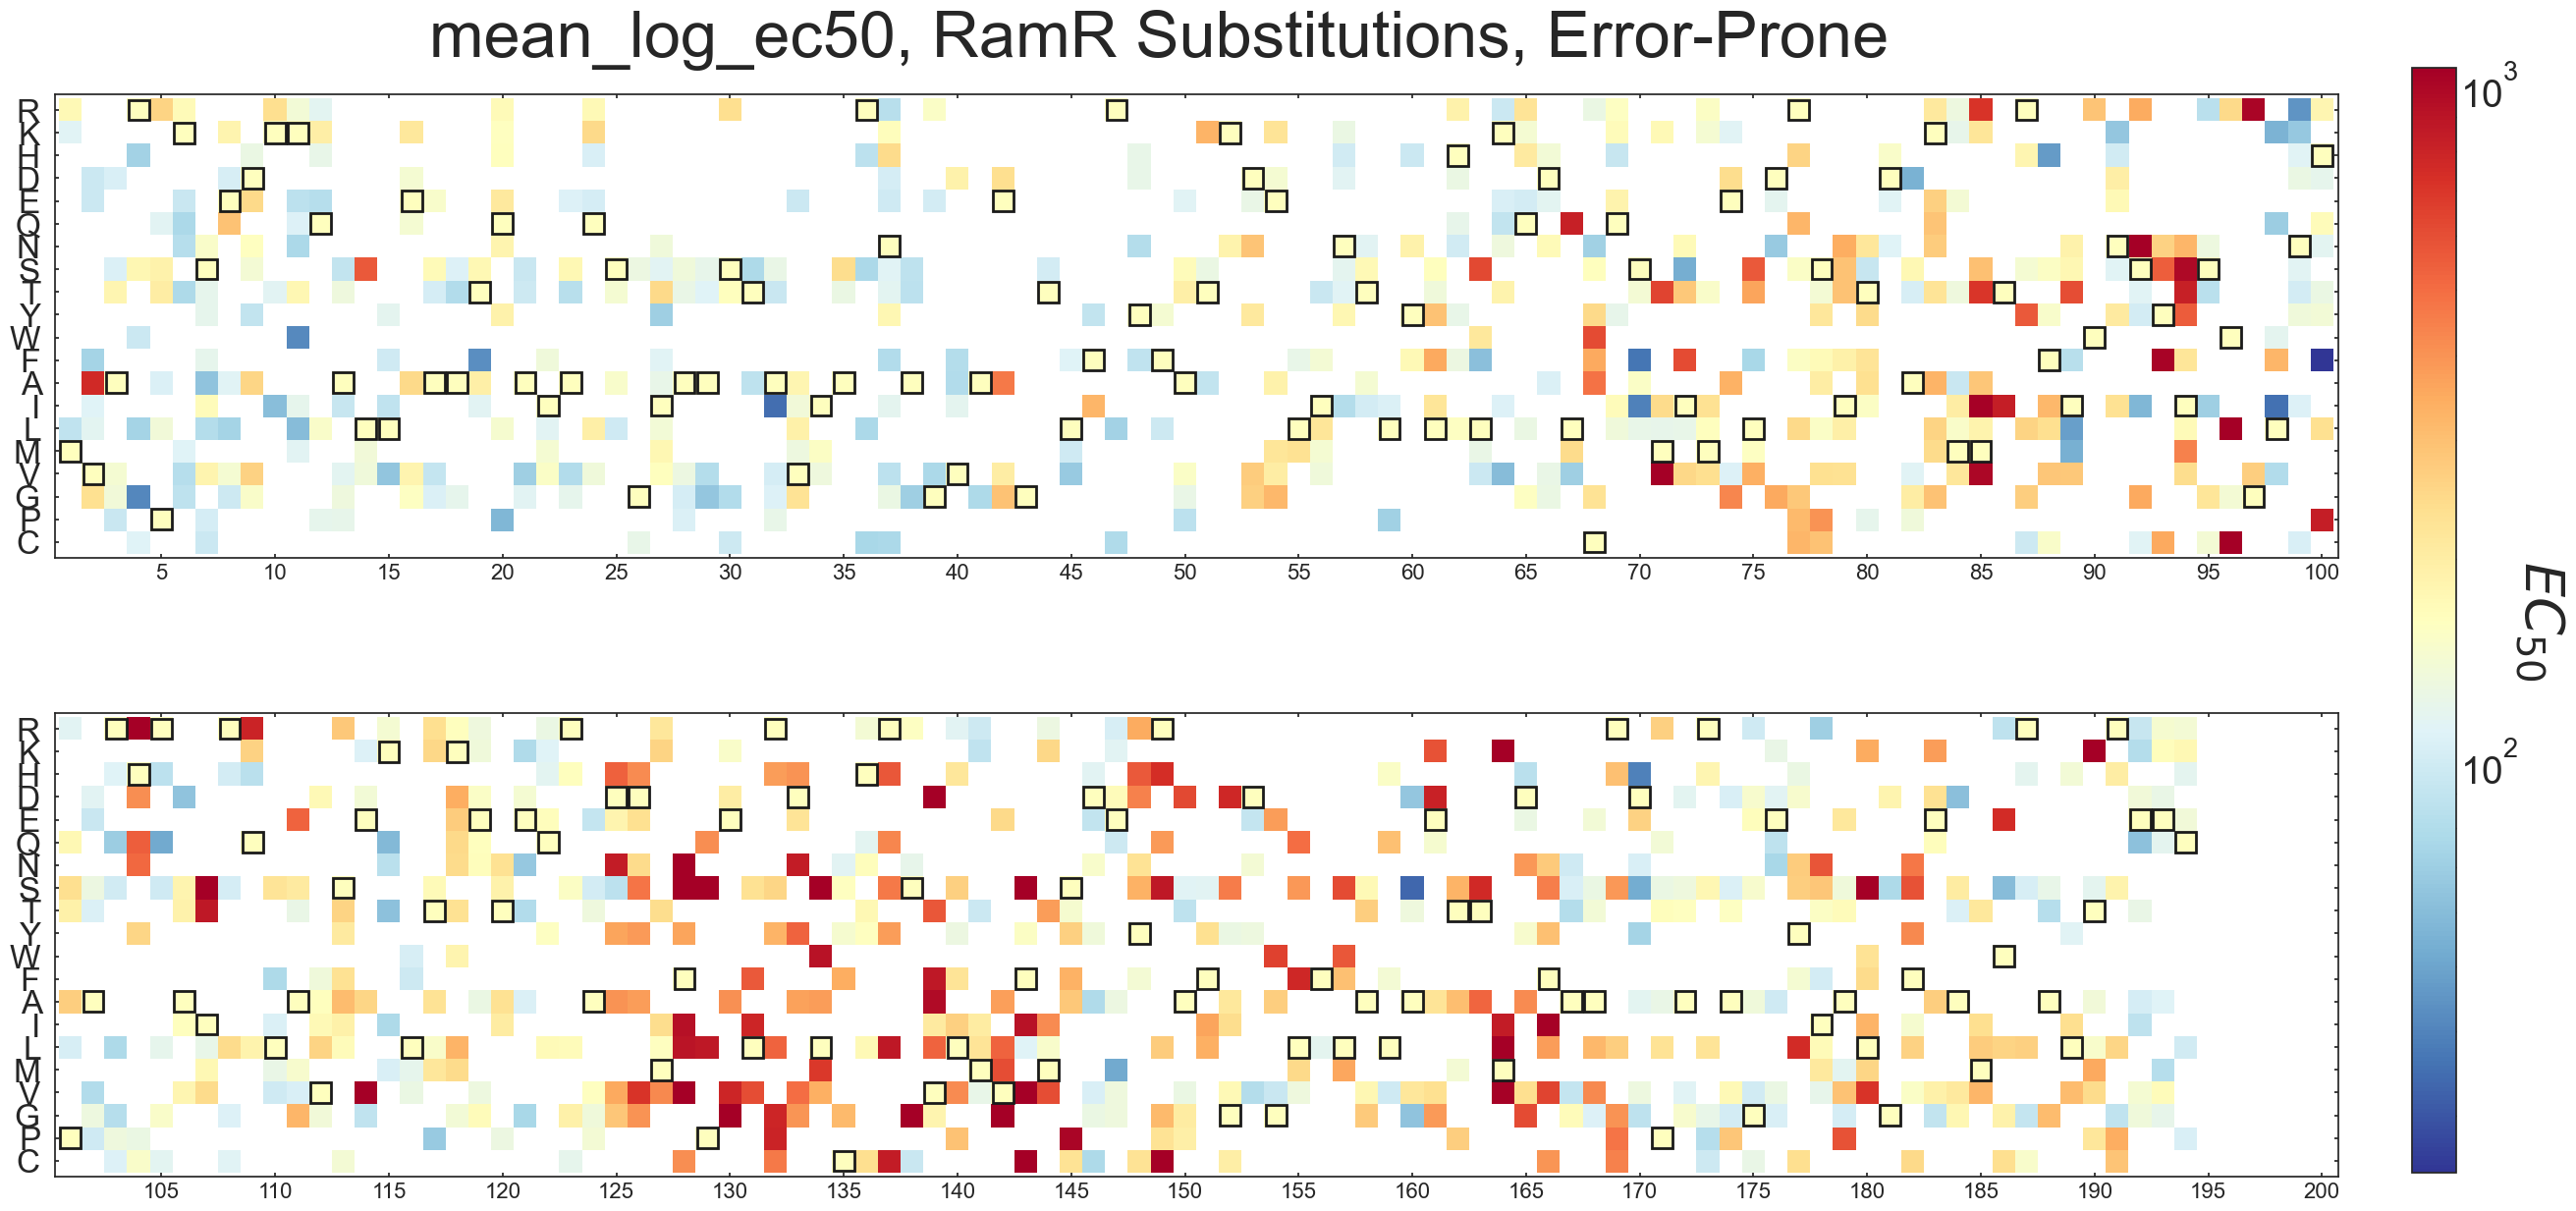

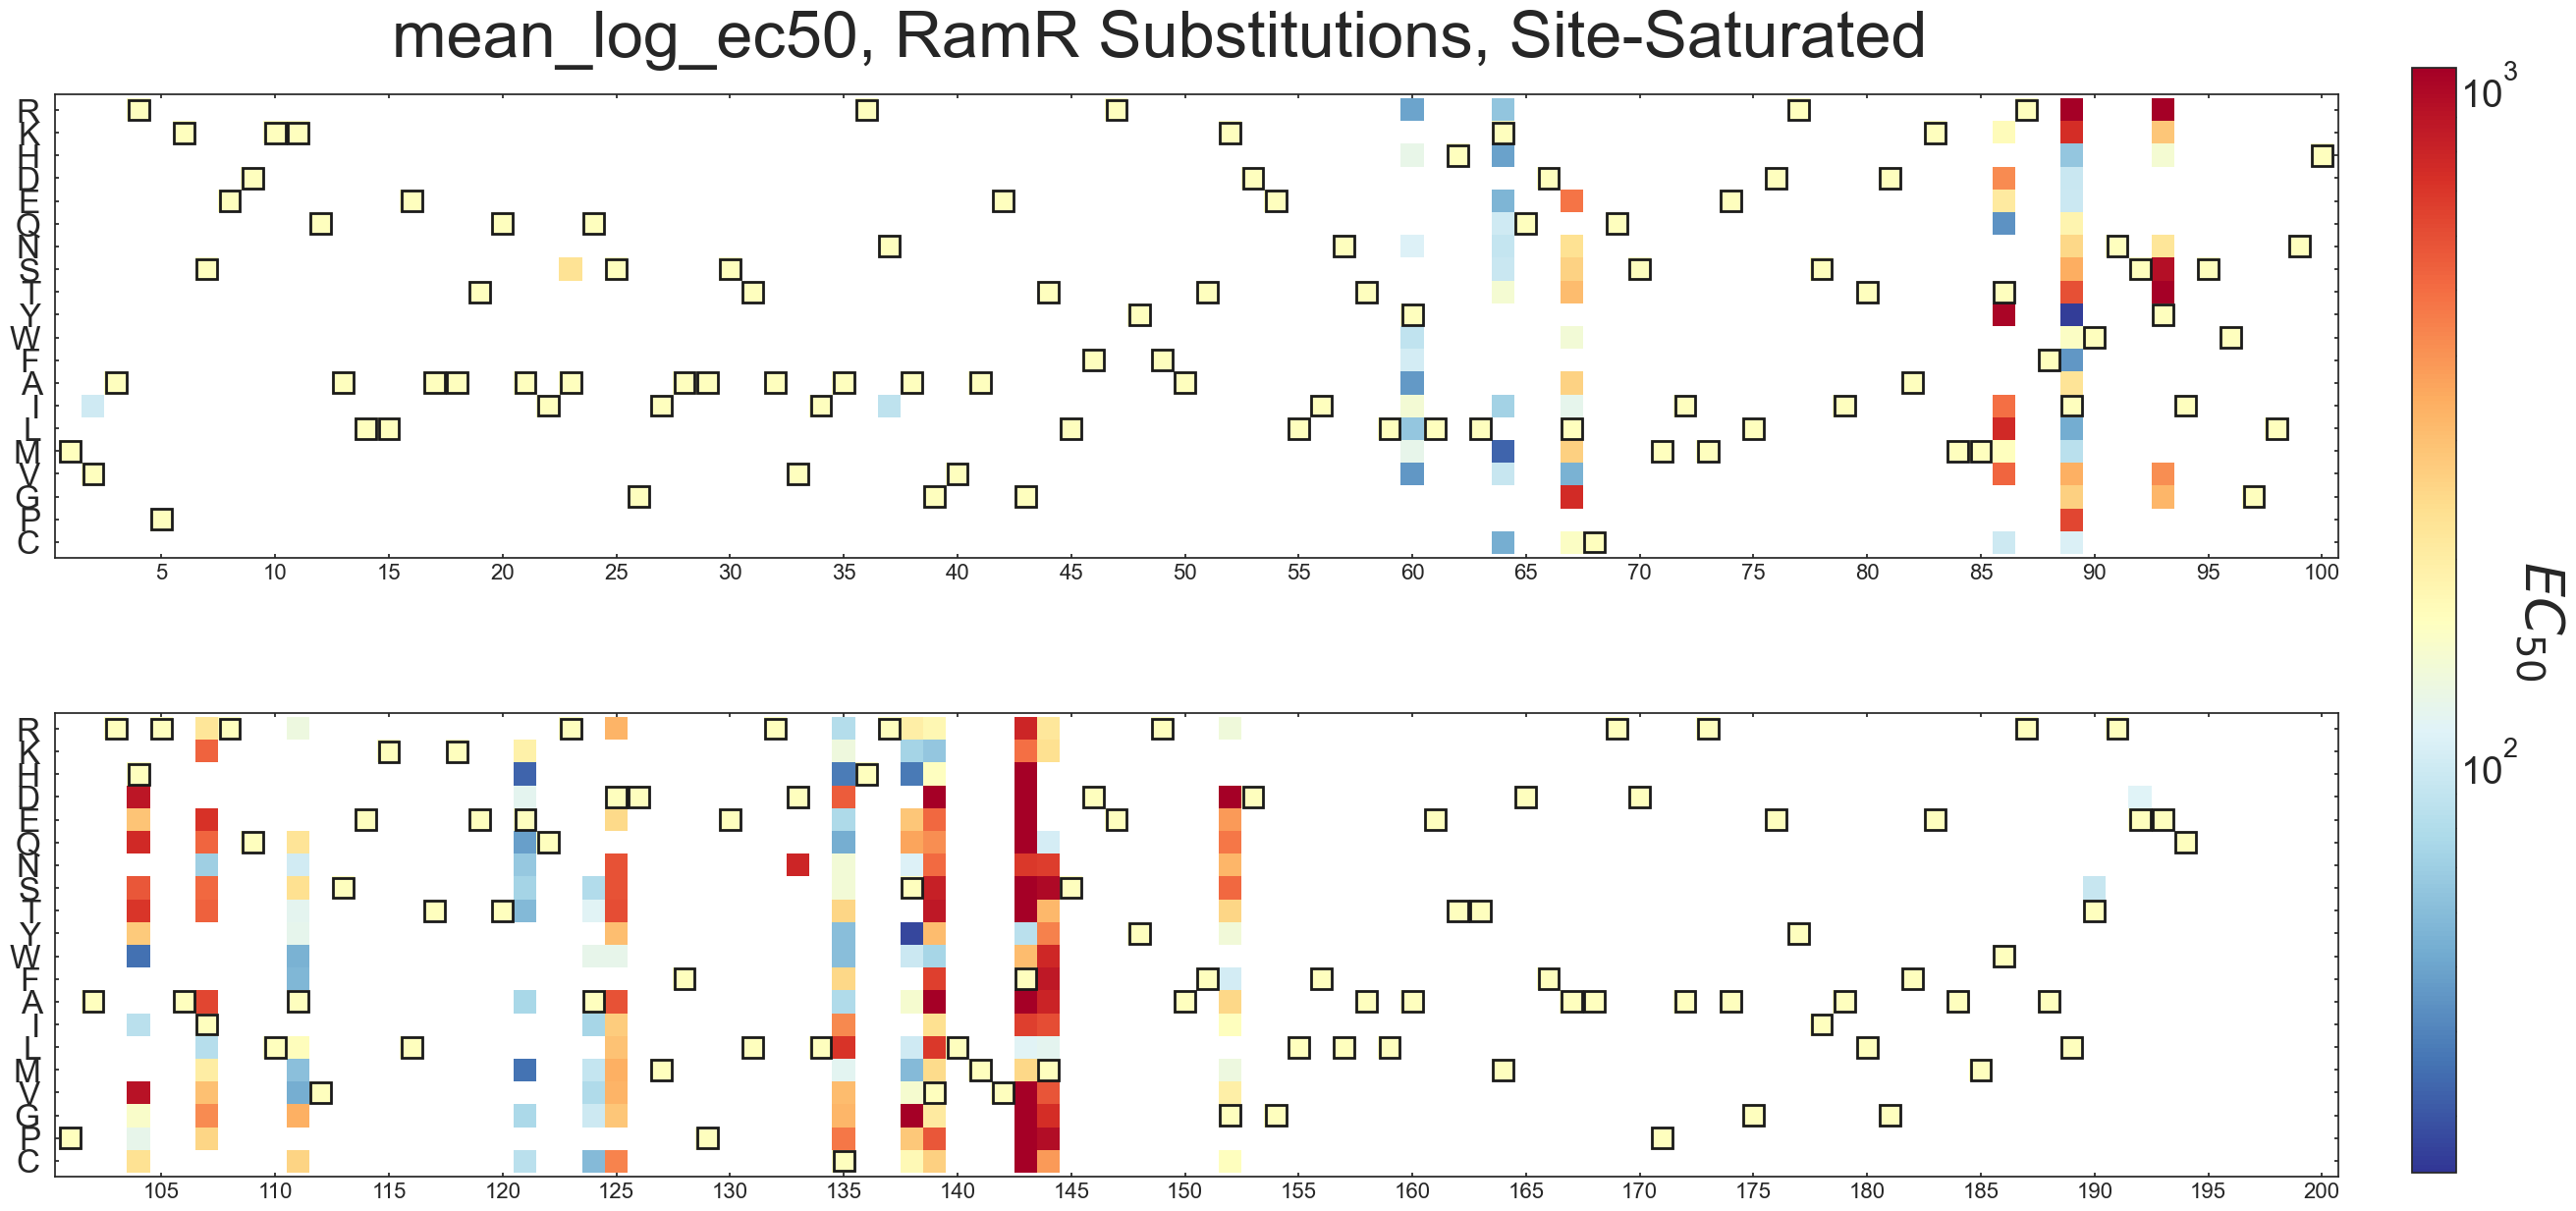

In [79]:
plt.rcParams["figure.figsize"] = [30,15]

for k, plot_arr in single_mean_log_ec50_dict.items():
    fig, axs = plt.subplots(2, 1)
    param_label = '$EC_{50}$'
    fig.suptitle(f'{plot_param}, RamR Substitutions' + f', {titles_dict[k]}', size=48, y=0.92)

    plot_arr = 10**(plot_arr)

    cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

    cmap = copy.copy(ec50_cmap)
    #cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
    cmap.set_under(color='white')
    cmap.set_bad(color='white')

    axis_cut_point = 101

    plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

    for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
        #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
        im = ax.imshow(arr.transpose(), norm=colors.LogNorm(vmin=vmin_ec50, vmax=vmax_ec50), cmap=cmap);
        #ax.set_axis_off();
        ax.grid(visible=False);
        if ax is axs[0]:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        else:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        ax.set_yticks([i for i in range(len(amino_codes))]);
        ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
        ax.set_yticklabels(ylabels) #, size=16);
        #ax.set_ylim(-0.5, 7.5);
        ax.tick_params(length=3);
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

        #for i, c in enumerate(arr):
        #    x_pos = i + 1
        #    for y_pos in np.where(c==10**missing_fill_value)[0]:
        #        draw_x_pos((x_pos, y_pos), ax)

    fig.colorbar(im, cax=cb_ax);

    # outline and draw X to mark wild-type 
    for i, c in enumerate(wild_type_aminos):
        y_pos = np.where(amino_codes==c)[0][0]
        if i < axis_cut_point - 1:
            x_pos = i + 1
            ax = axs[0]
        else:
            x_pos = i - axis_cut_point + 2
            ax = axs[1]
        outline_pos((x_pos, y_pos), ax)
        #draw_x_pos((x_pos, y_pos), ax)

    cb_ax.tick_params(axis='y', labelsize=28)
    cb_ax.set_ylabel(param_label, size=40, rotation=270, labelpad=35)
    cb_ax.set_ylim(vmin_ec50, vmax_ec50)

    axs[1].set_xlim(axs[0].get_xlim())

    os.chdir(notebook_directory)
    #fig.savefig(f"mean_log_ec50 heatmap.{k}.svg", dpi=None, bbox_inches="tight")

## G32-based ligand specificity

In [80]:
# Make array for heat-map plot of plot_param for each substitution, and for each ligand
err_cutoff = 0.5
single_specificity_dict = {}
for k in single_mutations_frame_dict:
    plot_param_dict = {}
    for lig in ligand_list:
        plot_param = f'GP_32_{lig}_spec'
        df_0 = single_mutations_frame_dict[k]
        df_0 = df_0[df_0[f'{plot_param}_err']<err_cutoff]

        plot_param_arr = []
        for i, c1 in enumerate(wild_type_aminos):
            pos = i+1
            log_g_ratio_sub_arr = []
            for c2 in amino_codes:
                if c2 == 'd':
                    mut = f'{c1}{pos}del'
                else:
                    mut = f'{c1}{pos}{c2}'
                df = df_0
                df = df[df.mutation==mut]

                if len(df)==0:
                    if c1 == c2:
                        wt_value = wild_type_params_dict[k][f'g32_spec_{lig}'][0]
                    else:
                        wt_value = missing_fill_value
                else:
                    wt_value = df.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]

                log_g_ratio_sub_arr.append(wt_value)
            plot_param_arr.append(log_g_ratio_sub_arr)
        plot_param_arr = np.array(plot_param_arr)
        print(plot_param_arr.shape)
        plot_param_dict[lig] = plot_param_arr
    single_specificity_dict[k] = plot_param_dict

(194, 20)
(194, 20)
(194, 20)
(194, 20)
(194, 20)
(194, 20)


In [81]:
min_max_list = []
for k in single_mutations_frame_dict:
    for lig in ligand_list:
        plot_param = f'GP_32_{lig}_spec'
        df = single_mutations_frame_dict[k]
        df = df[df[f'{plot_param}_err']<err_cutoff]
        min_max_list.append(df[plot_param].min())
        min_max_list.append(df[plot_param].max())
        print(single_mutations_frame_dict[k][plot_param].min(), single_mutations_frame_dict[k][plot_param].max())

-0.8747075 0.6675474999999997
-1.1083874999999996 0.6336774999999997
-0.5214000000000003 1.3822574999999997
-0.8634200000000001 0.8884500000000003
-1.5647600000000002 0.5162675000000005
-0.4706625 1.103055


In [82]:
plot_param_min = min(min_max_list)
plot_param_max = max(min_max_list)

wt_plot_param = 0

min_span = wt_plot_param - plot_param_min
max_span = plot_param_max - wt_plot_param

if min_span > max_span:
    vmin_plot_param = wt_plot_param - min_span
    vmax_plot_param = wt_plot_param + min_span
else:
    vmin_plot_param = wt_plot_param - max_span
    vmax_plot_param = wt_plot_param + max_span

vmin_plot_param, vmax_plot_param

(-1.5647600000000002, 1.5647600000000002)

In [83]:
plot_param_min, plot_param_max

(-1.5647600000000002, 1.3822574999999997)

In [84]:
plot_param_cmap = colormaps['RdYlBu_r']

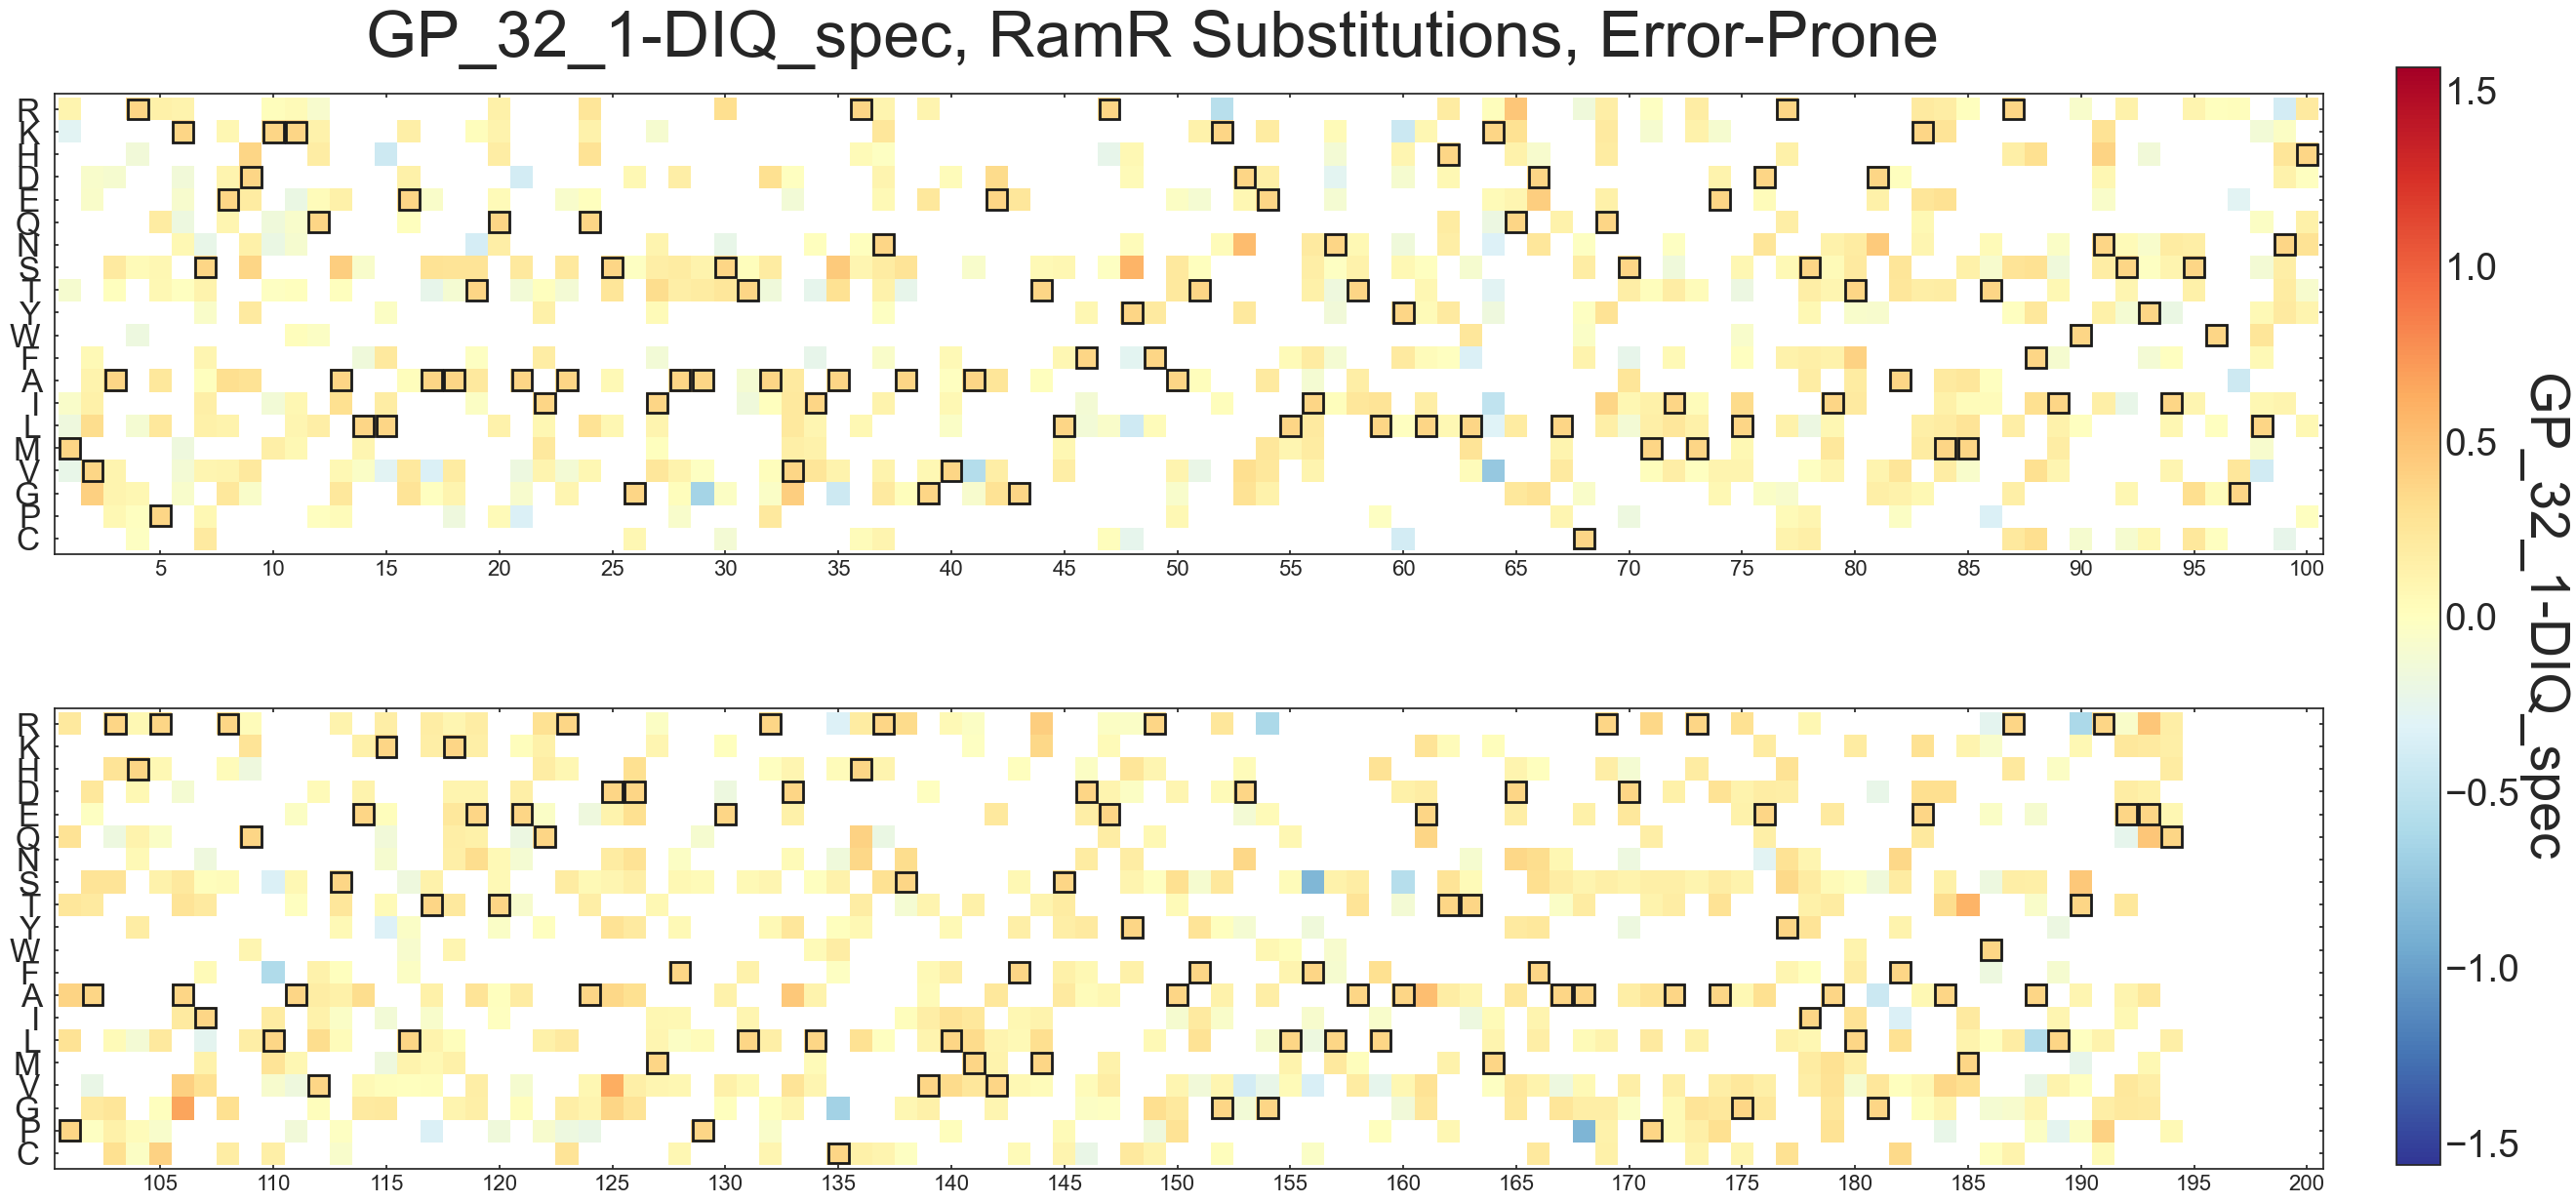

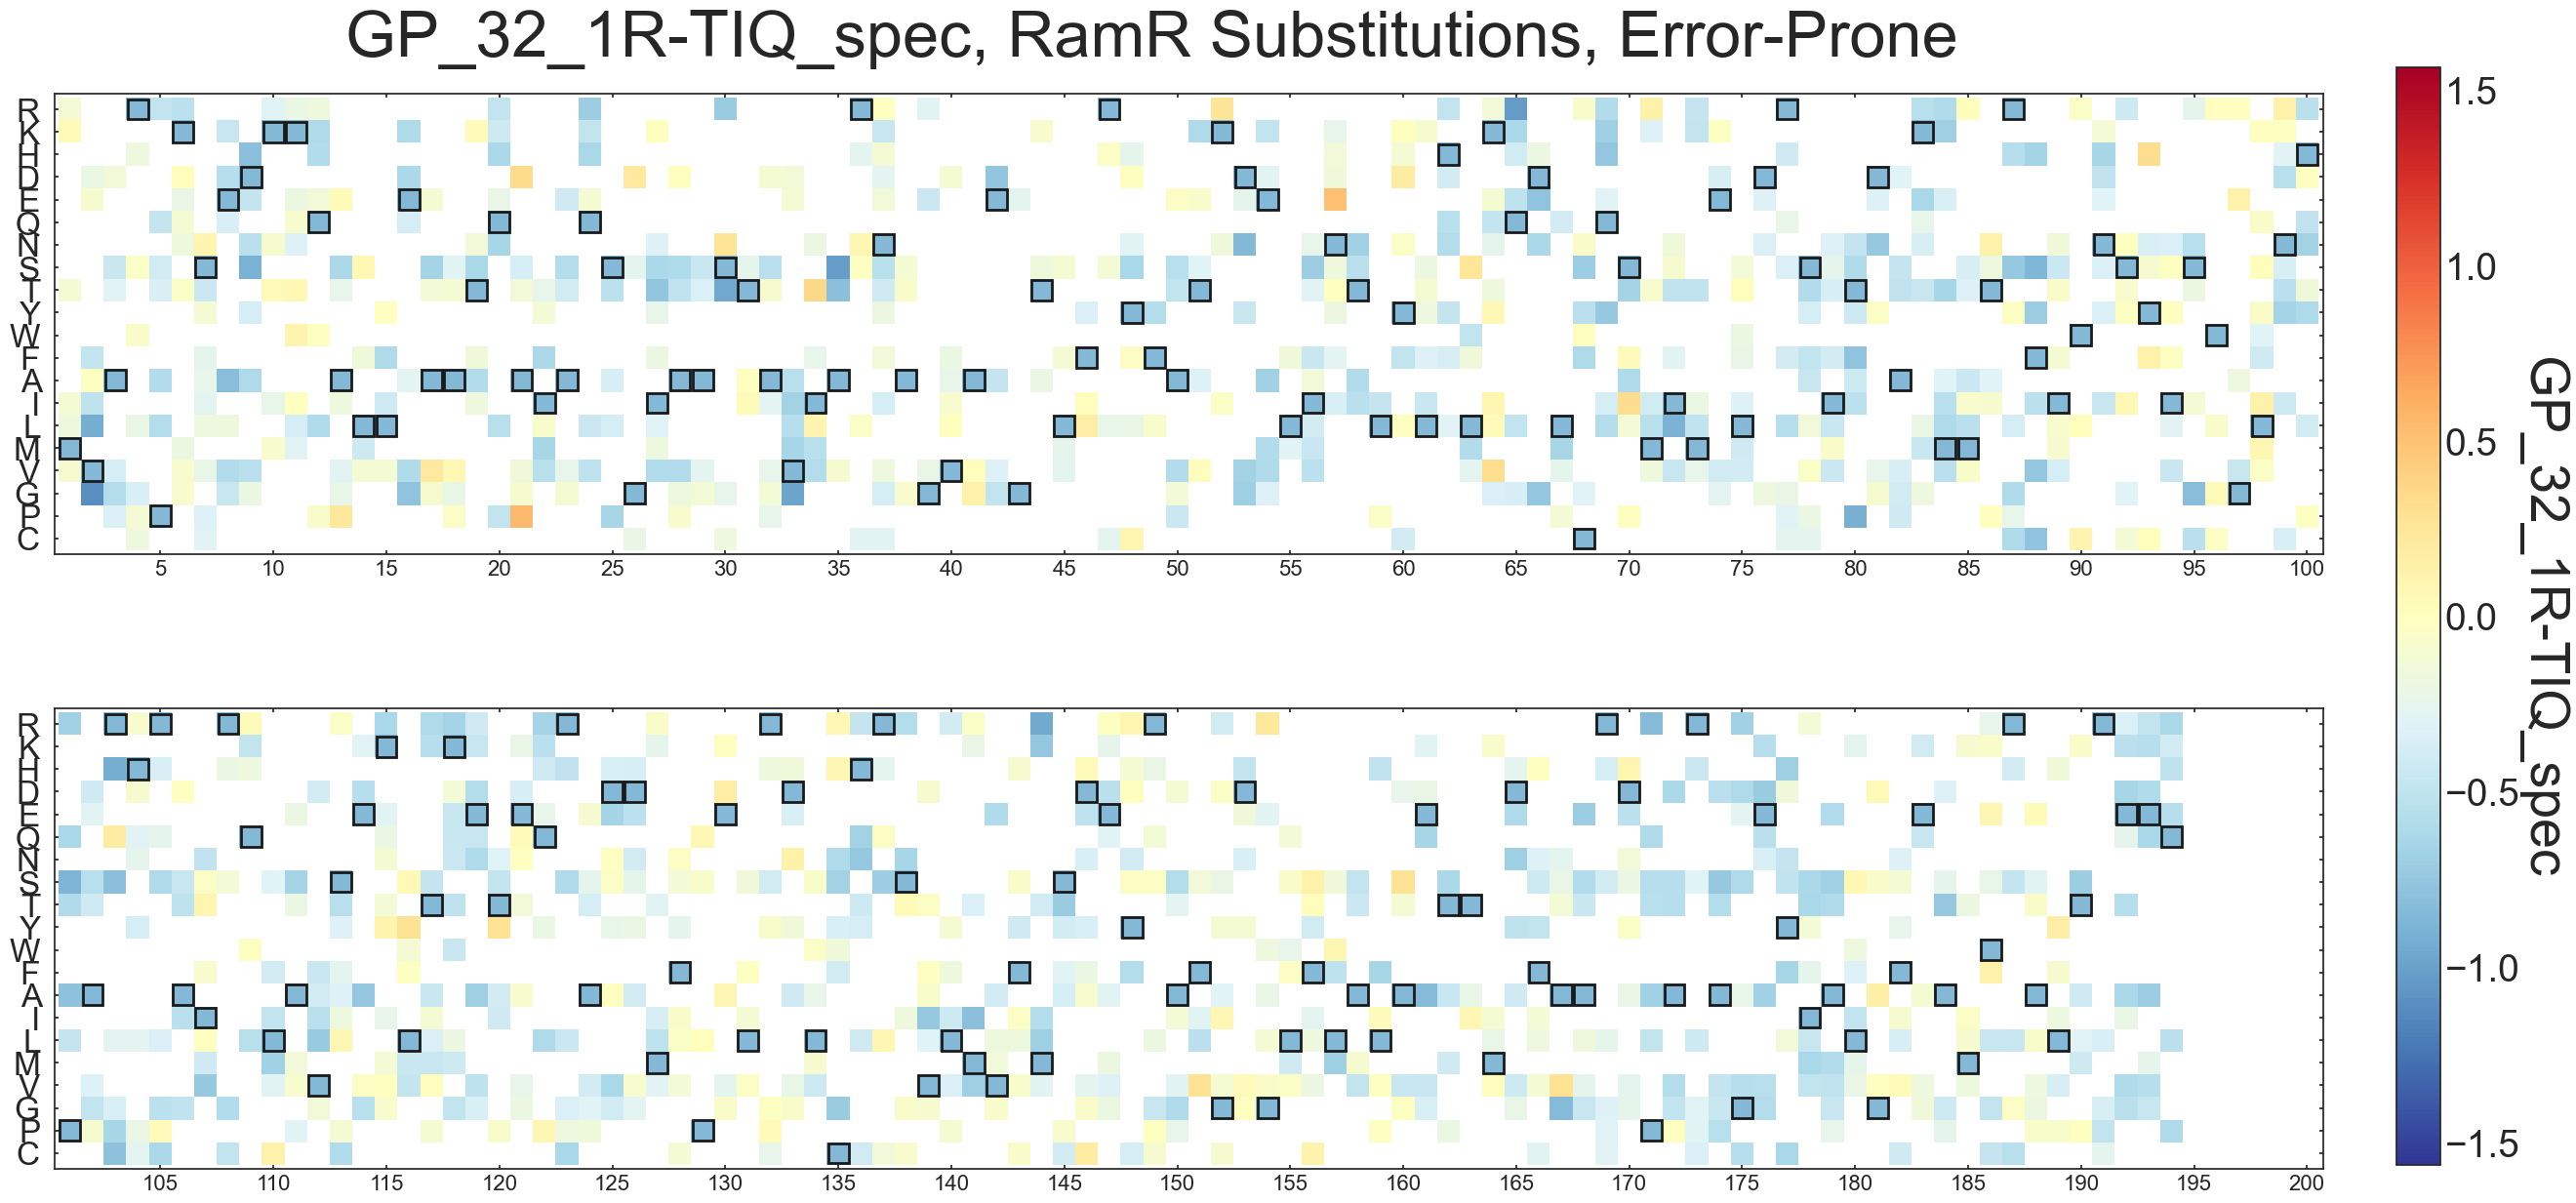

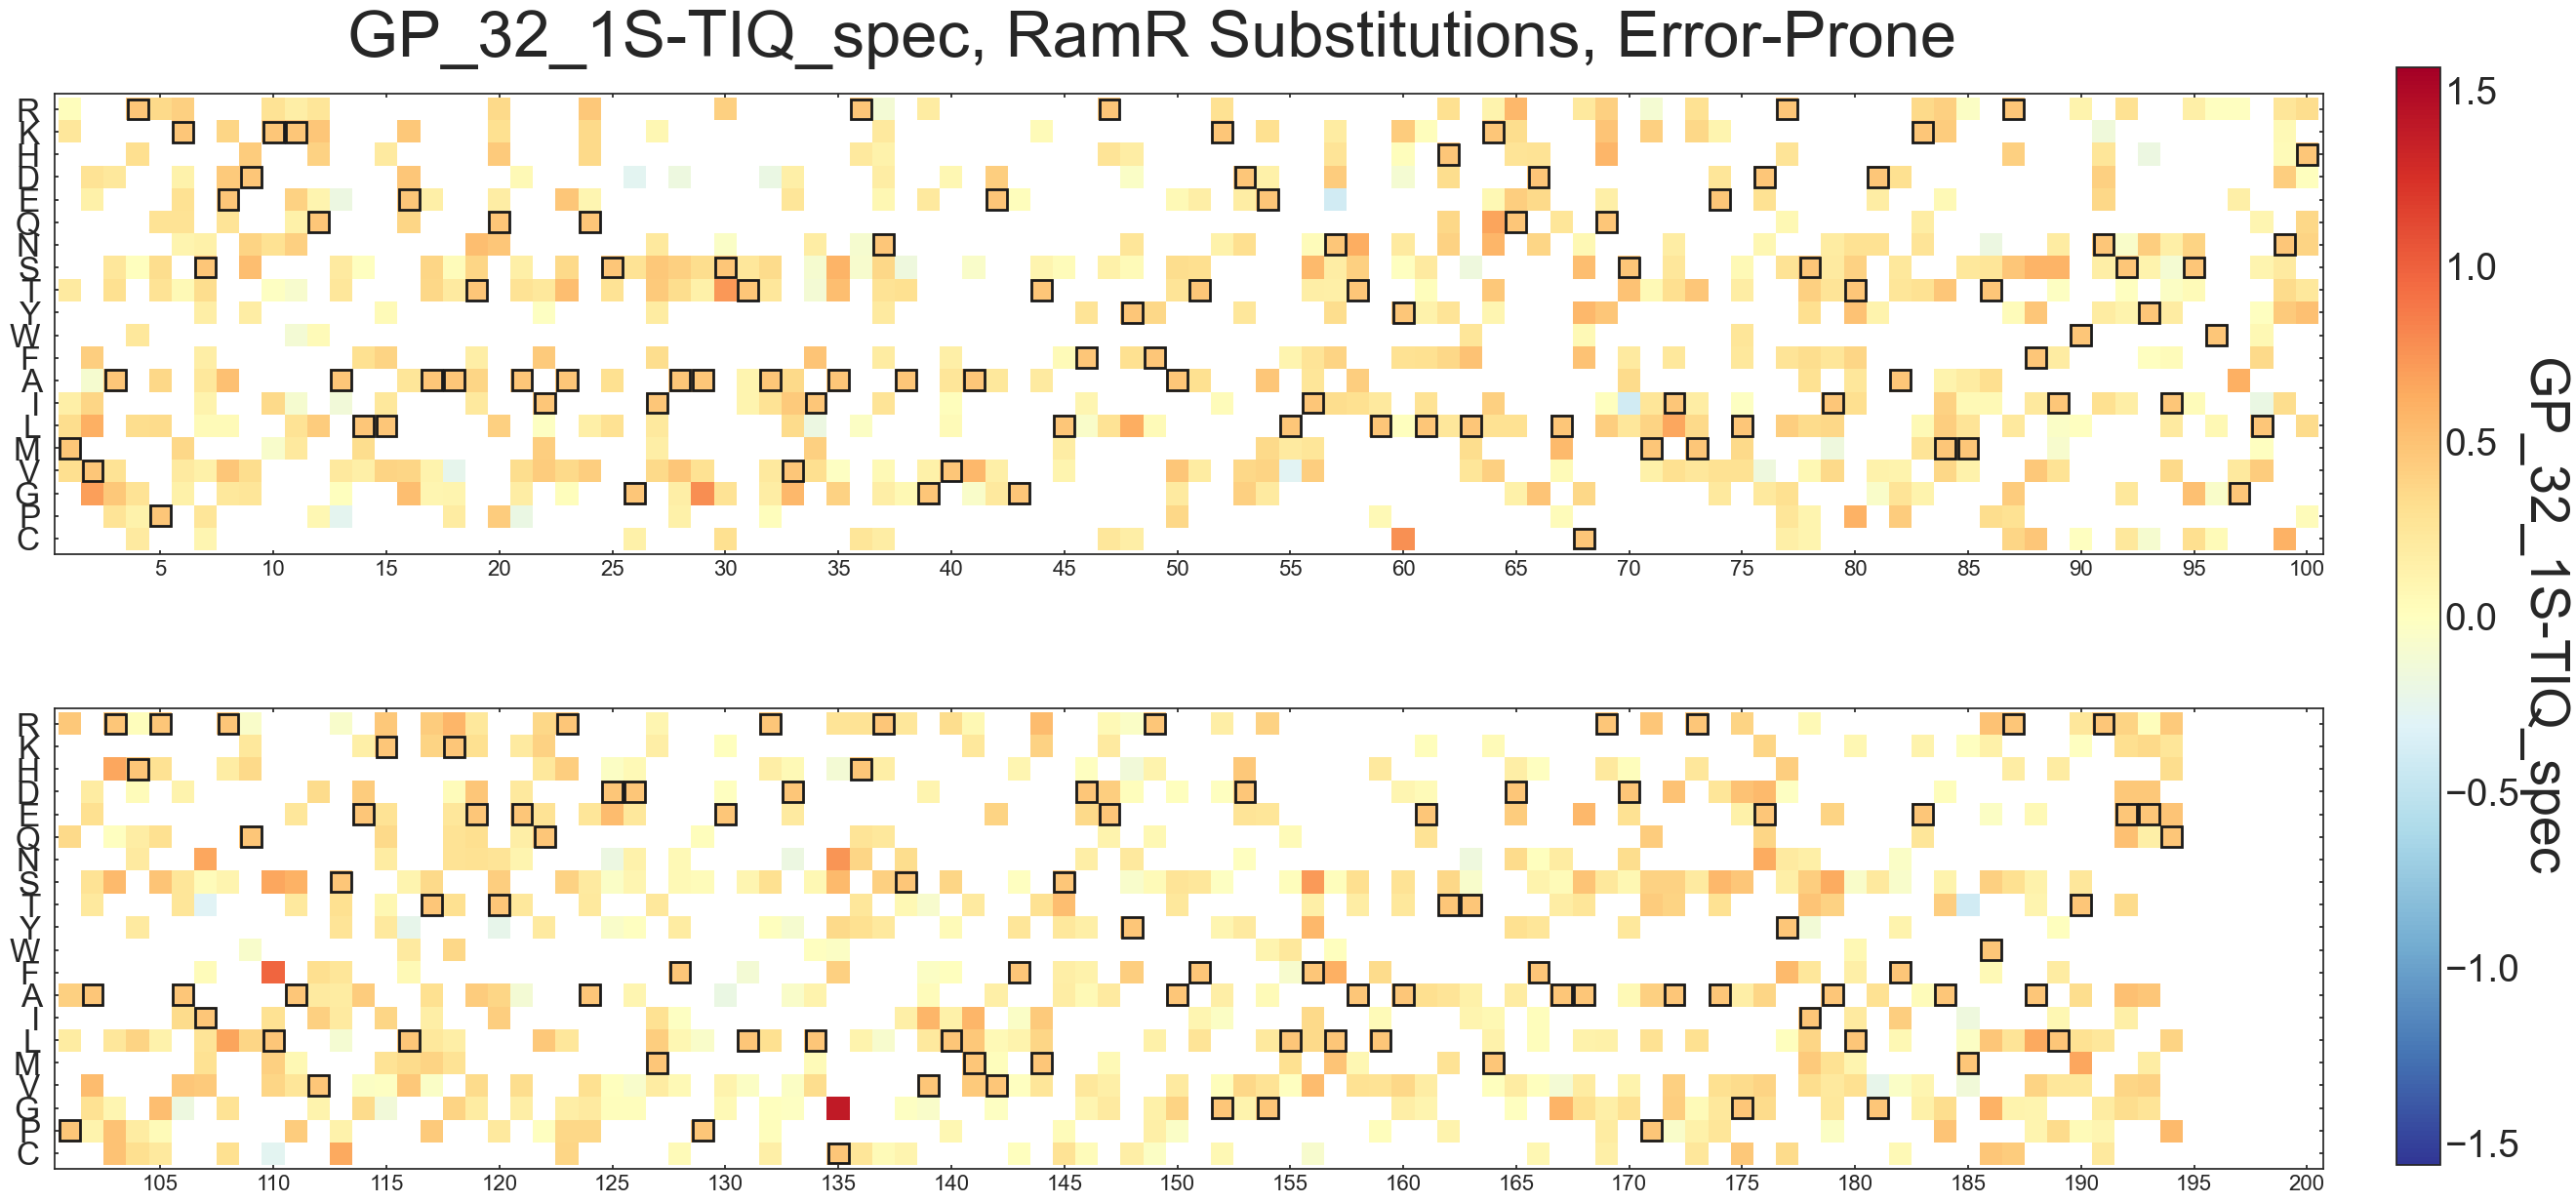

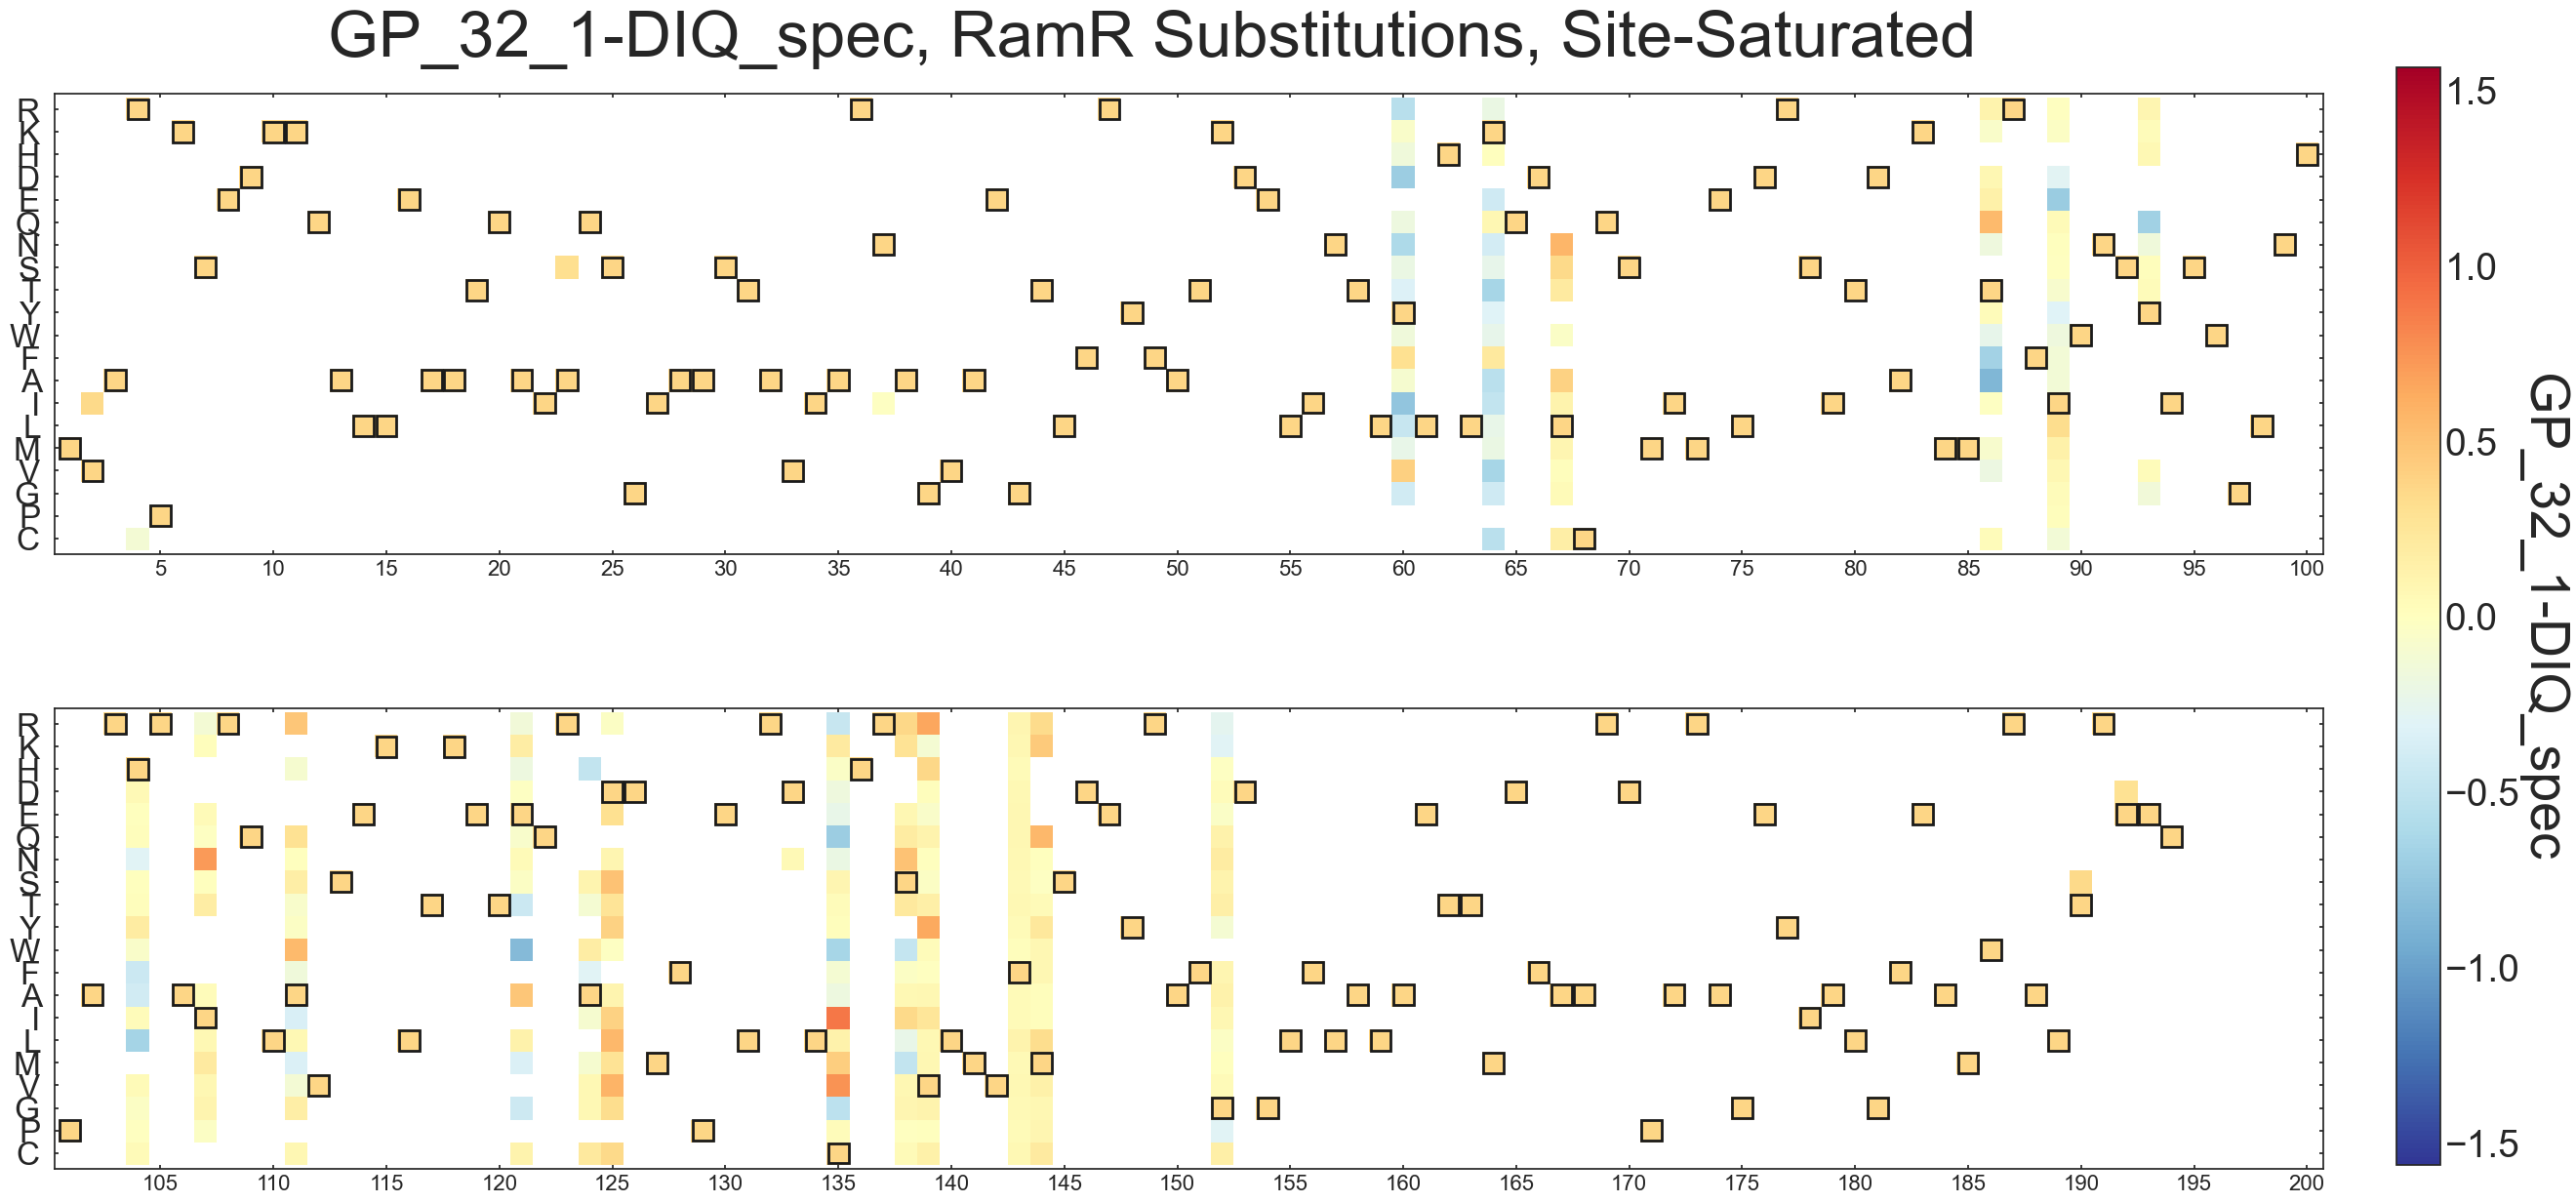

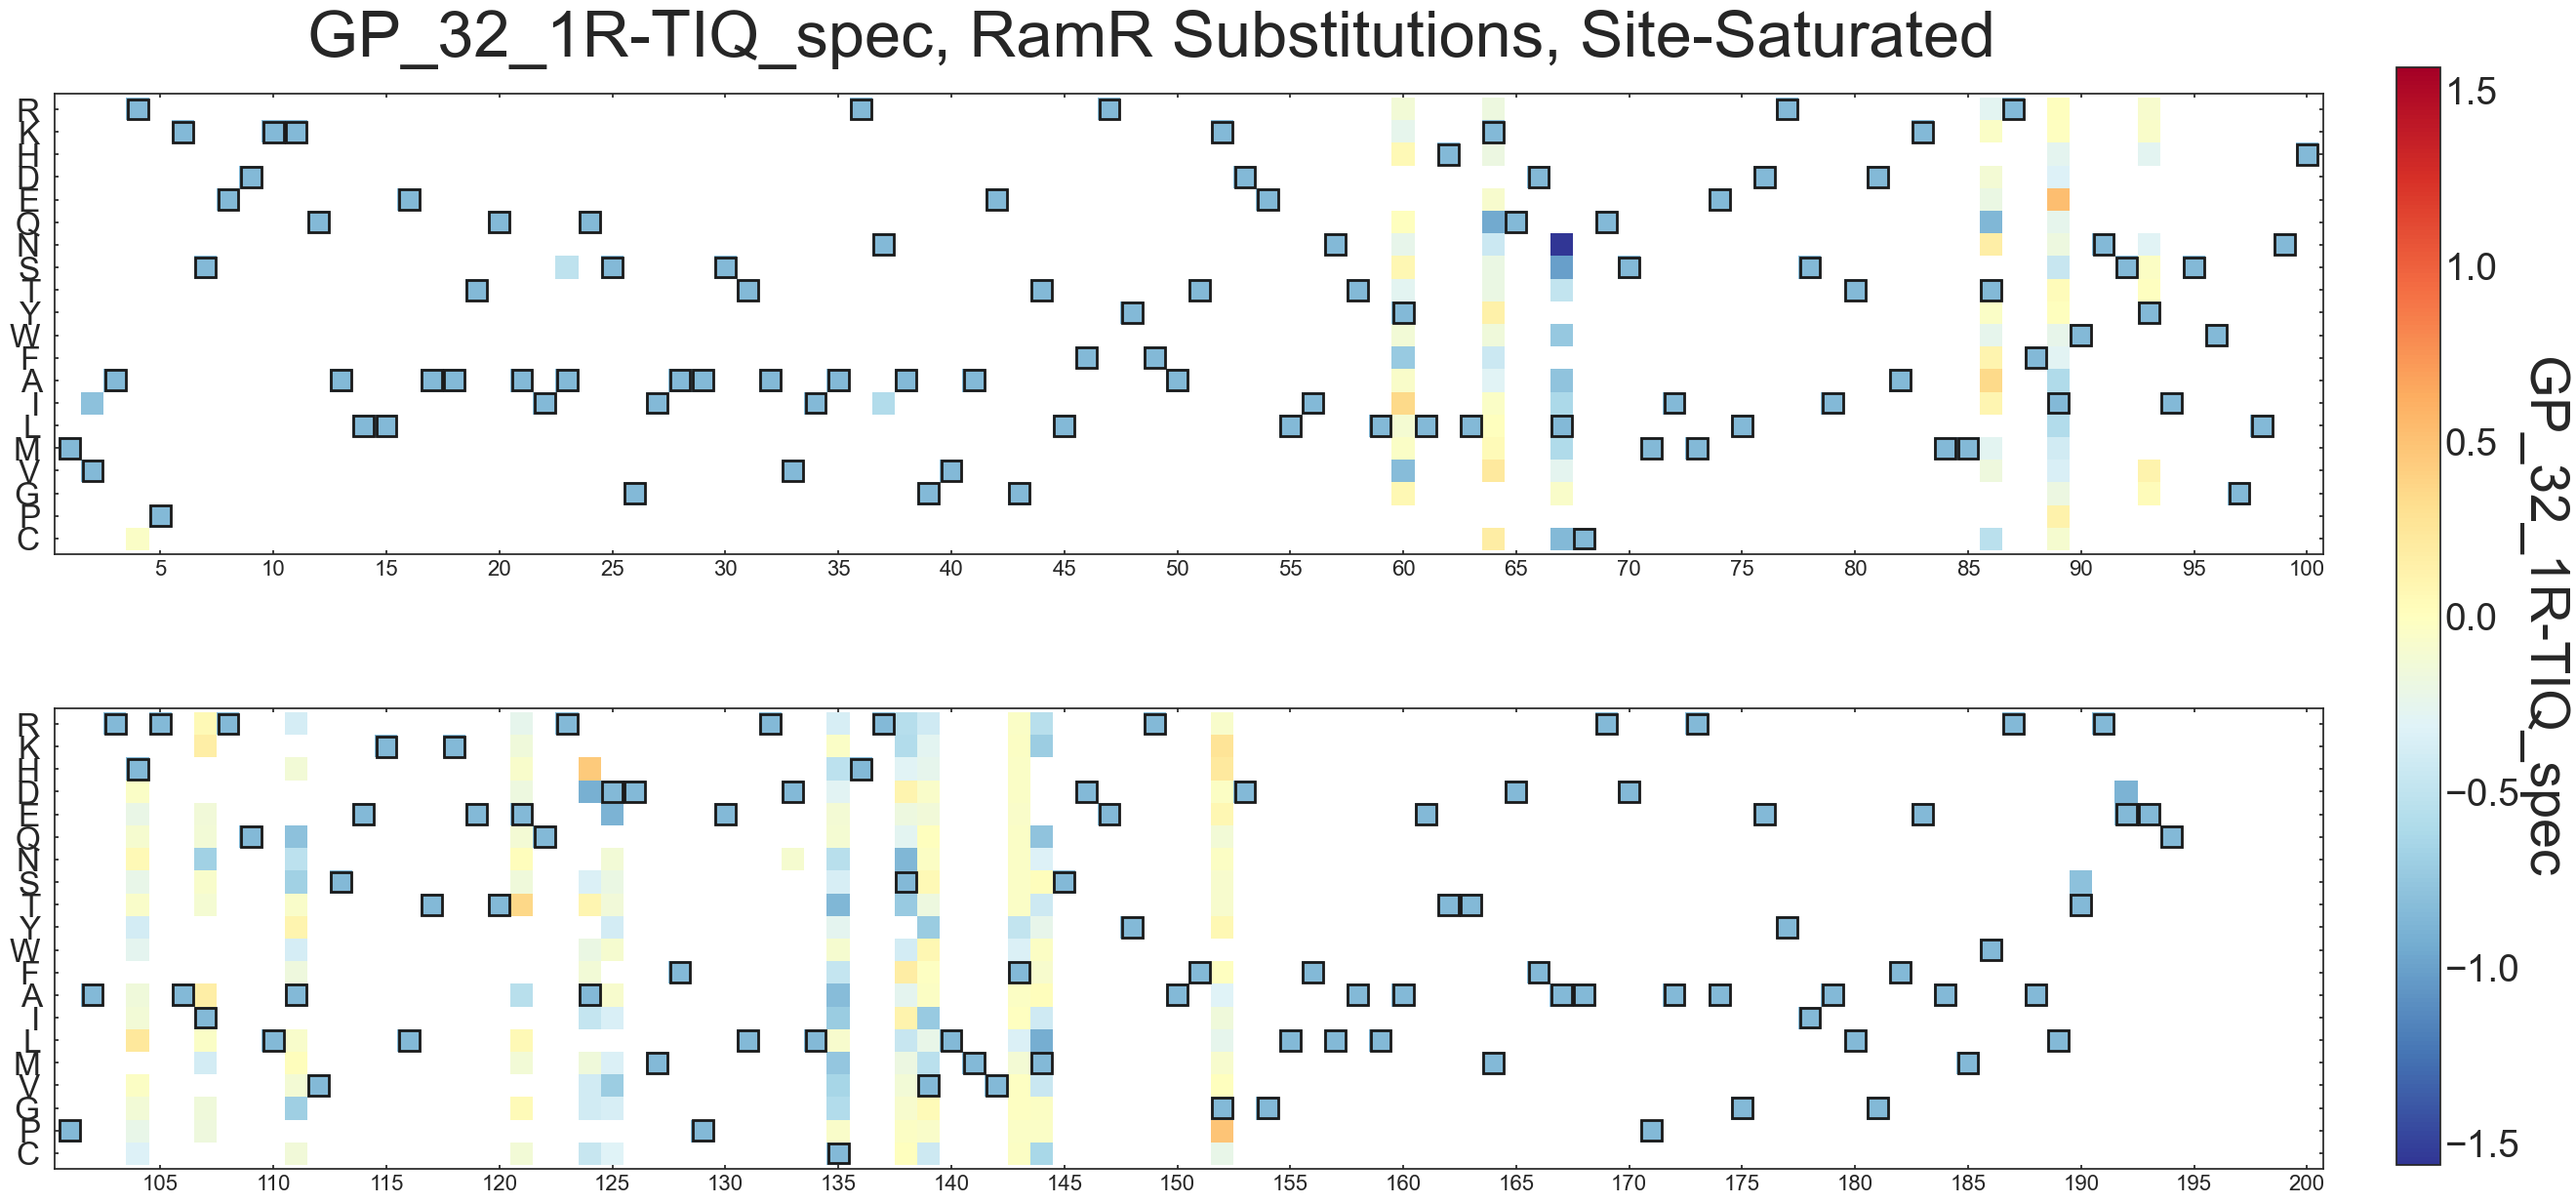

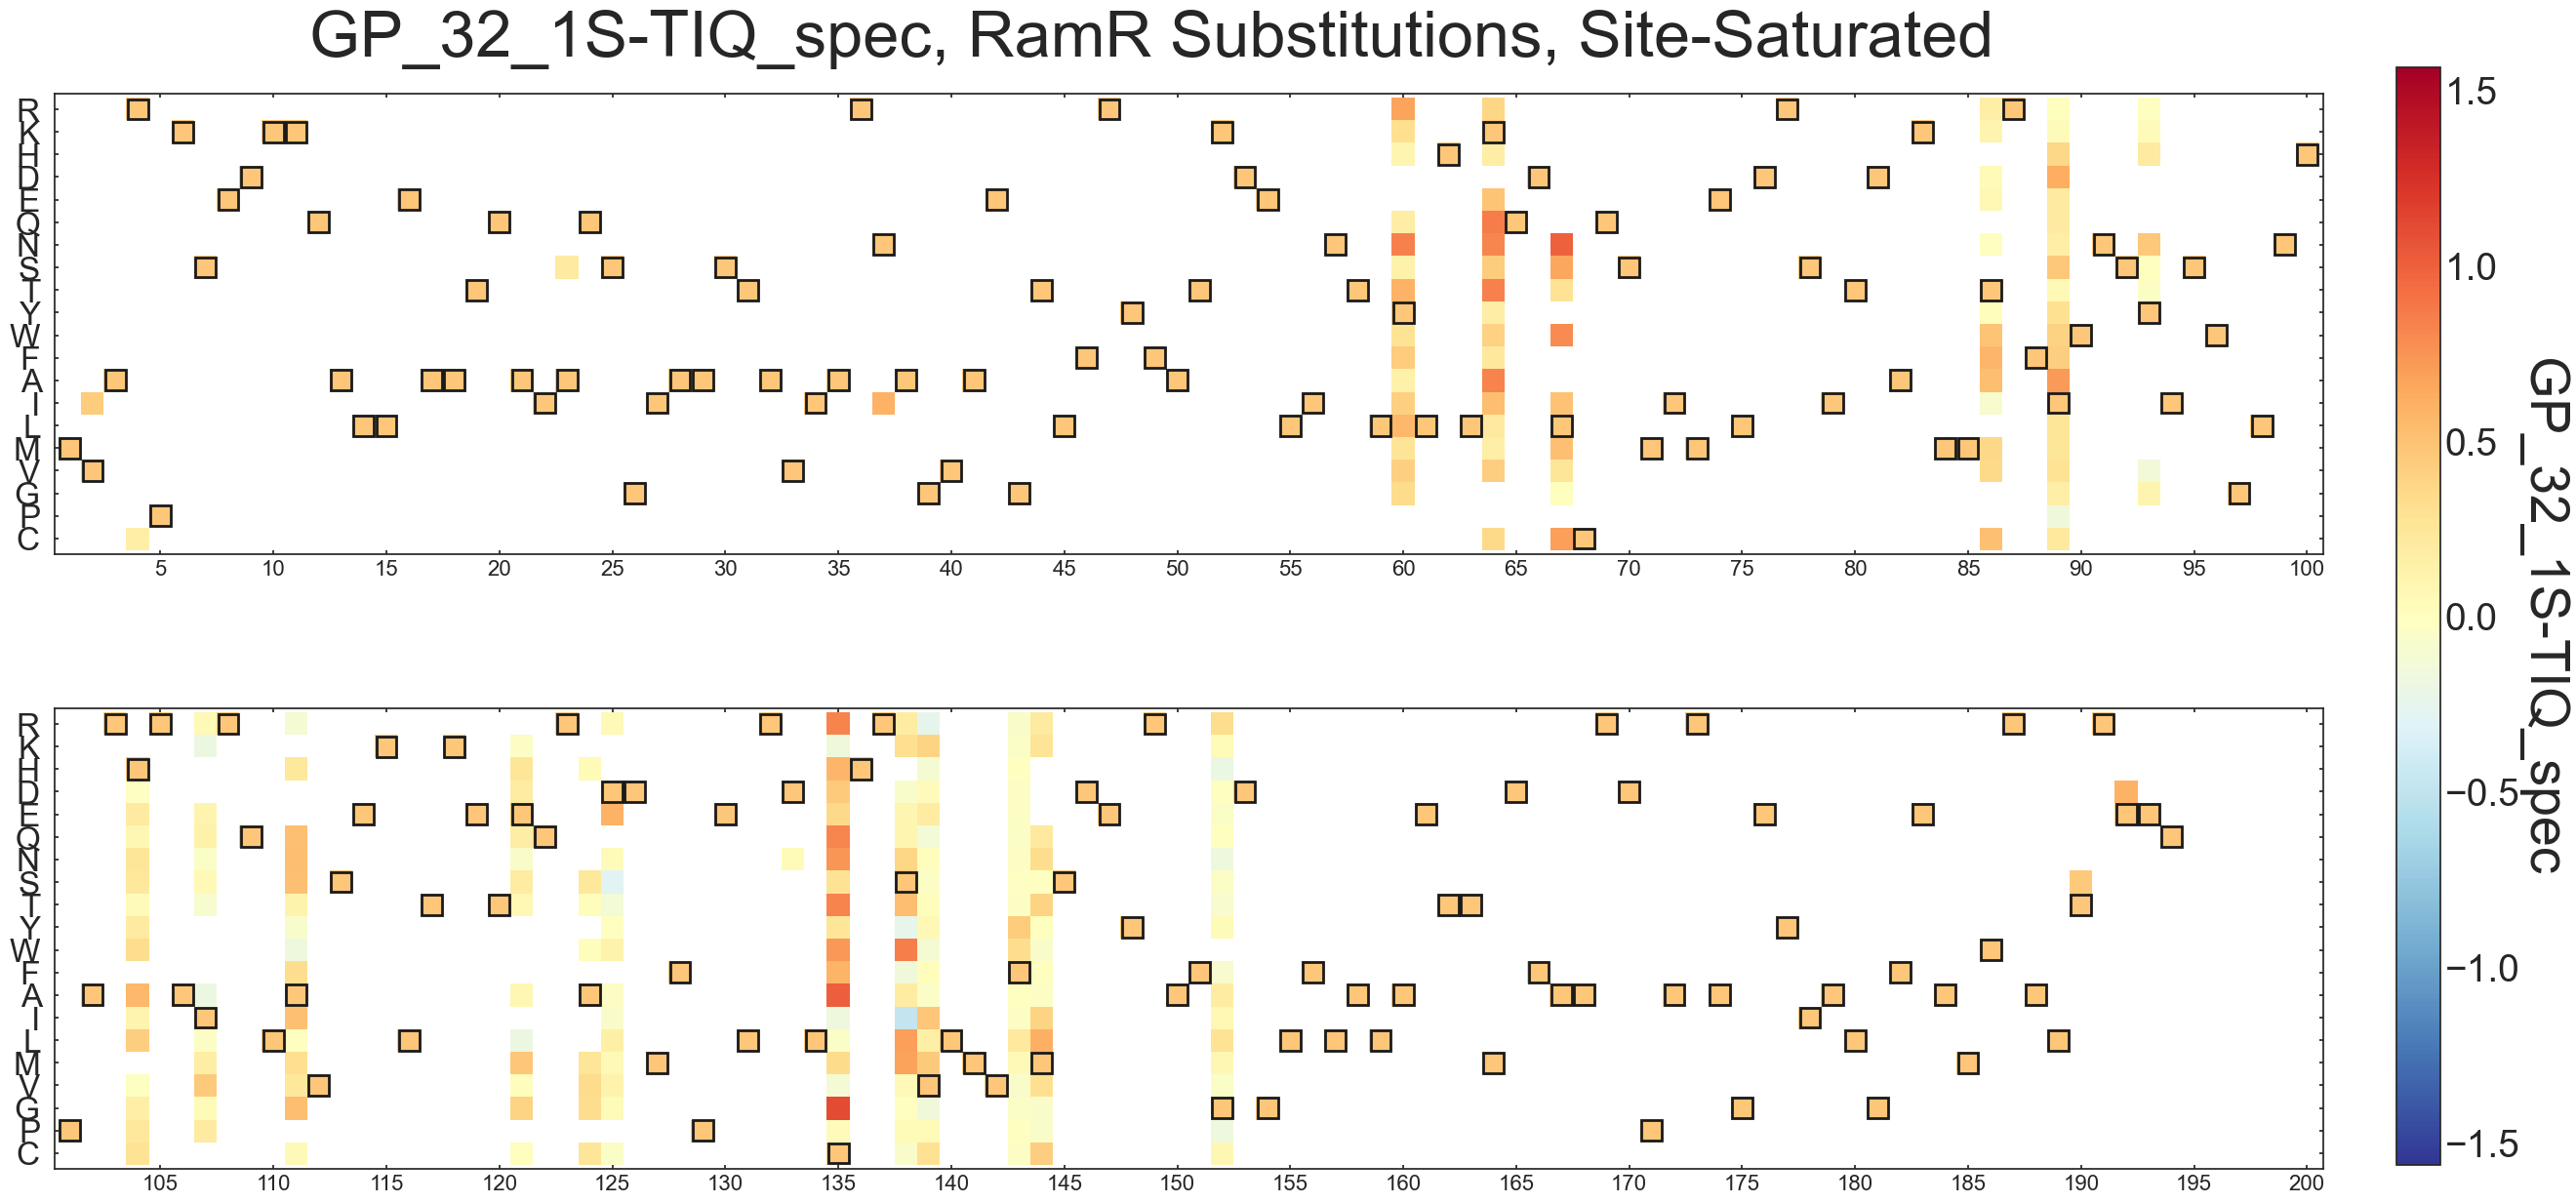

In [85]:
plt.rcParams["figure.figsize"] = [30,15]

for k in single_specificity_dict:
    for lig in ligand_list:
        plot_param = f'GP_32_{lig}_spec'

        fig, axs = plt.subplots(2, 1)
        param_label = plot_param
        fig.suptitle(f'{plot_param}, RamR Substitutions, {titles_dict[k]}', size=48, y=0.92)

        plot_arr = single_specificity_dict[k][lig]

        cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

        cmap = copy.copy(plot_param_cmap)
        #cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
        cmap.set_under(color='white')
        cmap.set_bad(color='white')

        axis_cut_point = 101

        plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

        for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
            #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
            im = ax.imshow(arr.transpose(), norm=colors.Normalize(vmin=vmin_plot_param, vmax=vmax_plot_param), cmap=cmap);
            #ax.set_axis_off();
            ax.grid(visible=False);
            if ax is axs[0]:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            else:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            ax.set_yticks([i for i in range(len(amino_codes))]);
            ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
            ax.set_yticklabels(ylabels) #, size=16);
            #ax.set_ylim(-0.5, 7.5);
            ax.tick_params(length=3);
            xlim = ax.get_xlim()
            ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
            ylim = ax.get_ylim()
            ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

            #for i, c in enumerate(arr):
            #    x_pos = i + 1
            #    for y_pos in np.where(c==10**missing_fill_value)[0]:
            #        draw_x_pos((x_pos, y_pos), ax)

        fig.colorbar(im, cax=cb_ax);

        # outline and draw X to mark wild-type 
        for i, c in enumerate(wild_type_aminos):
            y_pos = np.where(amino_codes==c)[0][0]
            if i < axis_cut_point - 1:
                x_pos = i + 1
                ax = axs[0]
            else:
                x_pos = i - axis_cut_point + 2
                ax = axs[1]
            outline_pos((x_pos, y_pos), ax)
            #draw_x_pos((x_pos, y_pos), ax)

        cb_ax.tick_params(axis='y', labelsize=28)
        cb_ax.set_ylabel(param_label, size=40, rotation=270, labelpad=35)

        axs[1].set_xlim(axs[0].get_xlim())

        os.chdir(notebook_directory)
        #fig.savefig(f"{plot_param} heatmap.{k}.svg", dpi=None, bbox_inches="tight")

## Dynamic range for each ligand

In [86]:
np.log10(5)

0.6989700043360189

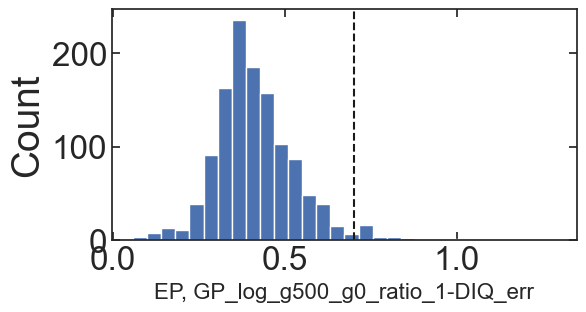

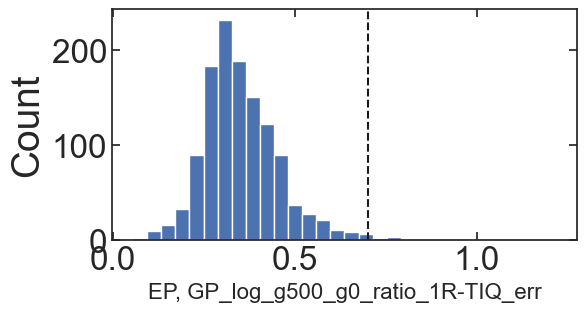

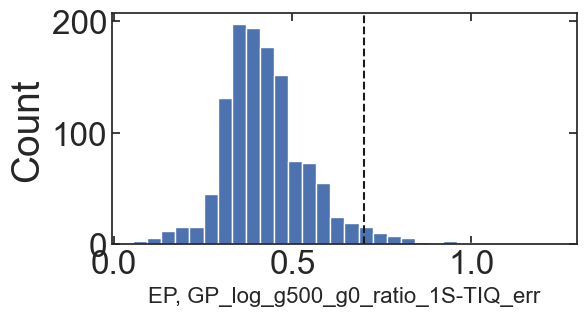

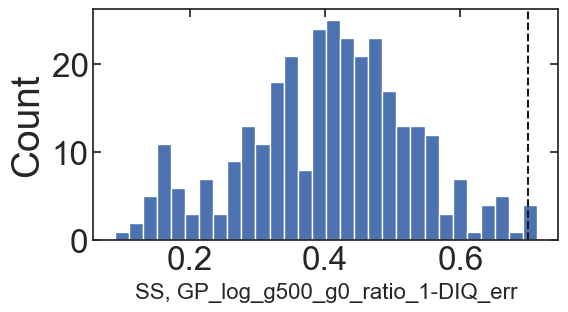

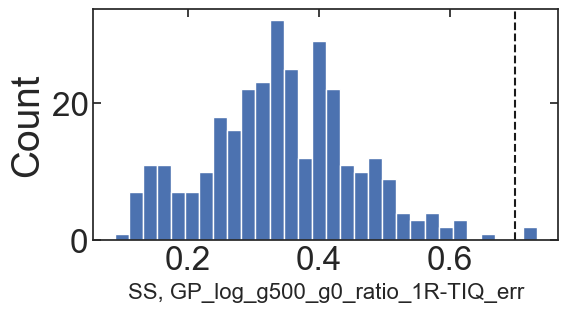

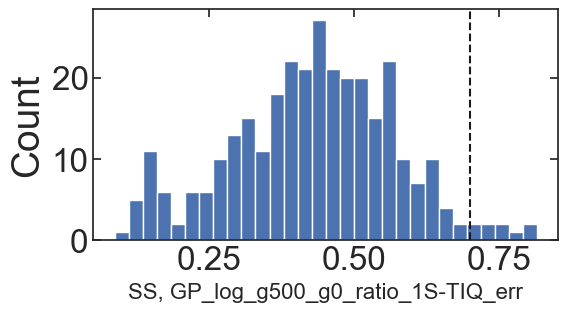

In [87]:
plt.rcParams["figure.figsize"] = [6, 3]

for k in single_mutations_frame_dict:
    for lig in ligand_list:
        fig, ax = plt.subplots()

        df = single_mutations_frame_dict[k]
        
        plot_param = f'GP_log_g500_g0_ratio_{lig}'
        x = df[f'{plot_param}_err']

        ax.hist(x, bins=30);

        ylim = ax.get_ylim()
        ax.set_ylim(ylim)
        ax.plot([0.7]*2, ylim, '--k')

        ax.set_xlabel(f'{k}, {plot_param}_err', size=16)
        ax.set_ylabel('Count');

In [88]:
# Make array for heat-map plot of plot_param for each substitution, and for each ligand
missing_fill_value = -5
err_cutoff = 0.7
single_dynamic_range_dict = {}
for k in single_mutations_frame_dict:
    plot_param_dict = {}
    for lig in ligand_list:
        plot_param = f'GP_log_g500_g0_ratio_{lig}'
        
        df_0 = single_mutations_frame_dict[k]
        df_0 = df_0[df_0[f'{plot_param}_err']<err_cutoff]

        plot_param_arr = []
        for i, c1 in enumerate(wild_type_aminos):
            pos = i+1
            log_g_ratio_sub_arr = []
            for c2 in amino_codes:
                mut = f'{c1}{pos}{c2}'
                df = df_0
                df = df[df.mutation==mut]

                if len(df)==0:
                    if c1 == c2:
                        wt_value = wild_type_params_dict[k][f'log_g500_g0_ratio_{lig}'][0]
                    else:
                        wt_value = missing_fill_value
                else:
                    wt_value = df.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]

                log_g_ratio_sub_arr.append(wt_value)
            plot_param_arr.append(log_g_ratio_sub_arr)
        plot_param_arr = np.array(plot_param_arr)
        print(plot_param_arr.shape)
        plot_param_dict[lig] = plot_param_arr
    single_dynamic_range_dict[k] = plot_param_dict

(194, 20)
(194, 20)
(194, 20)
(194, 20)
(194, 20)
(194, 20)


In [89]:
min_max_list = []
for k in single_mutations_frame_dict:
    for lig in ligand_list:
        plot_param = f'GP_log_g500_g0_ratio_{lig}'
        df = single_mutations_frame_dict[k]
        df = df[df[f'{plot_param}_err']<err_cutoff]
        
        min_max_list.append(df[plot_param].min())
        min_max_list.append(df[plot_param].max())
        print(single_mutations_frame_dict[k][plot_param].min(), single_mutations_frame_dict[k][plot_param].max())

-0.480890650711 3.75326564
-0.01454252142525 3.663551755
-0.0278628107745 3.839958325
-0.132120472273 3.6928835045
0.1229390514105 3.57932213
0.0149131017604999 3.53235469


In [90]:
plot_param_min = min(min_max_list)
plot_param_max = max(min_max_list)


vmin_plot_param = plot_param_min
vmax_plot_param = plot_param_max

vmin_plot_param, vmax_plot_param

(-0.480890650711, 3.839958325)

In [91]:
plot_param_cmap = colormaps['plasma']

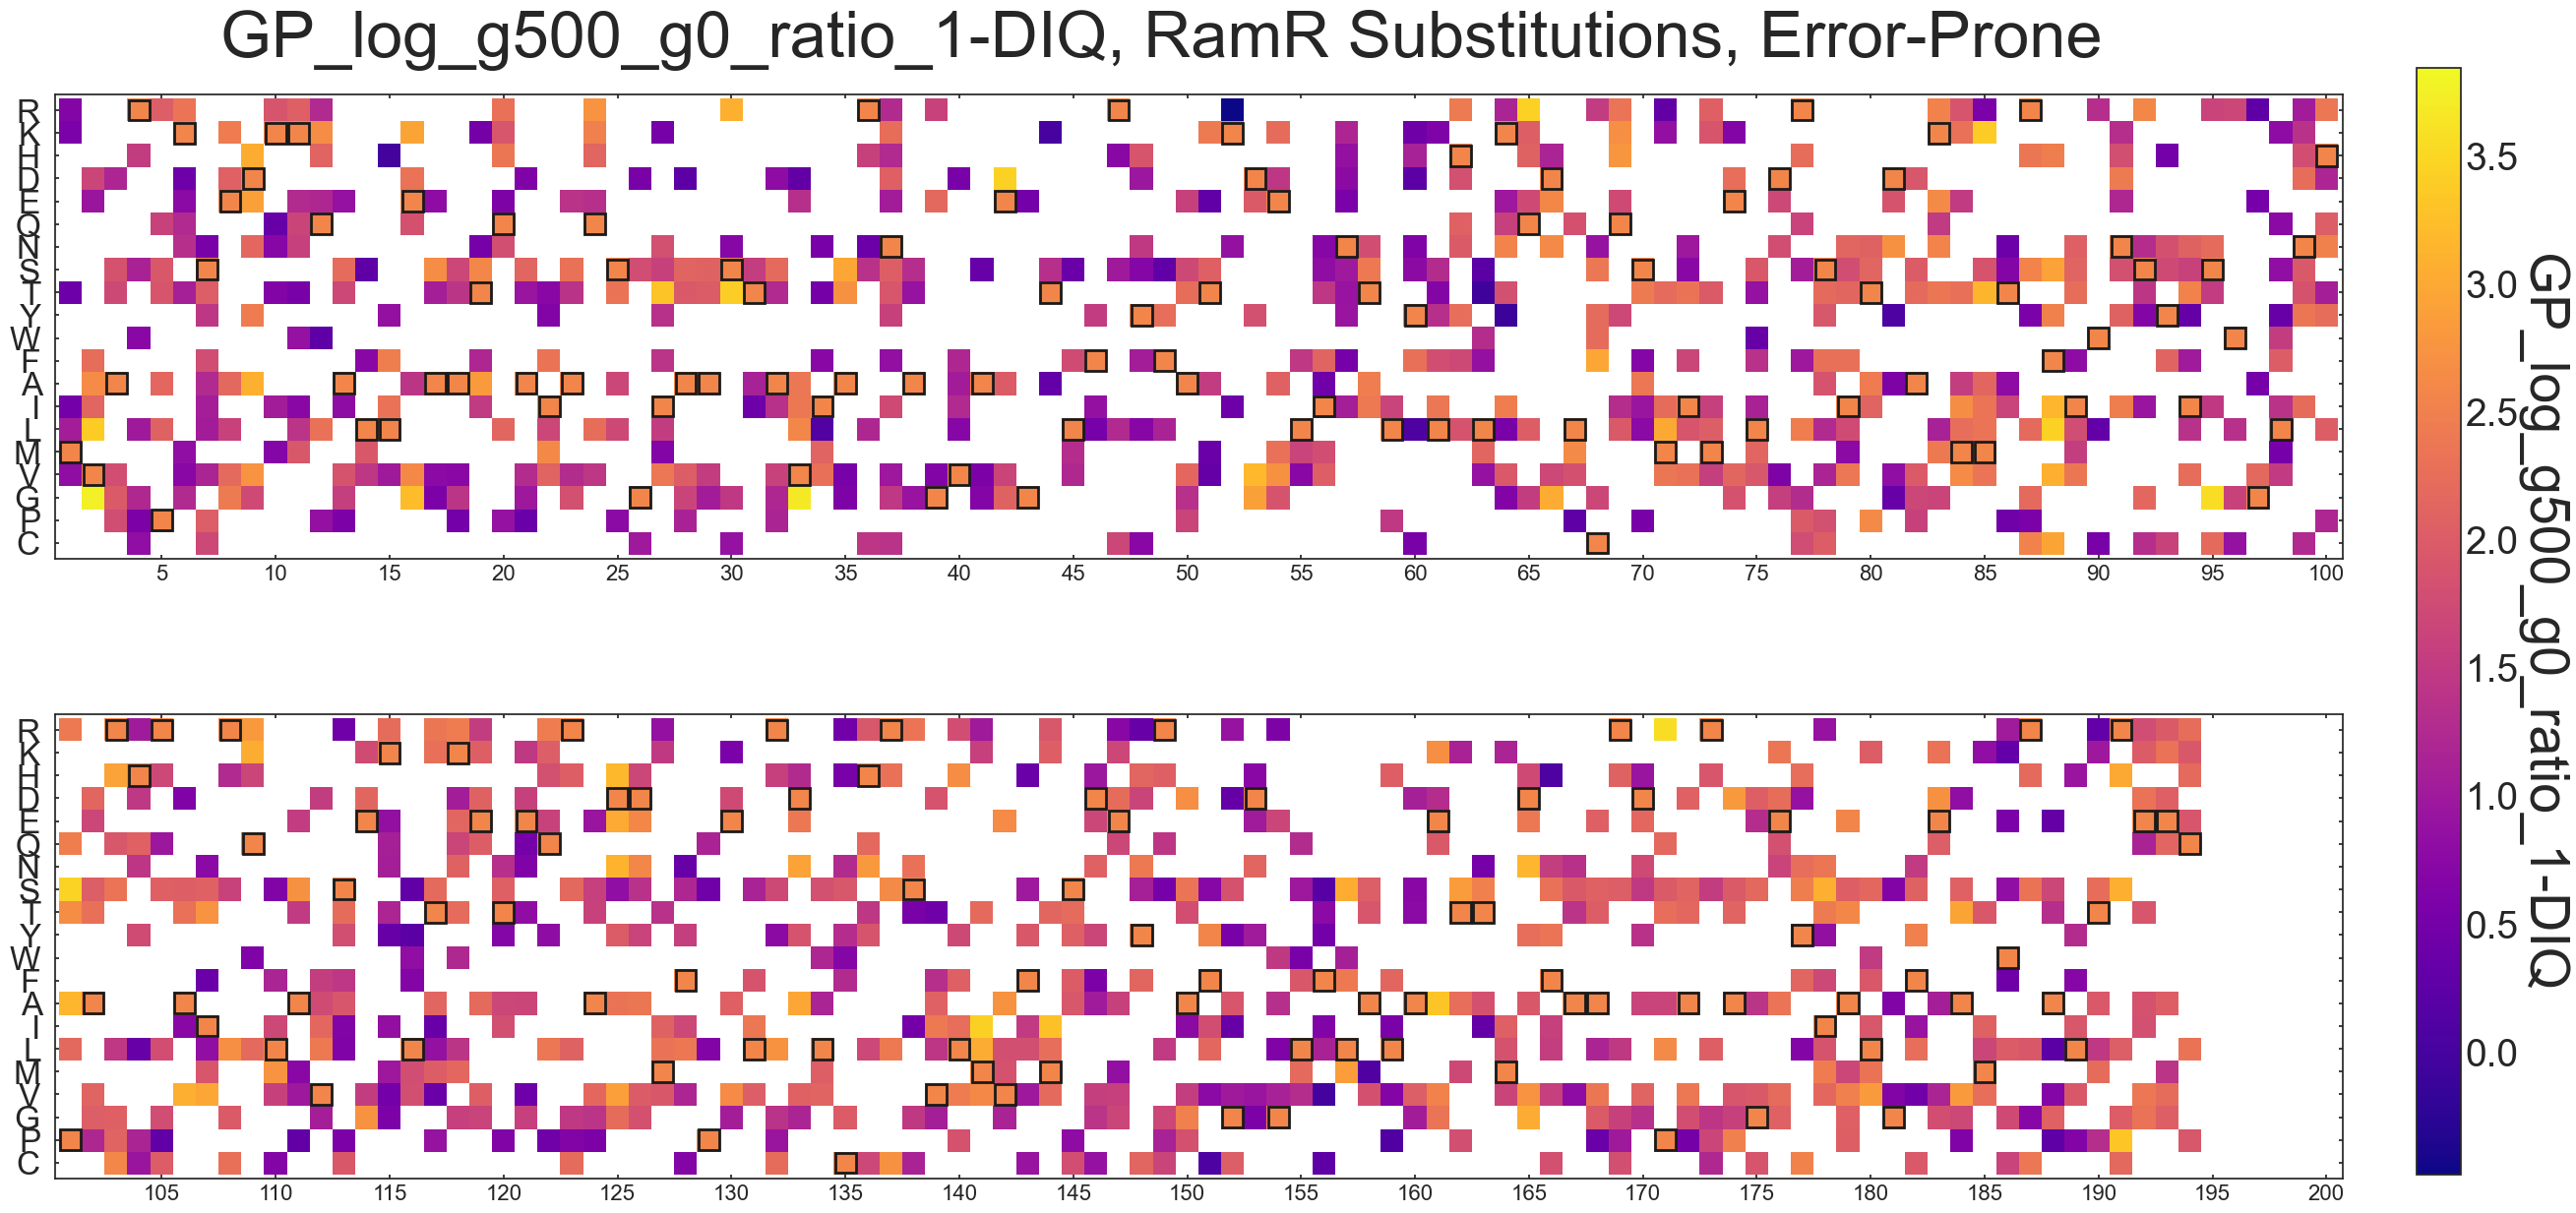

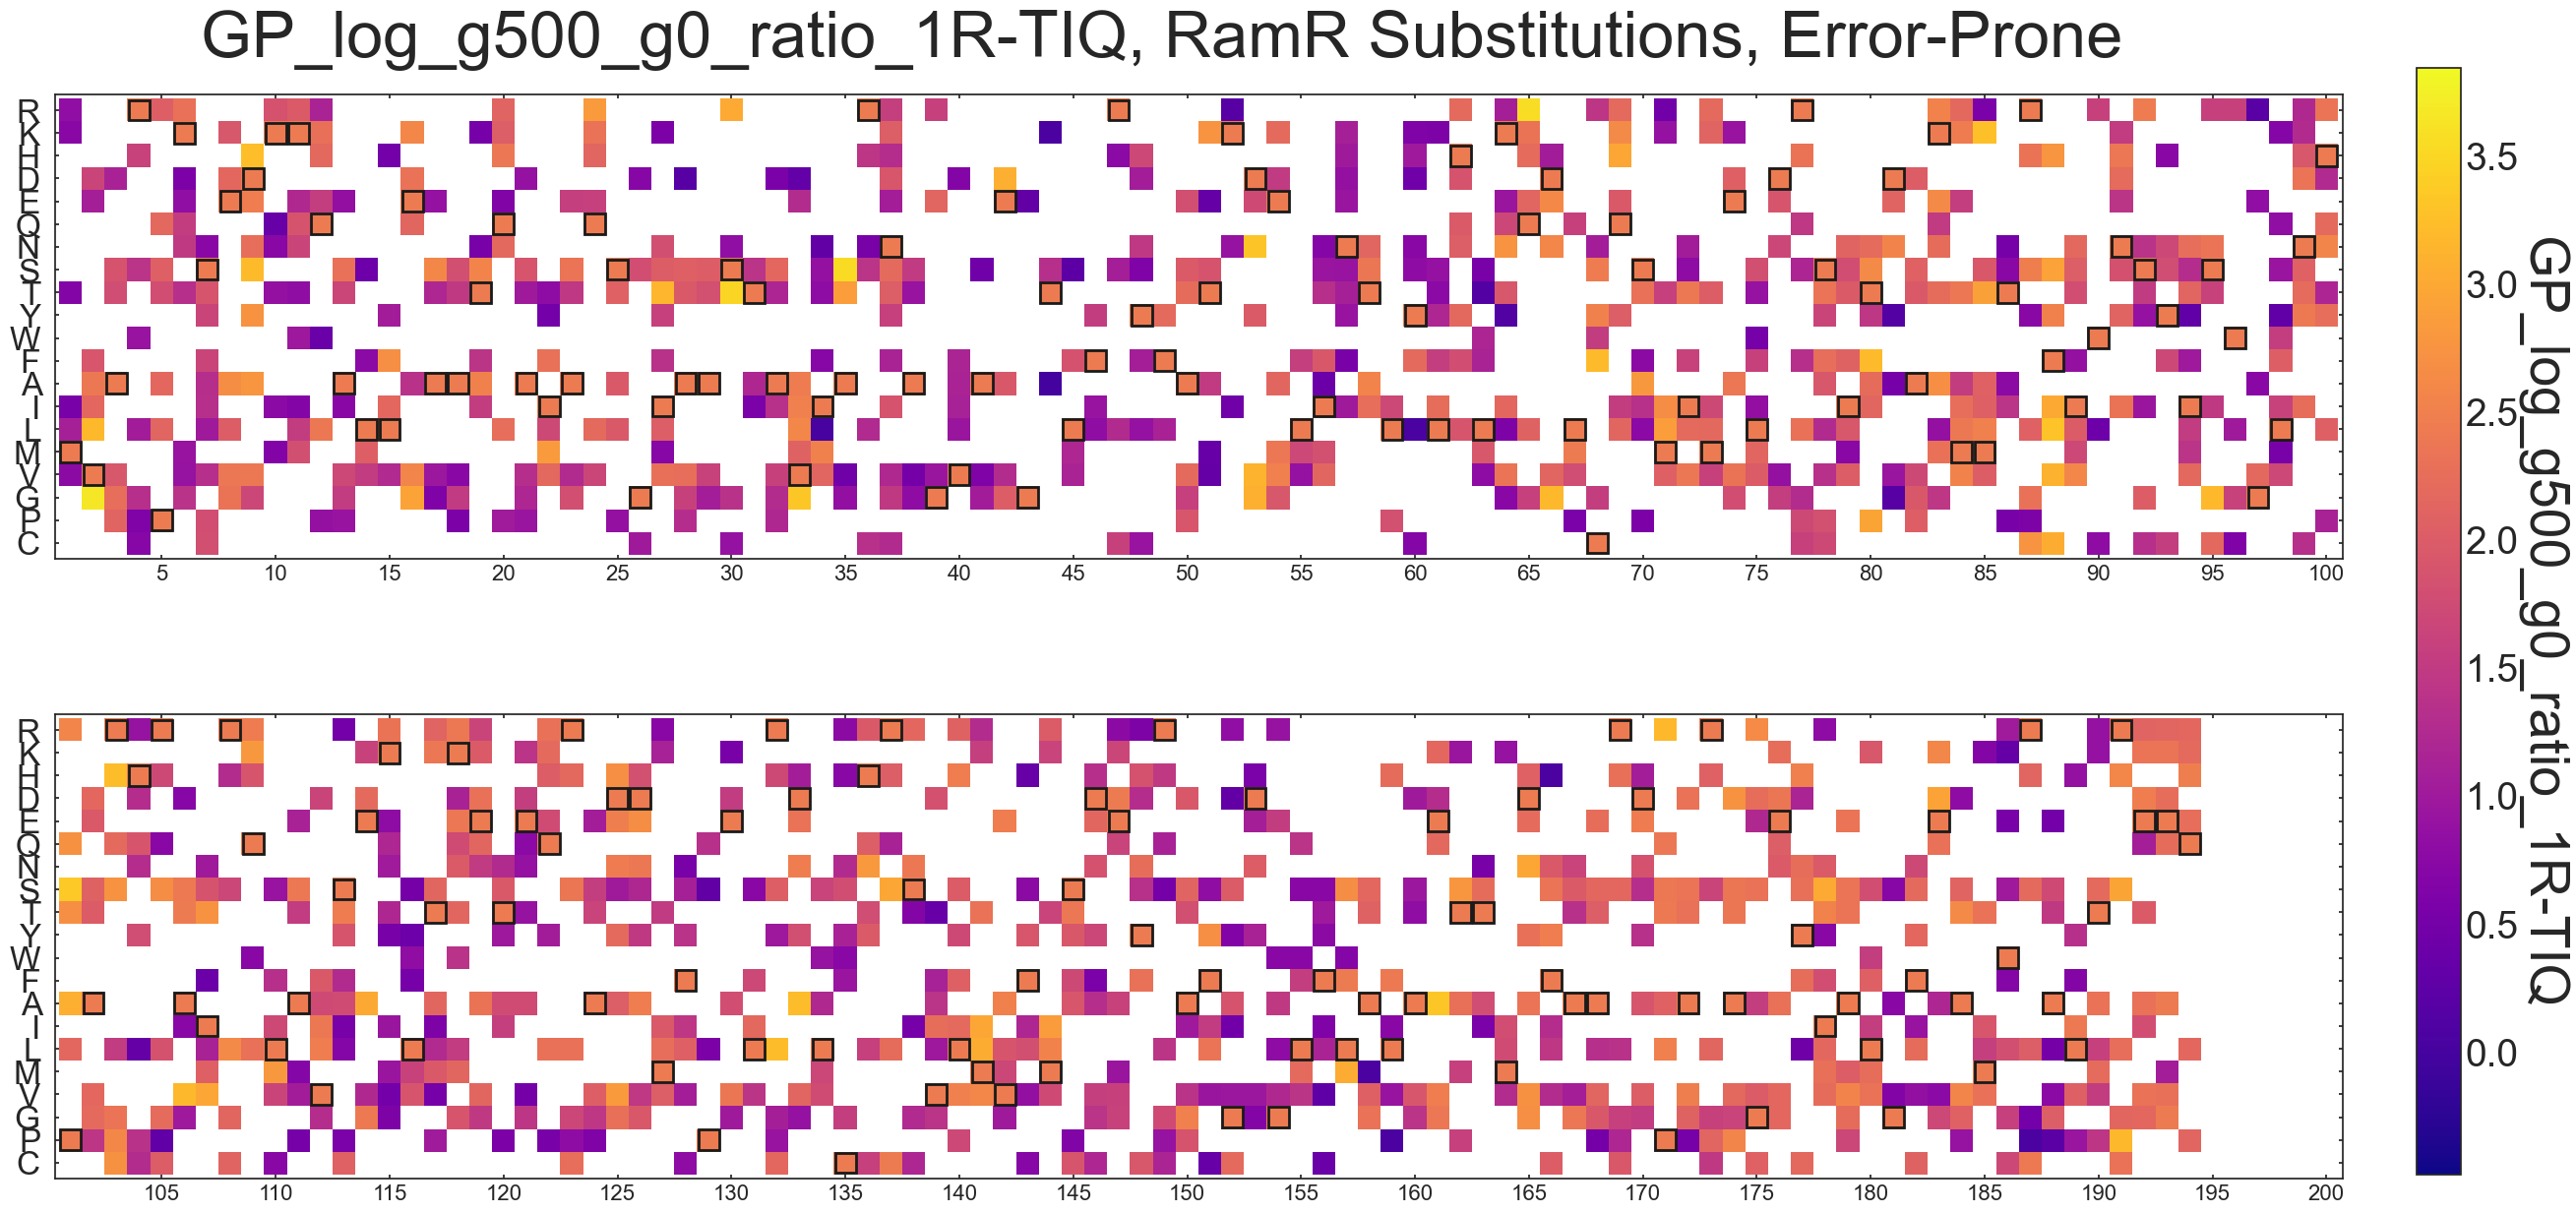

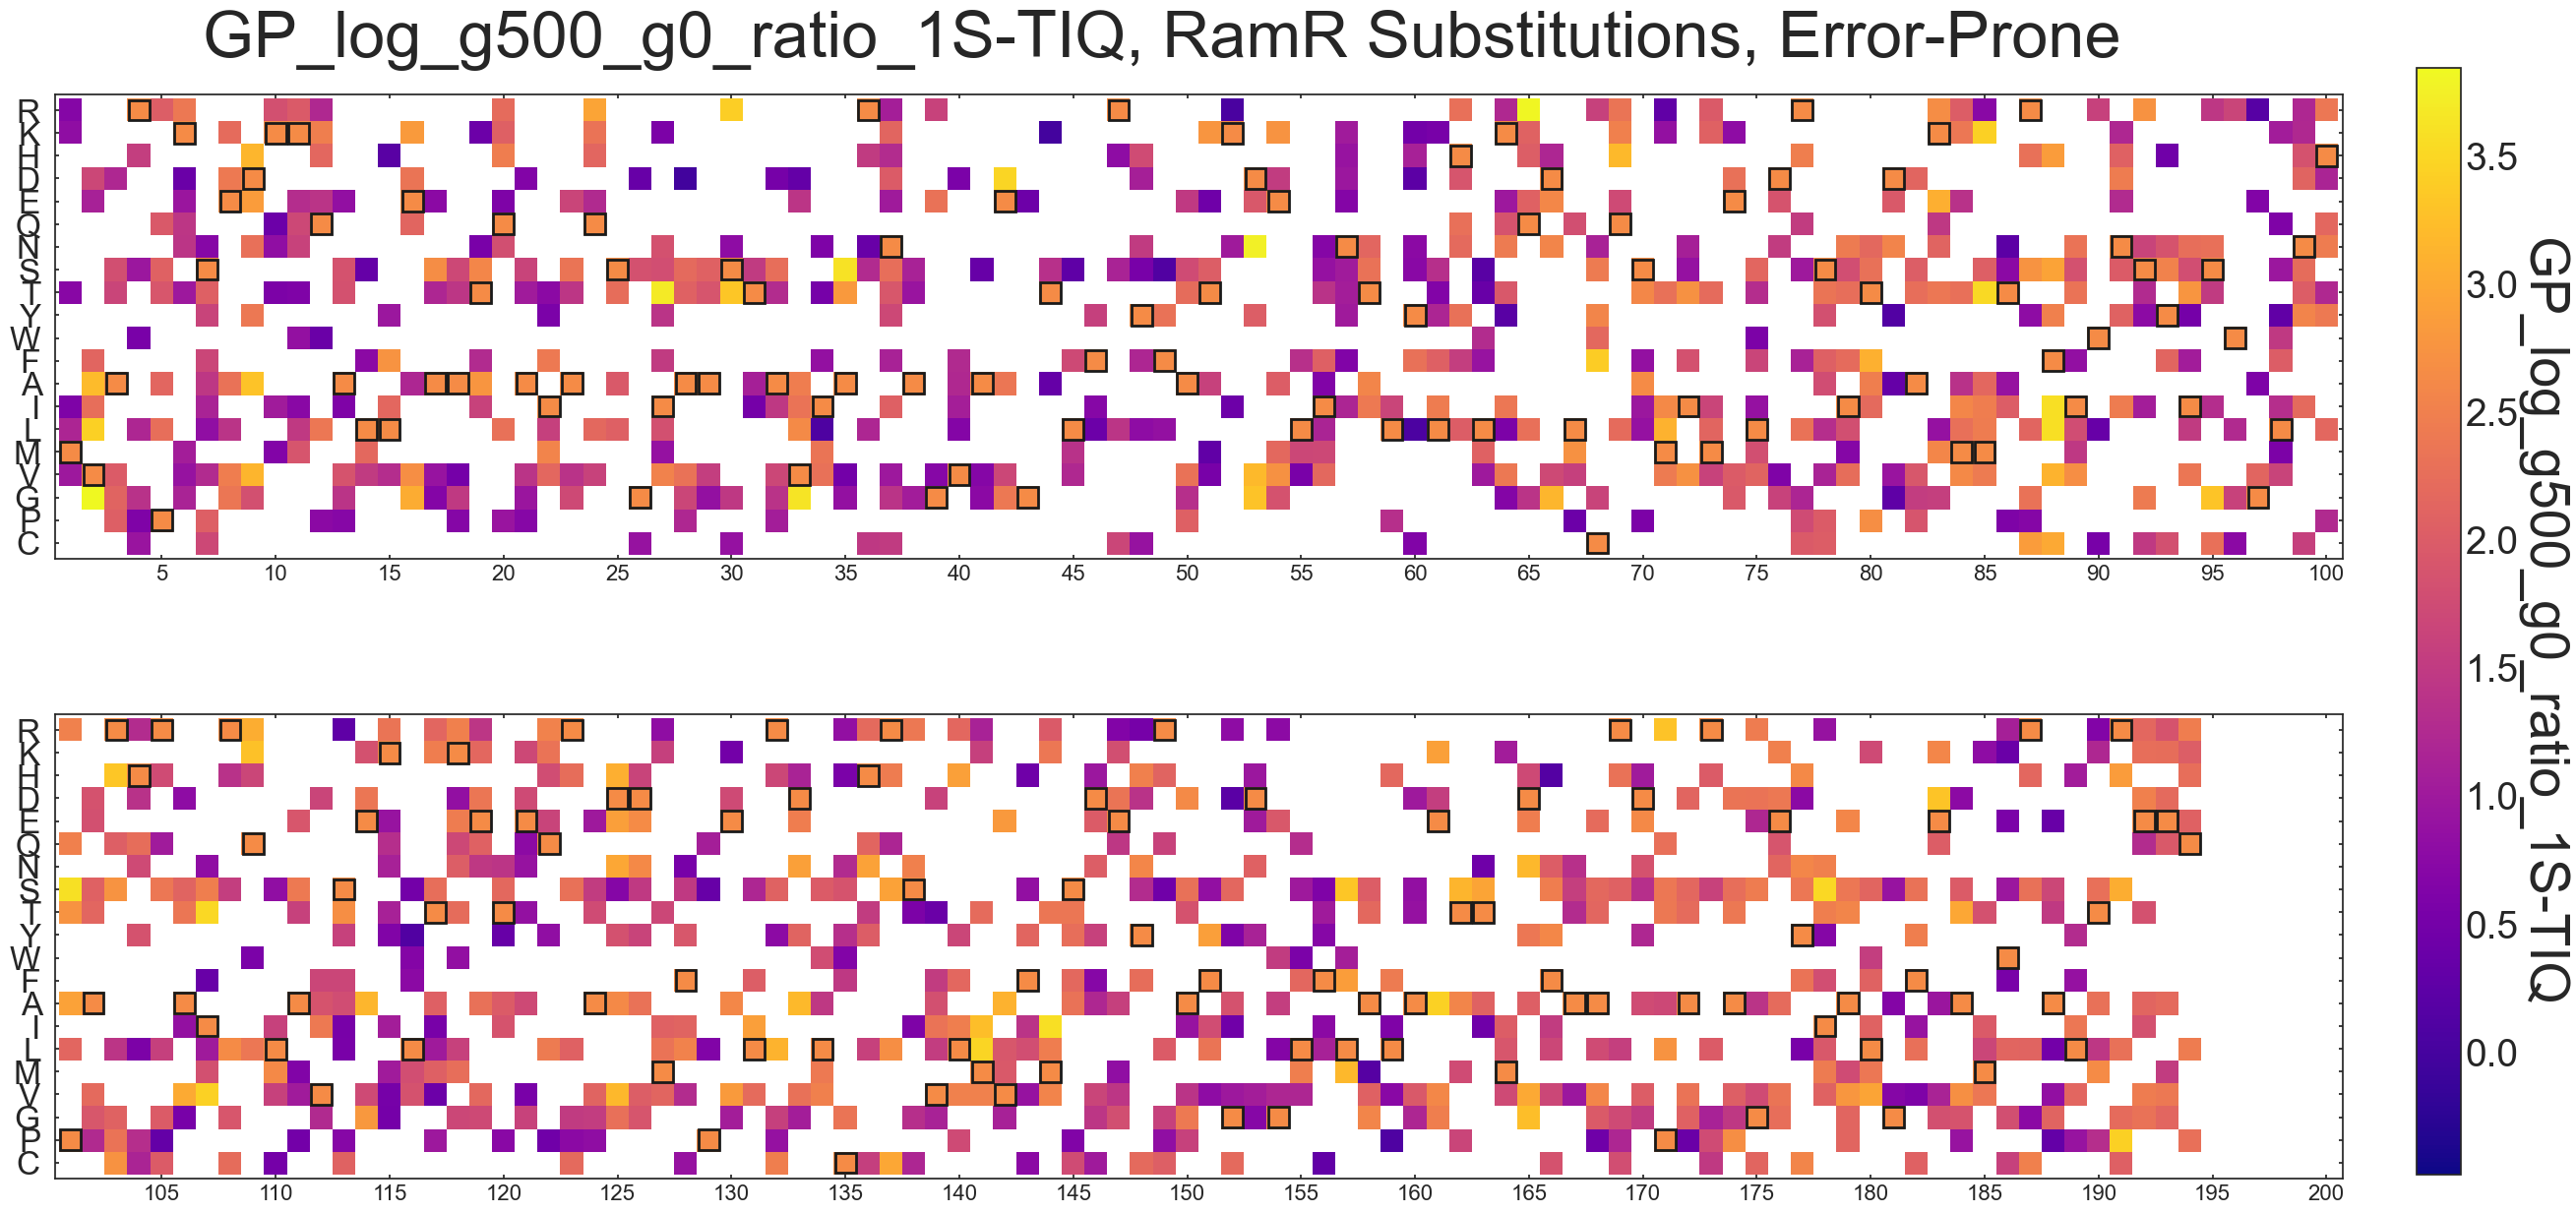

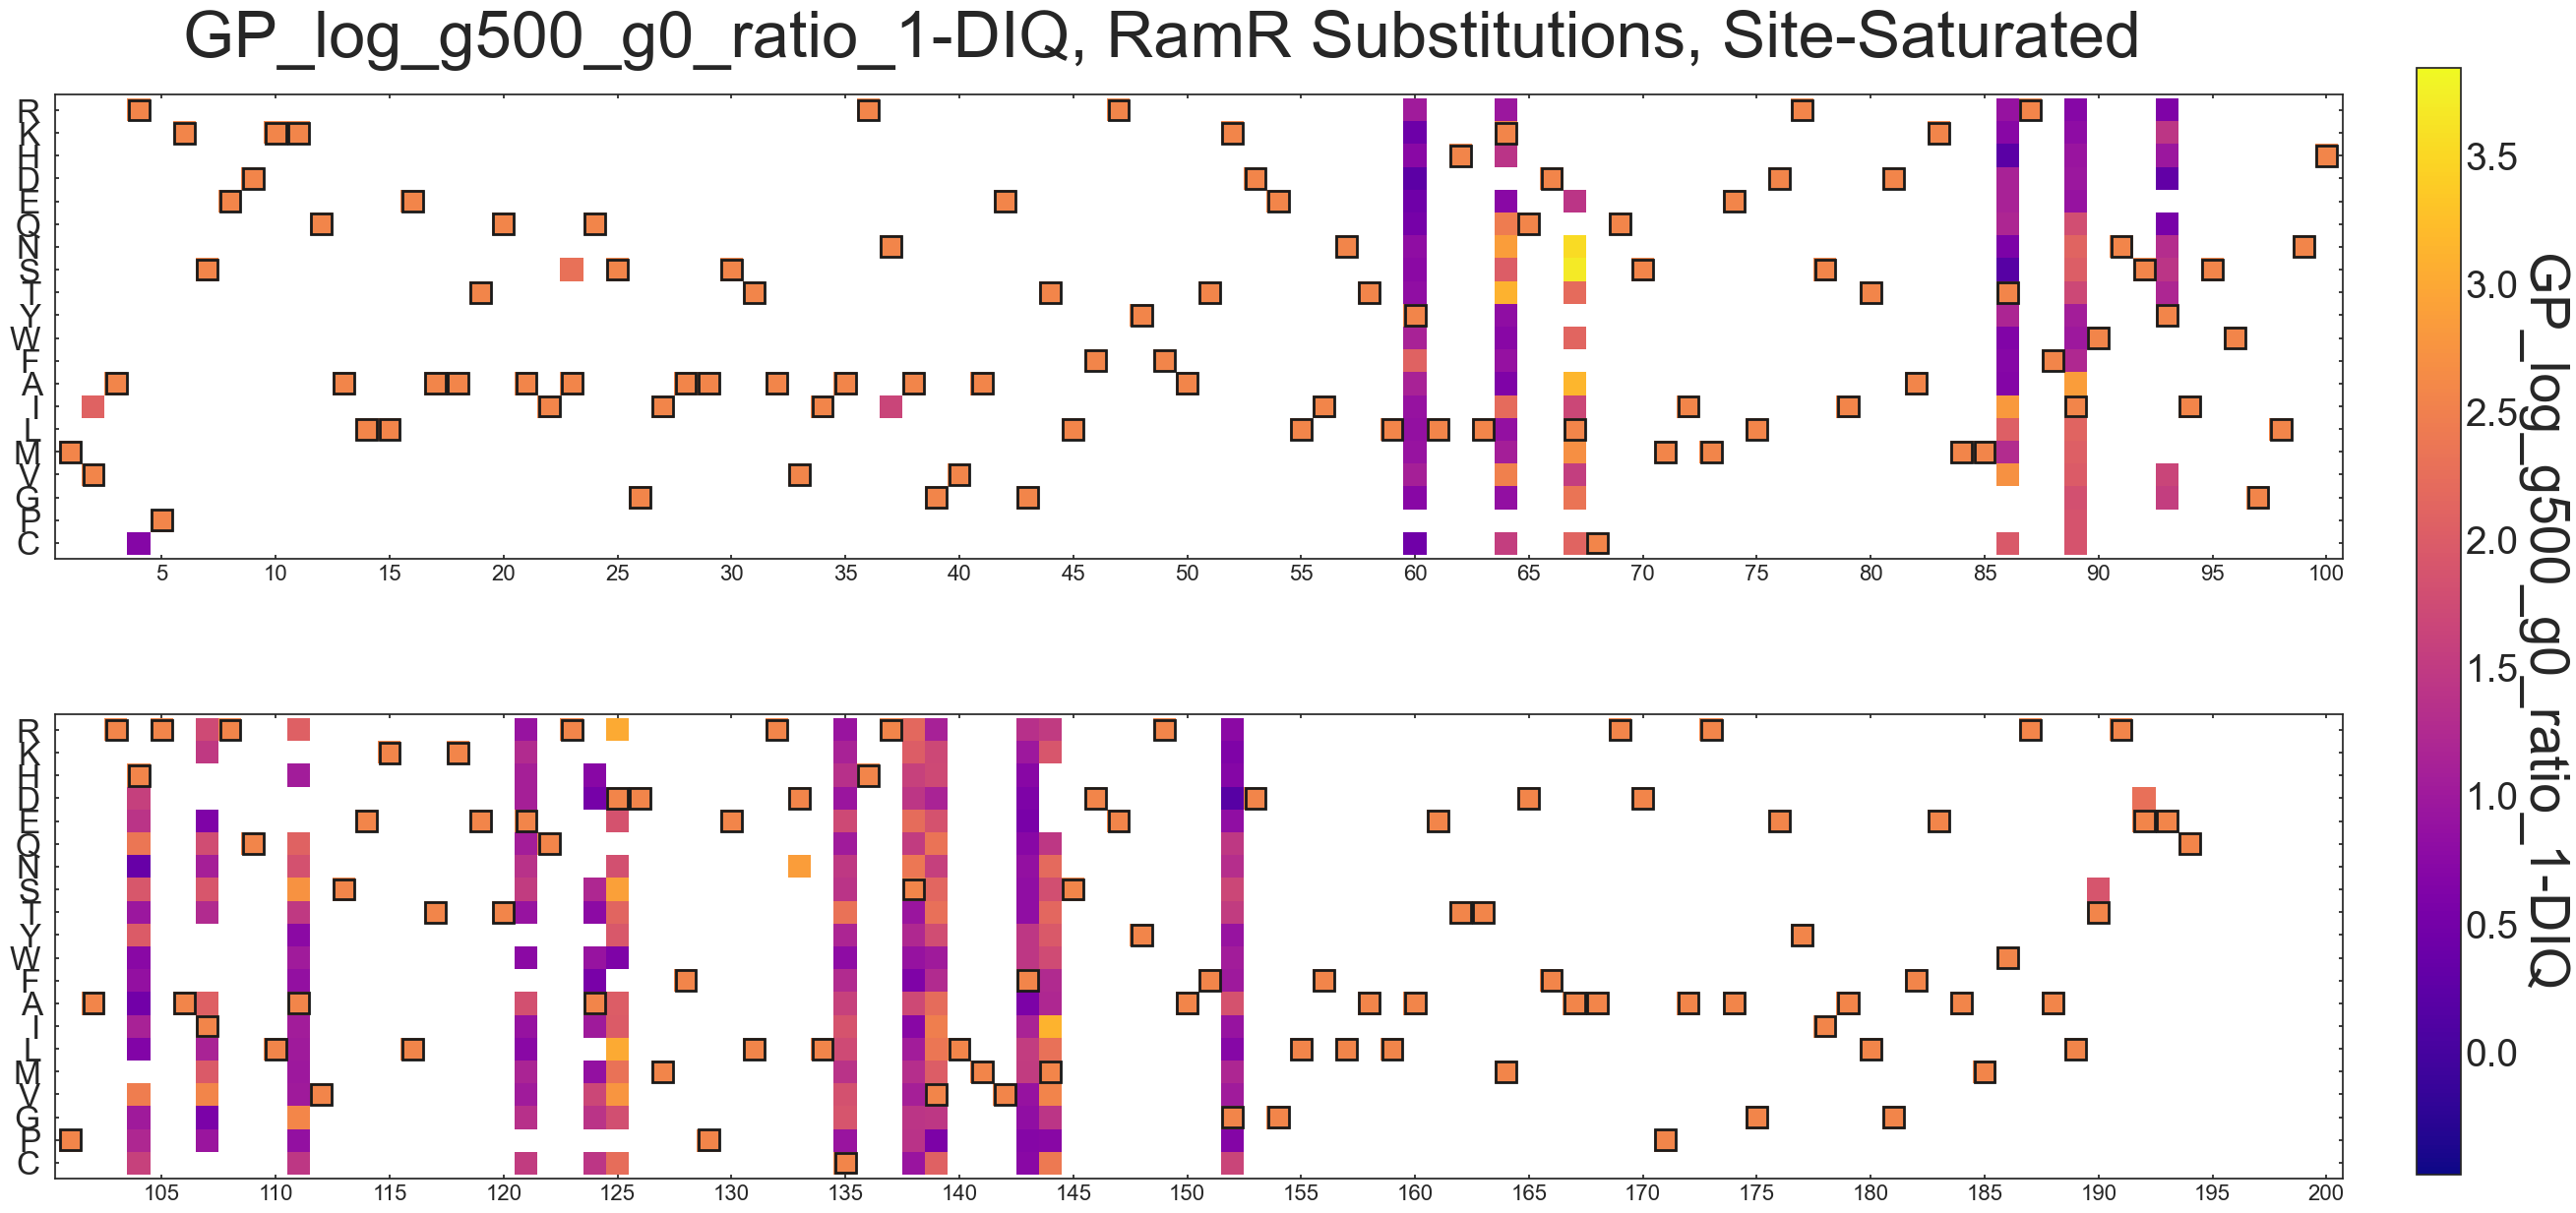

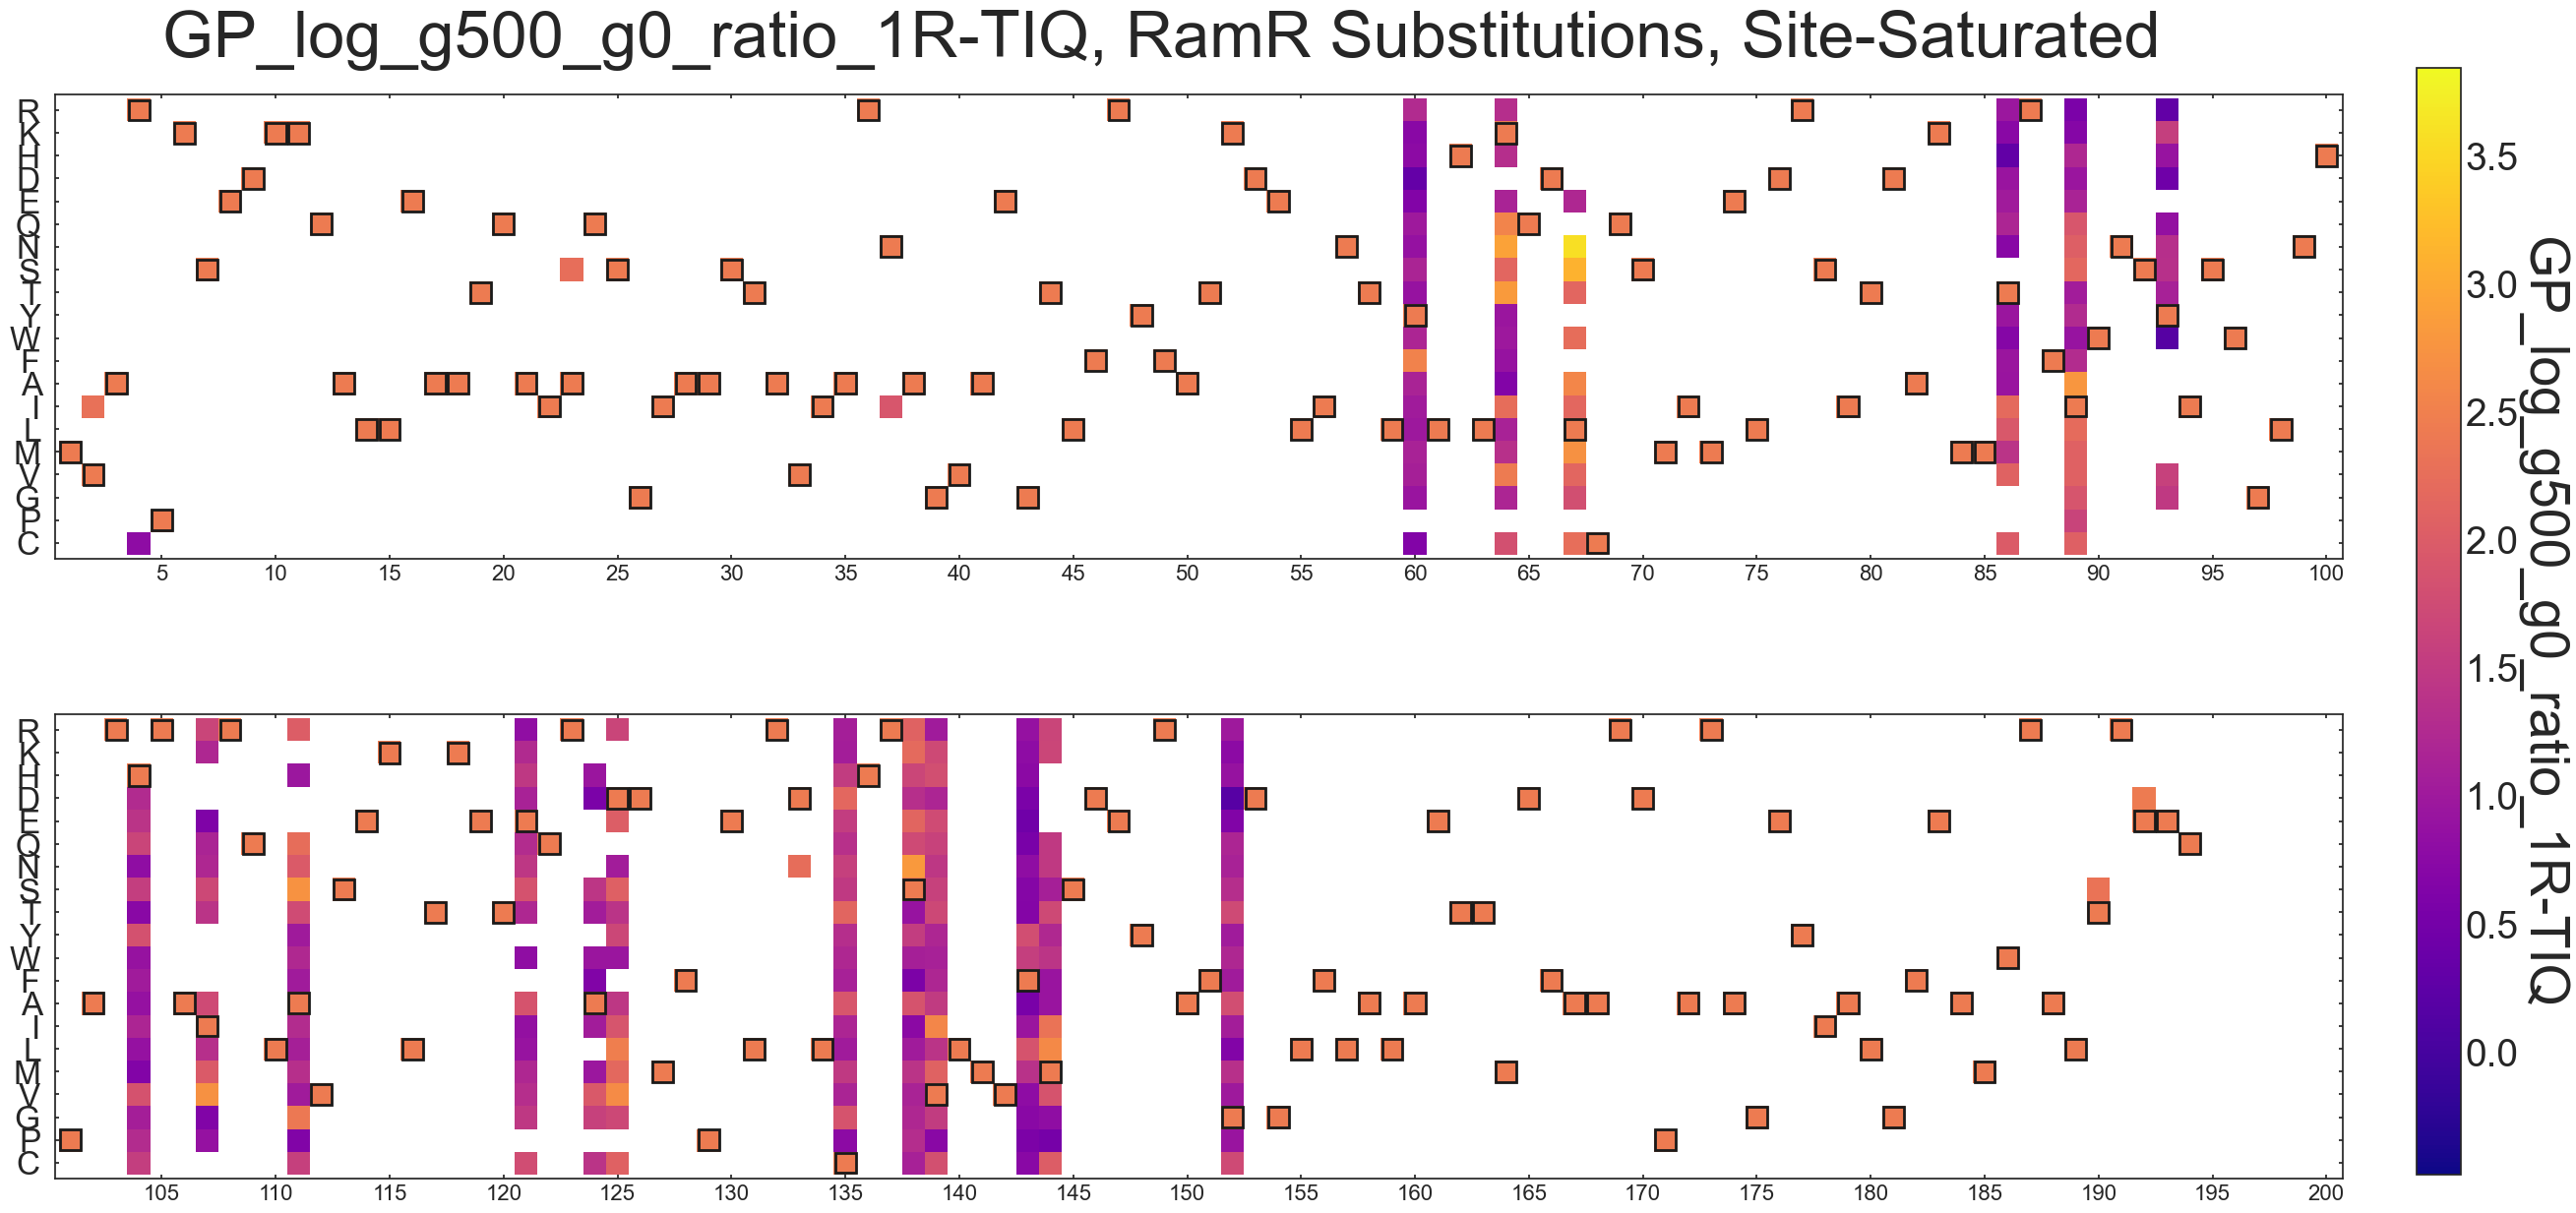

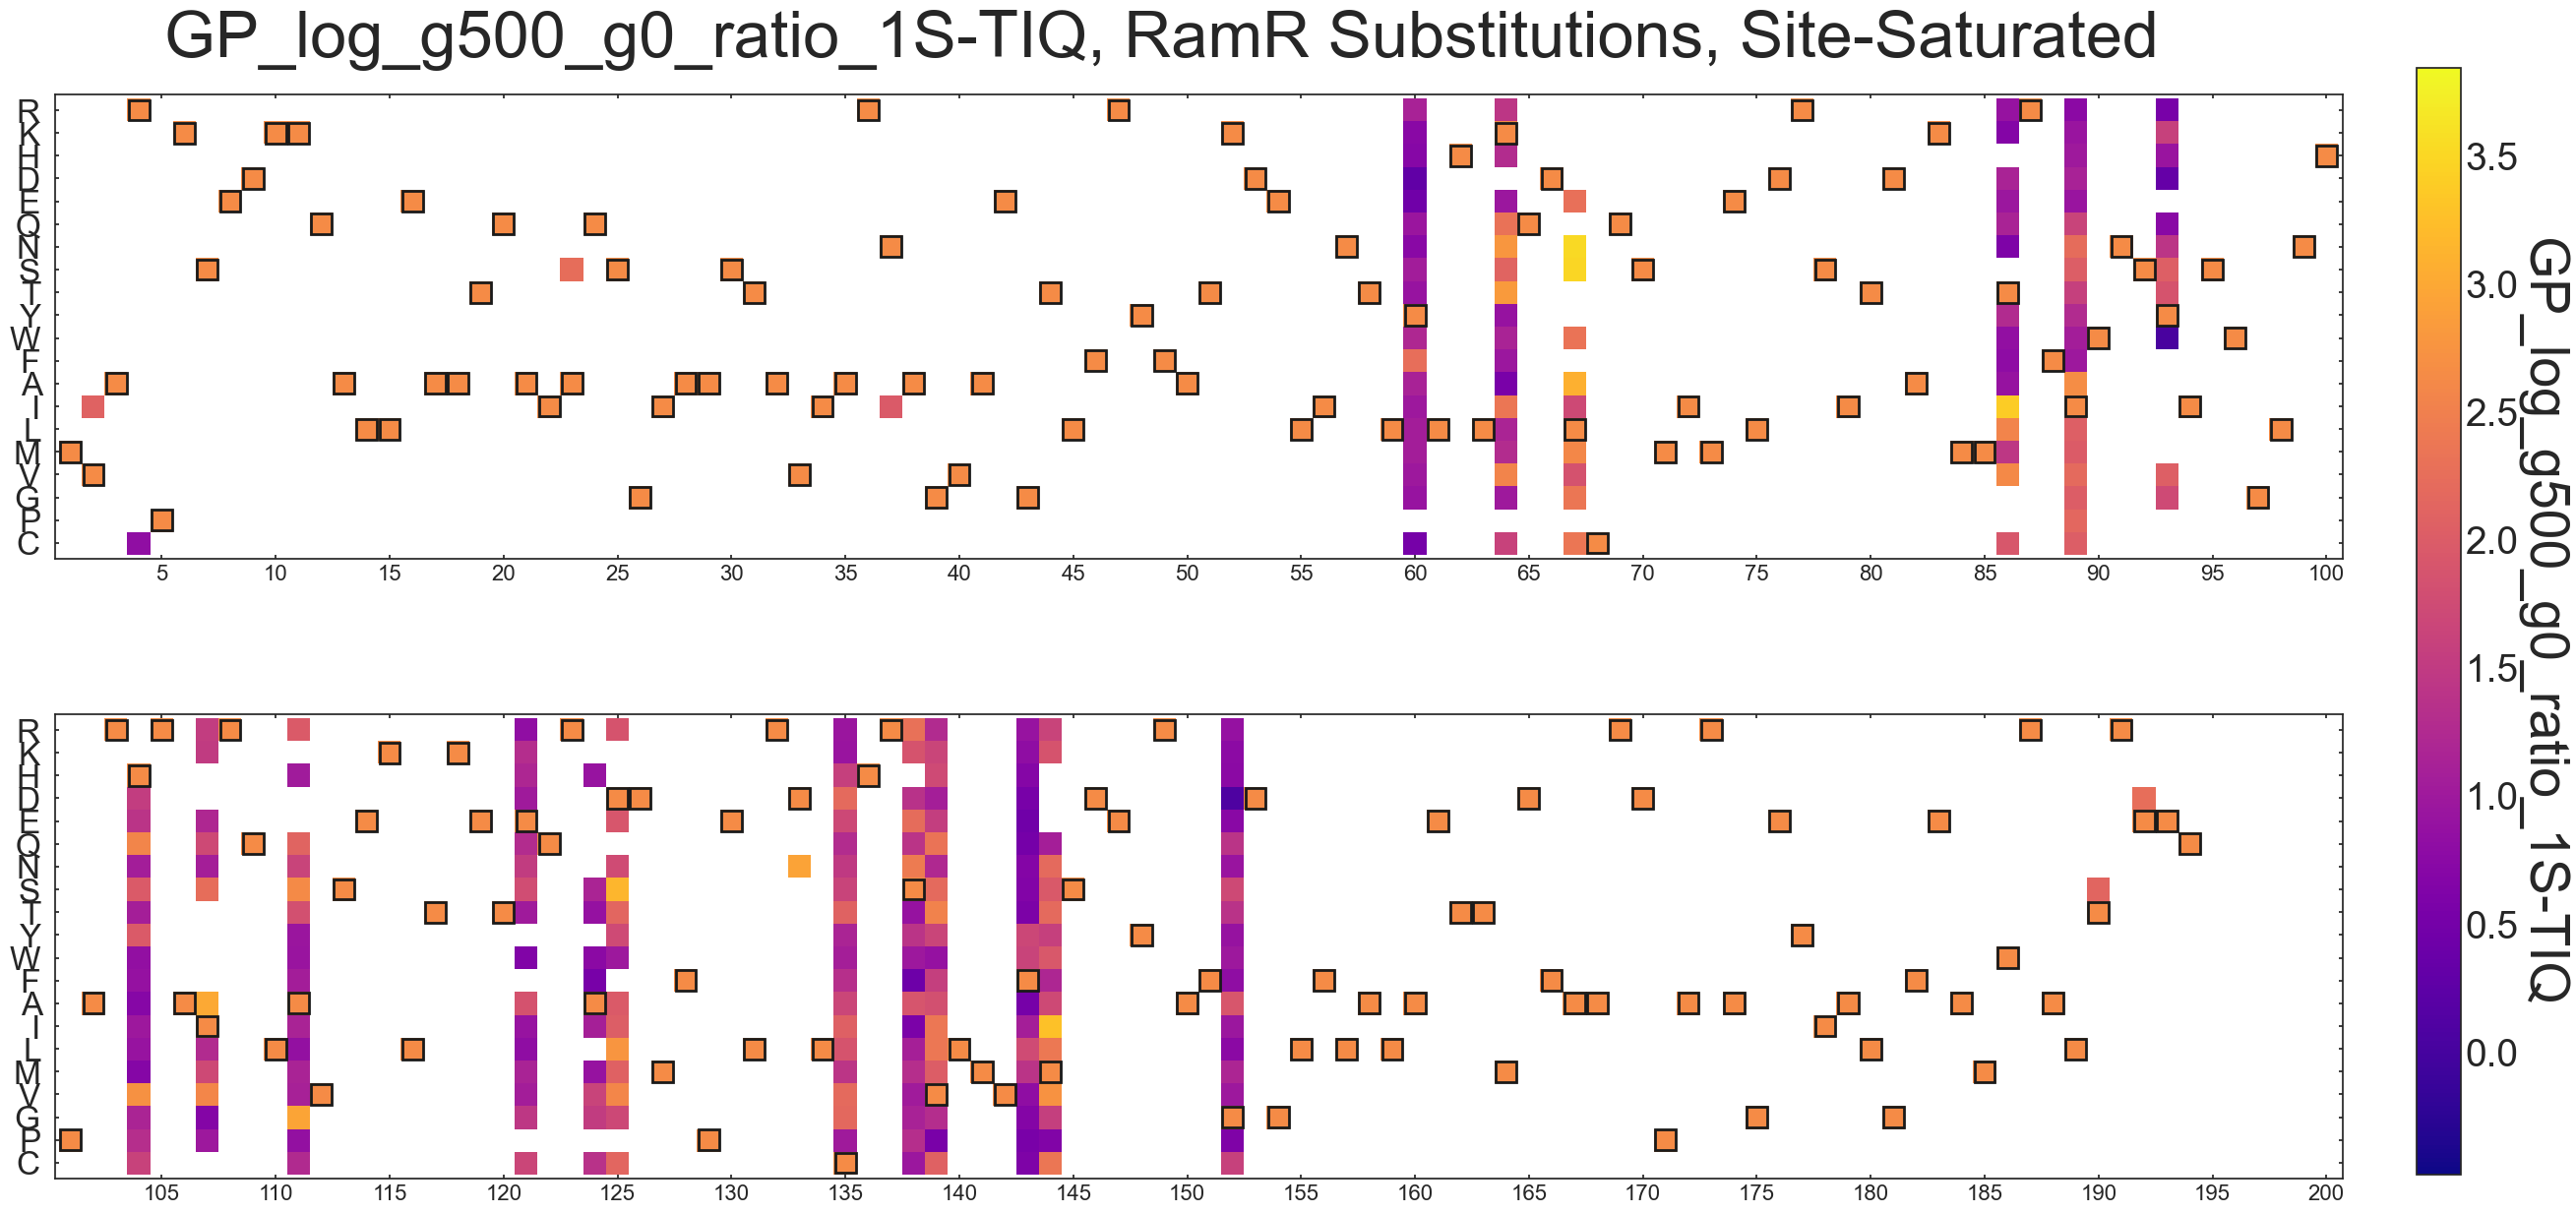

In [92]:
plt.rcParams["figure.figsize"] = [30,15]

for k in single_dynamic_range_dict:
    for lig in ligand_list:
        plot_param = f'GP_log_g500_g0_ratio_{lig}'

        fig, axs = plt.subplots(2, 1)
        param_label = plot_param
        fig.suptitle(f'{plot_param}, RamR Substitutions, {titles_dict[k]}', size=48, y=0.92)

        plot_arr = single_dynamic_range_dict[k][lig]

        cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

        cmap = copy.copy(plot_param_cmap)
        #cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
        cmap.set_under(color='white')
        cmap.set_bad(color='white')

        axis_cut_point = 101

        plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

        for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
            #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
            im = ax.imshow(arr.transpose(), norm=colors.Normalize(vmin=vmin_plot_param, vmax=vmax_plot_param), cmap=cmap);
            #ax.set_axis_off();
            ax.grid(visible=False);
            if ax is axs[0]:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            else:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            ax.set_yticks([i for i in range(len(amino_codes))]);
            ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
            ax.set_yticklabels(ylabels) #, size=16);
            #ax.set_ylim(-0.5, 7.5);
            ax.tick_params(length=3);
            xlim = ax.get_xlim()
            ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
            ylim = ax.get_ylim()
            ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

            #for i, c in enumerate(arr):
            #    x_pos = i + 1
            #    for y_pos in np.where(c==10**missing_fill_value)[0]:
            #        draw_x_pos((x_pos, y_pos), ax)

        fig.colorbar(im, cax=cb_ax);

        # outline and draw X to mark wild-type 
        for i, c in enumerate(wild_type_aminos):
            y_pos = np.where(amino_codes==c)[0][0]
            if i < axis_cut_point - 1:
                x_pos = i + 1
                ax = axs[0]
            else:
                x_pos = i - axis_cut_point + 2
                ax = axs[1]
            outline_pos((x_pos, y_pos), ax)
            #draw_x_pos((x_pos, y_pos), ax)

        cb_ax.tick_params(axis='y', labelsize=28)
        cb_ax.set_ylabel(param_label, size=40, rotation=270, labelpad=35)

        axs[1].set_xlim(axs[0].get_xlim())

        os.chdir(notebook_directory)
        #fig.savefig(f"Dynamic range {lig} heatmap.{k}.svg", dpi=None, bbox_inches="tight")

# Redo function heat maps, merged for both EP and SS libraries

## G0 heat maps

In [93]:
# Make array for heat-map plot of G0 for each substitution

missing_fill_value = -5

k = 'merged'
log_g0_arr = []
for i, c1 in enumerate(wild_type_aminos):
    pos = i+1
    log_g0_sub_arr = []
    for c2 in amino_codes:
        mut = f'{c1}{pos}{c2}'

        df_ep = single_mutations_frame_dict['EP']
        df_ep = df_ep[df_ep.mutation==mut]

        df_ss = single_mutations_frame_dict['SS']
        df_ss = df_ss[df_ss.mutation==mut]
        
        if (len(df_ep)==0) and (len(df_ss)==0):
            if c1 == c2:
                log_g0 = wild_type_params_dict['EP']['log_g0'][0]
            else:
                log_g0 = missing_fill_value
        
        elif (len(df_ep)==0):
            log_g0 = df_ss.sort_values(by='total_counts', ascending=False).iloc[0].log_g0
        elif (len(df_ss)==0):
            log_g0 = df_ep.sort_values(by='total_counts', ascending=False).iloc[0].log_g0
        else:
            log_g0 = [df.sort_values(by='total_counts', ascending=False).iloc[0].log_g0 for df in [df_ep, df_ss]]
            log_g0_err = [df.sort_values(by='total_counts', ascending=False).iloc[0].log_g0_err for df in [df_ep, df_ss]]
            log_g0_err = np.array(log_g0_err)
            log_g0 = np.average(log_g0, weights=1/log_g0_err**2)

        log_g0_sub_arr.append(log_g0)
    log_g0_arr.append(log_g0_sub_arr)
log_g0_arr = np.array(log_g0_arr)
print(log_g0_arr.shape)
single_log_g0_dict[k] = log_g0_arr

(194, 20)


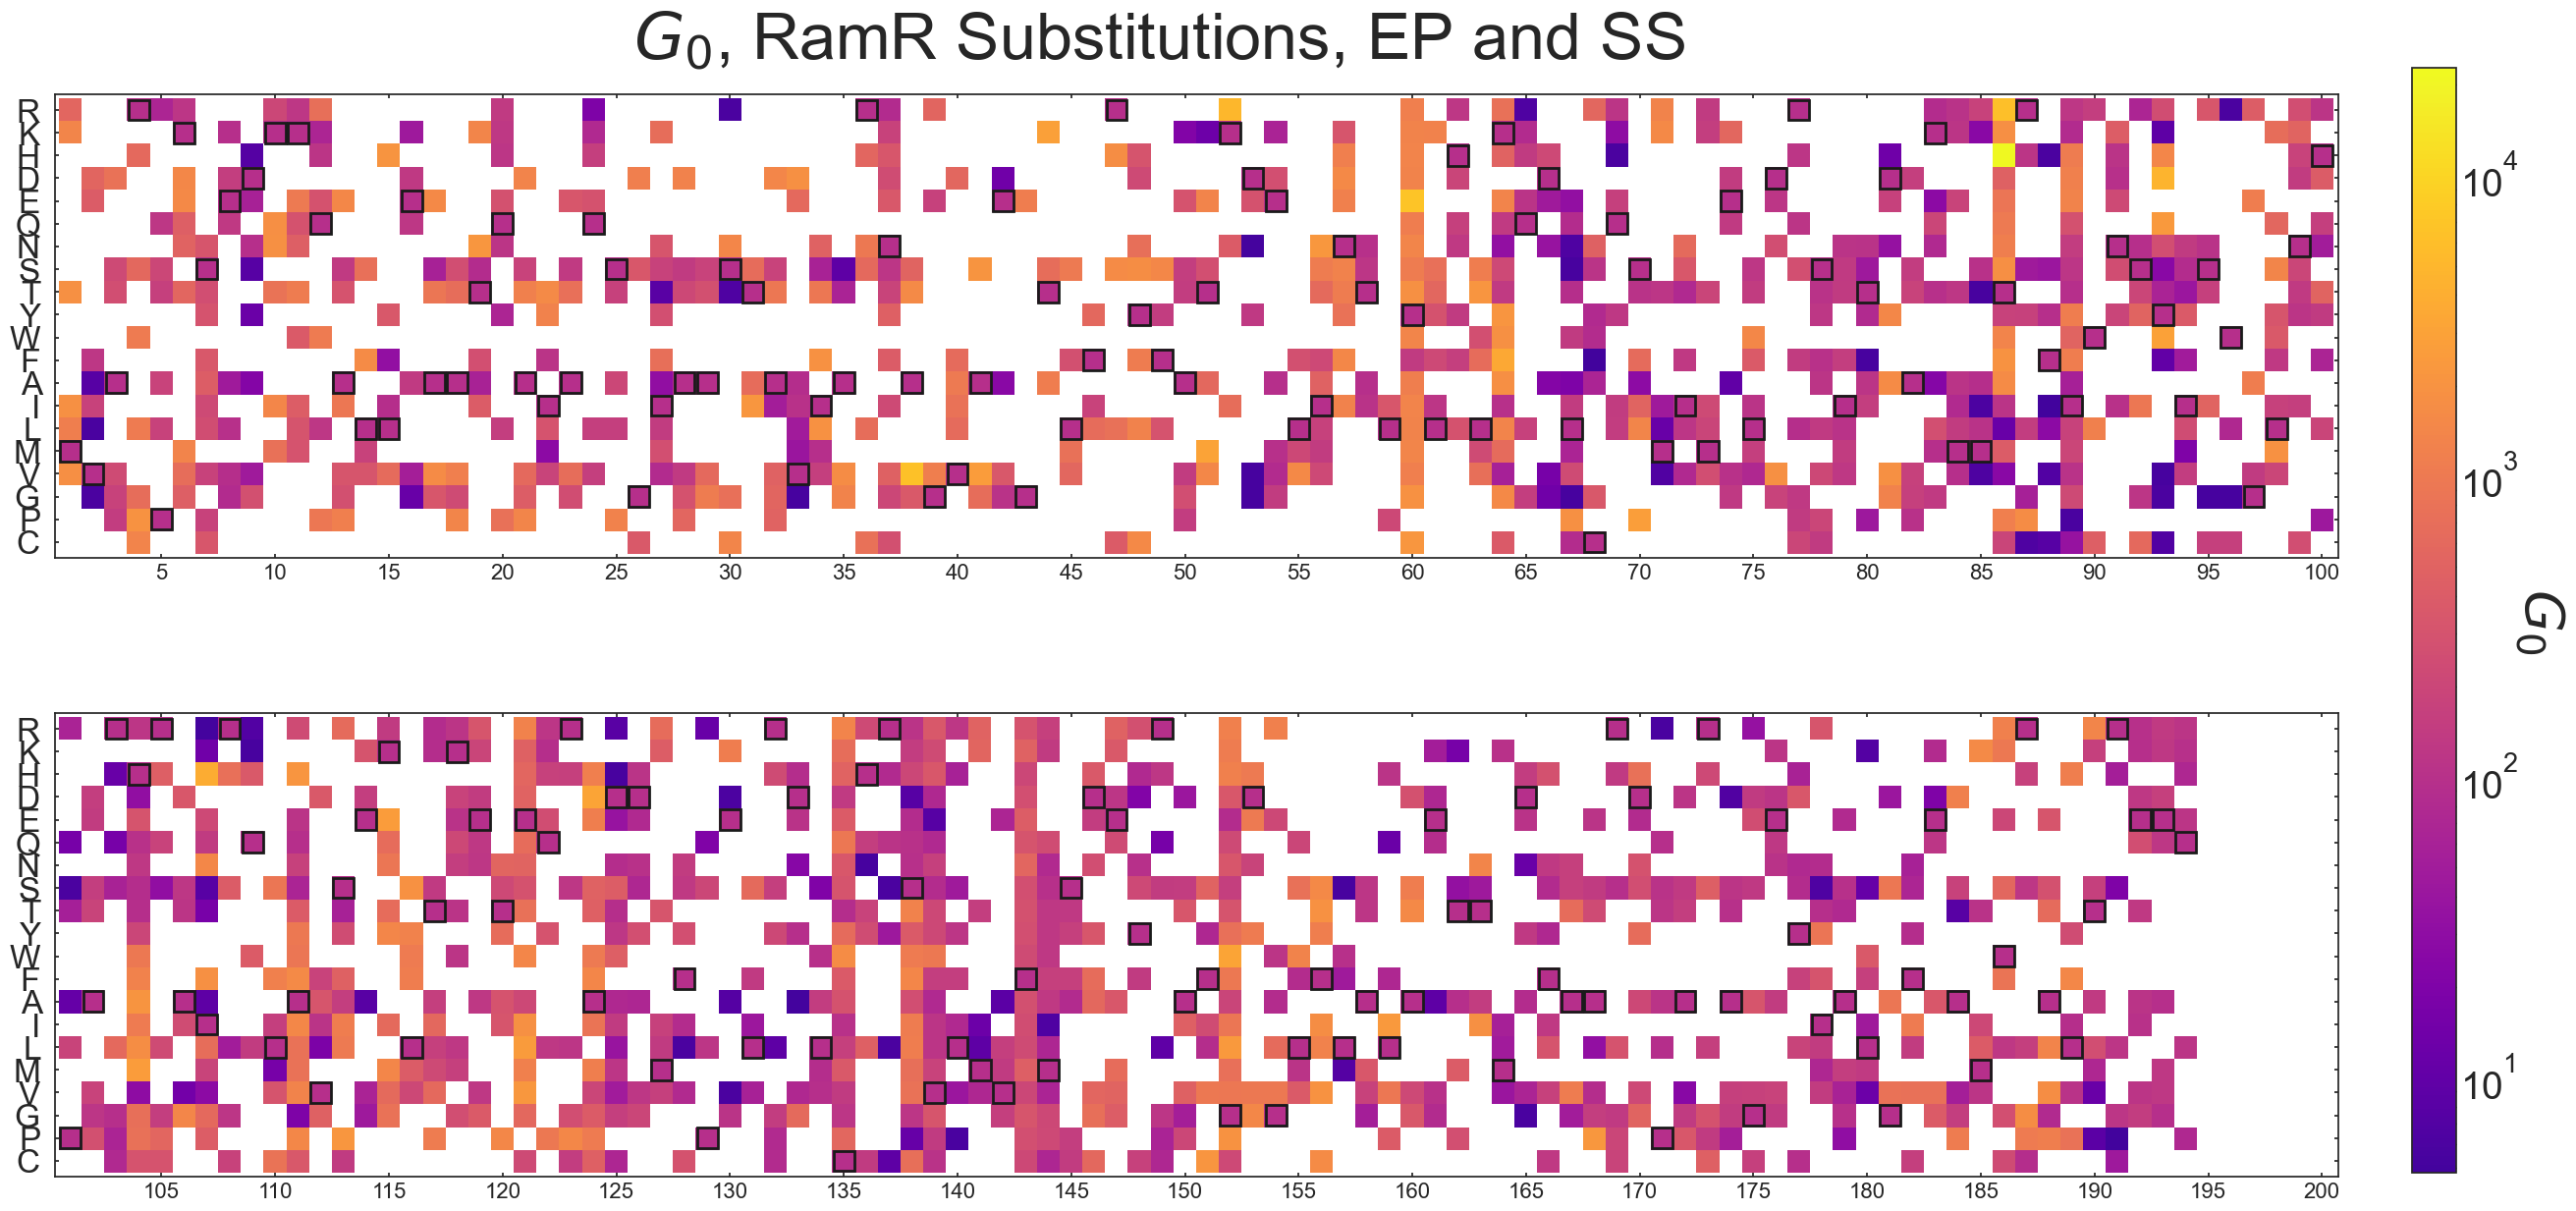

In [94]:
plt.rcParams["figure.figsize"] = [30,15]


vmin_ep = 10**single_mutations_frame_dict['EP'].log_g0.min()
vmax_ep = 10**single_mutations_frame_dict['EP'].log_g0.max()
vmin_ss = 10**single_mutations_frame_dict['SS'].log_g0.min()
vmax_ss = 10**single_mutations_frame_dict['SS'].log_g0.max()
vmin = min(vmin_ep, vmin_ss)
vmax = max(vmax_ep, vmax_ss)

for k in ['merged']:
    plot_arr = single_log_g0_dict[k]
    fig, axs = plt.subplots(2, 1)
    fig.suptitle('$G_0$, RamR Substitutions, EP and SS', size=48, y=0.92)

    plot_arr = 10**plot_arr

    cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

    cmap = copy.copy(colormaps["plasma"])
    cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
    cmap.set_under(color='white')
    cmap.set_bad(color='white')

    axis_cut_point = 101

    plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

    for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
        #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
        im = ax.imshow(arr.transpose(), norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap);
        #ax.set_axis_off();
        ax.grid(visible=False);
        if ax is axs[0]:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        else:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        ax.set_yticks([i for i in range(len(amino_codes))]);
        ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
        ax.set_yticklabels(ylabels) #, size=16);
        #ax.set_ylim(-0.5, 7.5);
        ax.tick_params(length=3);
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

        #for i, c in enumerate(arr):
        #    x_pos = i + 1
        #    for y_pos in np.where(c==10**missing_fill_value)[0]:
        #        draw_x_pos((x_pos, y_pos), ax)

    fig.colorbar(im, cax=cb_ax);

    # outline and draw X to mark wild-type 
    for i, c in enumerate(wild_type_aminos):
        y_pos = np.where(amino_codes==c)[0][0]
        if i < axis_cut_point - 1:
            x_pos = i + 1
            ax = axs[0]
        else:
            x_pos = i - axis_cut_point + 2
            ax = axs[1]
        outline_pos((x_pos, y_pos), ax)
        #draw_x_pos((x_pos, y_pos), ax)

    cb_ax.tick_params(axis='y', labelsize=28)
    cb_ax.set_ylabel('$G_0$', size=40, rotation=270, labelpad=35)

    axs[1].set_xlim(axs[0].get_xlim())

    os.chdir(notebook_directory)
    #fig.savefig(f"G0 heatmap.EP and SS.svg", dpi=None, bbox_inches="tight")

## mean_log_ec50

In [95]:
ec50_cmap = colormaps['RdYlBu_r']

In [96]:
# Make array for heat-map plot of plot_param for each substitution

plot_param = 'mean_log_ec50'
missing_fill_value = -5
err_cutoff = 0.5

k = 'merged'

log_ec50_arr = []
for i, c1 in enumerate(wild_type_aminos):
    pos = i+1
    log_g_ratio_sub_arr = []
    for c2 in amino_codes:
        mut = f'{c1}{pos}{c2}'
        
        df_ep = single_mutations_frame_dict['EP']
        df_ep = df_ep[df_ep[f'{plot_param}_err']<err_cutoff]
        df_ep = df_ep[df_ep.mutation==mut]
        
        df_ss = single_mutations_frame_dict['SS']
        df_ss = df_ss[df_ss[f'{plot_param}_err']<err_cutoff]
        df_ss = df_ss[df_ss.mutation==mut]
        
        
        if (len(df_ep)==0) and (len(df_ss)==0):
            if c1 == c2:
                log_ec50 = wild_type_params_dict['EP'][plot_param][0]
            else:
                log_ec50 = missing_fill_value
        
        elif (len(df_ep)==0):
            log_ec50 = df_ss.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]
        elif (len(df_ss)==0):
            log_ec50 = df_ep.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]
        else:
            log_ec50 = [df.sort_values(by='total_counts', ascending=False).iloc[0][plot_param] for df in [df_ep, df_ss]]
            log_ec50_err = [df.sort_values(by='total_counts', ascending=False).iloc[0][f'{plot_param}_err'] for df in [df_ep, df_ss]]
            
            log_ec50_err = np.array(log_ec50_err)
            log_ec50 = np.average(log_ec50, weights=1/log_ec50_err**2)
            
        log_g_ratio_sub_arr.append(log_ec50)
    log_ec50_arr.append(log_g_ratio_sub_arr)
log_ec50_arr = np.array(log_ec50_arr)
print(log_ec50_arr.shape)
single_mean_log_ec50_dict[k] = log_ec50_arr

(194, 20)


In [97]:
wt_log_ec50 = wild_type_params_dict['EP'][plot_param][0]

log_ec50_min = single_mutations_frame_dict['EP'][plot_param].min()
log_ec50_min = min(log_ec50_min, single_mutations_frame_dict['SS'][plot_param].min())

log_ec50_max = np.log10(500)

min_span = wt_log_ec50 - log_ec50_min
max_span = log_ec50_max - wt_log_ec50

if min_span > max_span:
    vmin_ec50 = 10**(wt_log_ec50 - min_span)
    vmax_ec50 = 10**(wt_log_ec50 + min_span)
else:
    vmin_ec50 = 10**(wt_log_ec50 - max_span)
    vmax_ec50 = 10**(wt_log_ec50 + max_span)

vmin_ec50, vmax_ec50

(24.715515322412994, 1062.8459696035304)

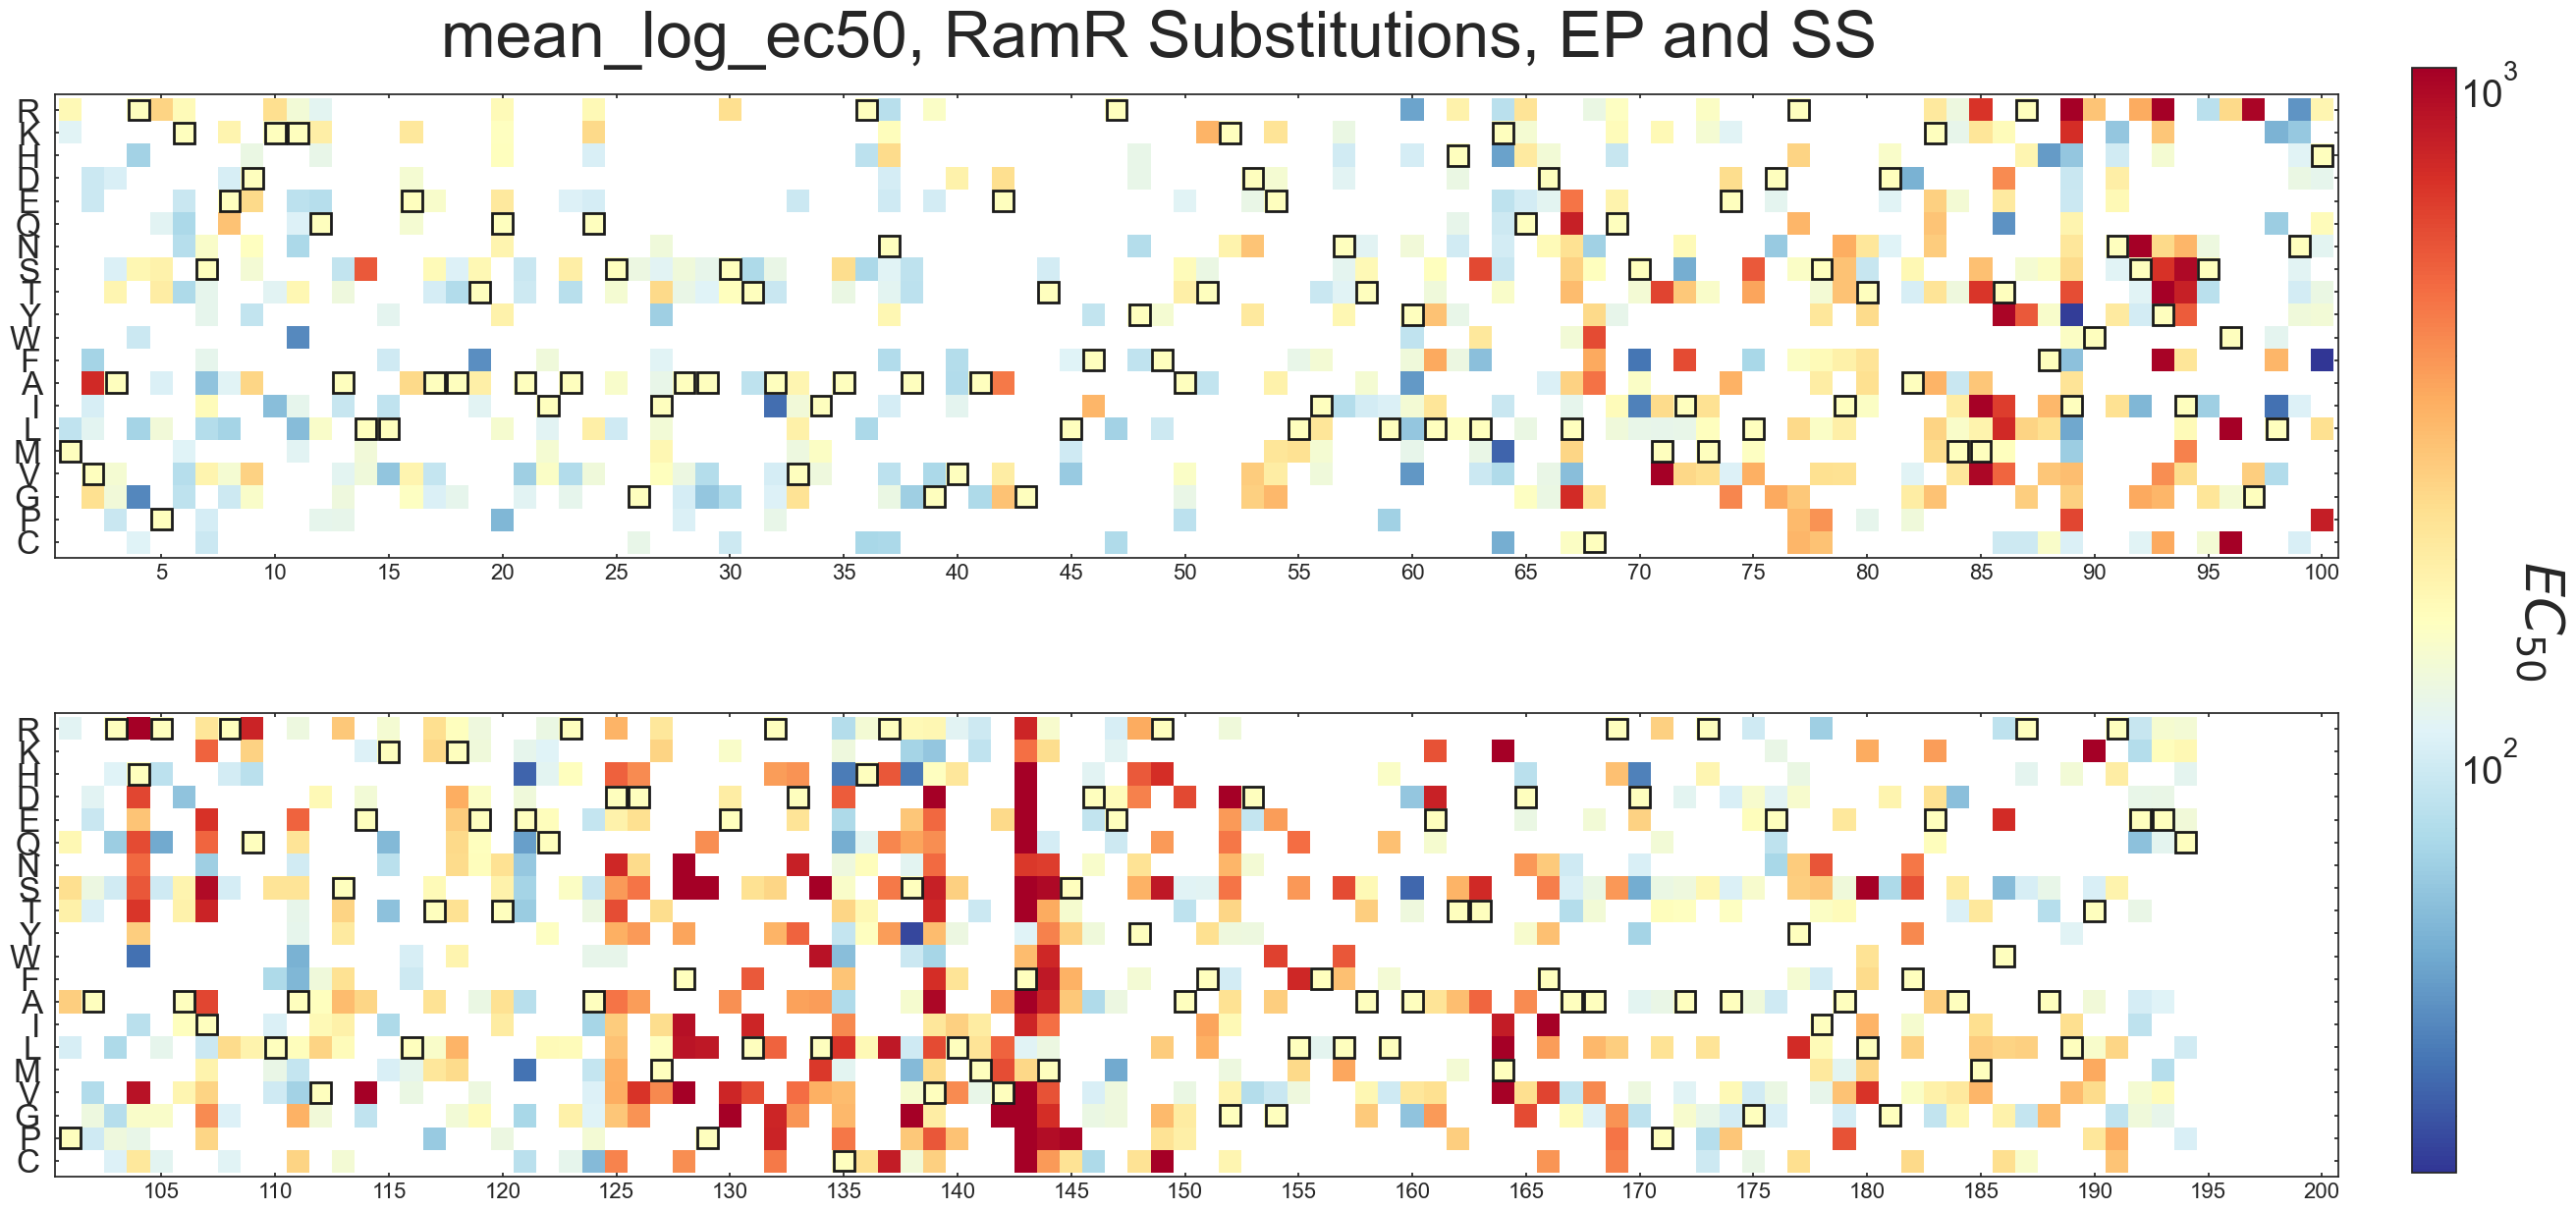

In [98]:
plt.rcParams["figure.figsize"] = [30,15]

for k in ['merged']:
    plot_arr = single_mean_log_ec50_dict[k]
    fig, axs = plt.subplots(2, 1)
    param_label = '$EC_{50}$'
    fig.suptitle(f'{plot_param}, RamR Substitutions, EP and SS', size=48, y=0.92)

    plot_arr = 10**(plot_arr)

    cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

    cmap = copy.copy(ec50_cmap)
    #cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
    cmap.set_under(color='white')
    cmap.set_bad(color='white')

    axis_cut_point = 101

    plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

    for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
        #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
        im = ax.imshow(arr.transpose(), norm=colors.LogNorm(vmin=vmin_ec50, vmax=vmax_ec50), cmap=cmap);
        #ax.set_axis_off();
        ax.grid(visible=False);
        if ax is axs[0]:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        else:
            ax.set_xticks([i-1 for i in range(5, 105, 5)]);
            ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
        ax.set_yticks([i for i in range(len(amino_codes))]);
        ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
        ax.set_yticklabels(ylabels) #, size=16);
        #ax.set_ylim(-0.5, 7.5);
        ax.tick_params(length=3);
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

        #for i, c in enumerate(arr):
        #    x_pos = i + 1
        #    for y_pos in np.where(c==10**missing_fill_value)[0]:
        #        draw_x_pos((x_pos, y_pos), ax)

    fig.colorbar(im, cax=cb_ax);

    # outline and draw X to mark wild-type 
    for i, c in enumerate(wild_type_aminos):
        y_pos = np.where(amino_codes==c)[0][0]
        if i < axis_cut_point - 1:
            x_pos = i + 1
            ax = axs[0]
        else:
            x_pos = i - axis_cut_point + 2
            ax = axs[1]
        outline_pos((x_pos, y_pos), ax)
        #draw_x_pos((x_pos, y_pos), ax)

    cb_ax.tick_params(axis='y', labelsize=28)
    cb_ax.set_ylabel(param_label, size=40, rotation=270, labelpad=35)
    cb_ax.set_ylim(vmin_ec50, vmax_ec50)

    axs[1].set_xlim(axs[0].get_xlim())

    os.chdir(notebook_directory)
    #fig.savefig(f"mean_log_ec50 heatmap.EP and SS.svg", dpi=None, bbox_inches="tight")

## G32-based ligand specificity

In [99]:
# Make array for heat-map plot of plot_param for each substitution, and for each ligand
err_cutoff = 0.5

k = 'merged'
plot_param_dict = {}
for lig in ligand_list:
    plot_param = f'GP_32_{lig}_spec'

    plot_param_arr = []
    for i, c1 in enumerate(wild_type_aminos):
        pos = i+1
        log_g_ratio_sub_arr = []
        for c2 in amino_codes:
            mut = f'{c1}{pos}{c2}'
            
            df_ep = single_mutations_frame_dict['EP']
            df_ep = df_ep[df_ep[f'{plot_param}_err']<err_cutoff]
            df_ep = df_ep[df_ep.mutation==mut]

            df_ss = single_mutations_frame_dict['SS']
            df_ss = df_ss[df_ss[f'{plot_param}_err']<err_cutoff]
            df_ss = df_ss[df_ss.mutation==mut]
        
        
            if (len(df_ep)==0) and (len(df_ss)==0):
                if c1 == c2:
                    param_value = wild_type_params_dict['EP'][f'g32_spec_{lig}'][0]
                else:
                    param_value = missing_fill_value

            elif (len(df_ep)==0):
                param_value = df_ss.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]
            elif (len(df_ss)==0):
                param_value = df_ep.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]
            else:
                param_value = [df.sort_values(by='total_counts', ascending=False).iloc[0][plot_param] for df in [df_ep, df_ss]]
                param_value_err = [df.sort_values(by='total_counts', ascending=False).iloc[0][f'{plot_param}_err'] for df in [df_ep, df_ss]]

                param_value_err = np.array(param_value_err)
                param_value = np.average(param_value, weights=1/param_value_err**2)

            log_g_ratio_sub_arr.append(param_value)
        plot_param_arr.append(log_g_ratio_sub_arr)
    plot_param_arr = np.array(plot_param_arr)
    print(plot_param_arr.shape)
    plot_param_dict[lig] = plot_param_arr
single_specificity_dict[k] = plot_param_dict

(194, 20)
(194, 20)
(194, 20)


In [100]:
min_max_list = []
for k in single_mutations_frame_dict:
    for lig in ligand_list:
        plot_param = f'GP_32_{lig}_spec'
        df = single_mutations_frame_dict[k]
        df = df[df[f'{plot_param}_err']<err_cutoff]
        min_max_list.append(df[plot_param].min())
        min_max_list.append(df[plot_param].max())
        print(single_mutations_frame_dict[k][plot_param].min(), single_mutations_frame_dict[k][plot_param].max())

-0.8747075 0.6675474999999997
-1.1083874999999996 0.6336774999999997
-0.5214000000000003 1.3822574999999997
-0.8634200000000001 0.8884500000000003
-1.5647600000000002 0.5162675000000005
-0.4706625 1.103055


In [101]:
plot_param_min = min(min_max_list)
plot_param_max = max(min_max_list)

wt_plot_param = 0

min_span = wt_plot_param - plot_param_min
max_span = plot_param_max - wt_plot_param

if min_span > max_span:
    vmin_plot_param = wt_plot_param - min_span
    vmax_plot_param = wt_plot_param + min_span
else:
    vmin_plot_param = wt_plot_param - max_span
    vmax_plot_param = wt_plot_param + max_span

vmin_plot_param, vmax_plot_param

(-1.5647600000000002, 1.5647600000000002)

In [102]:
for k in ['merged']:
    print(k)
    for lig in ligand_list:
        print(lig)
        p_arr = single_specificity_dict[k][lig]
        print(np.where(p_arr == plot_param_min))
        print(np.where(p_arr == plot_param_max))
        print()

merged
1-DIQ
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))

1R-TIQ
(array([66], dtype=int64), array([6], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))

1S-TIQ
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))



In [103]:
plot_param_min, plot_param_max

(-1.5647600000000002, 1.3822574999999997)

In [104]:
plot_param_cmap = colormaps['RdYlBu_r']

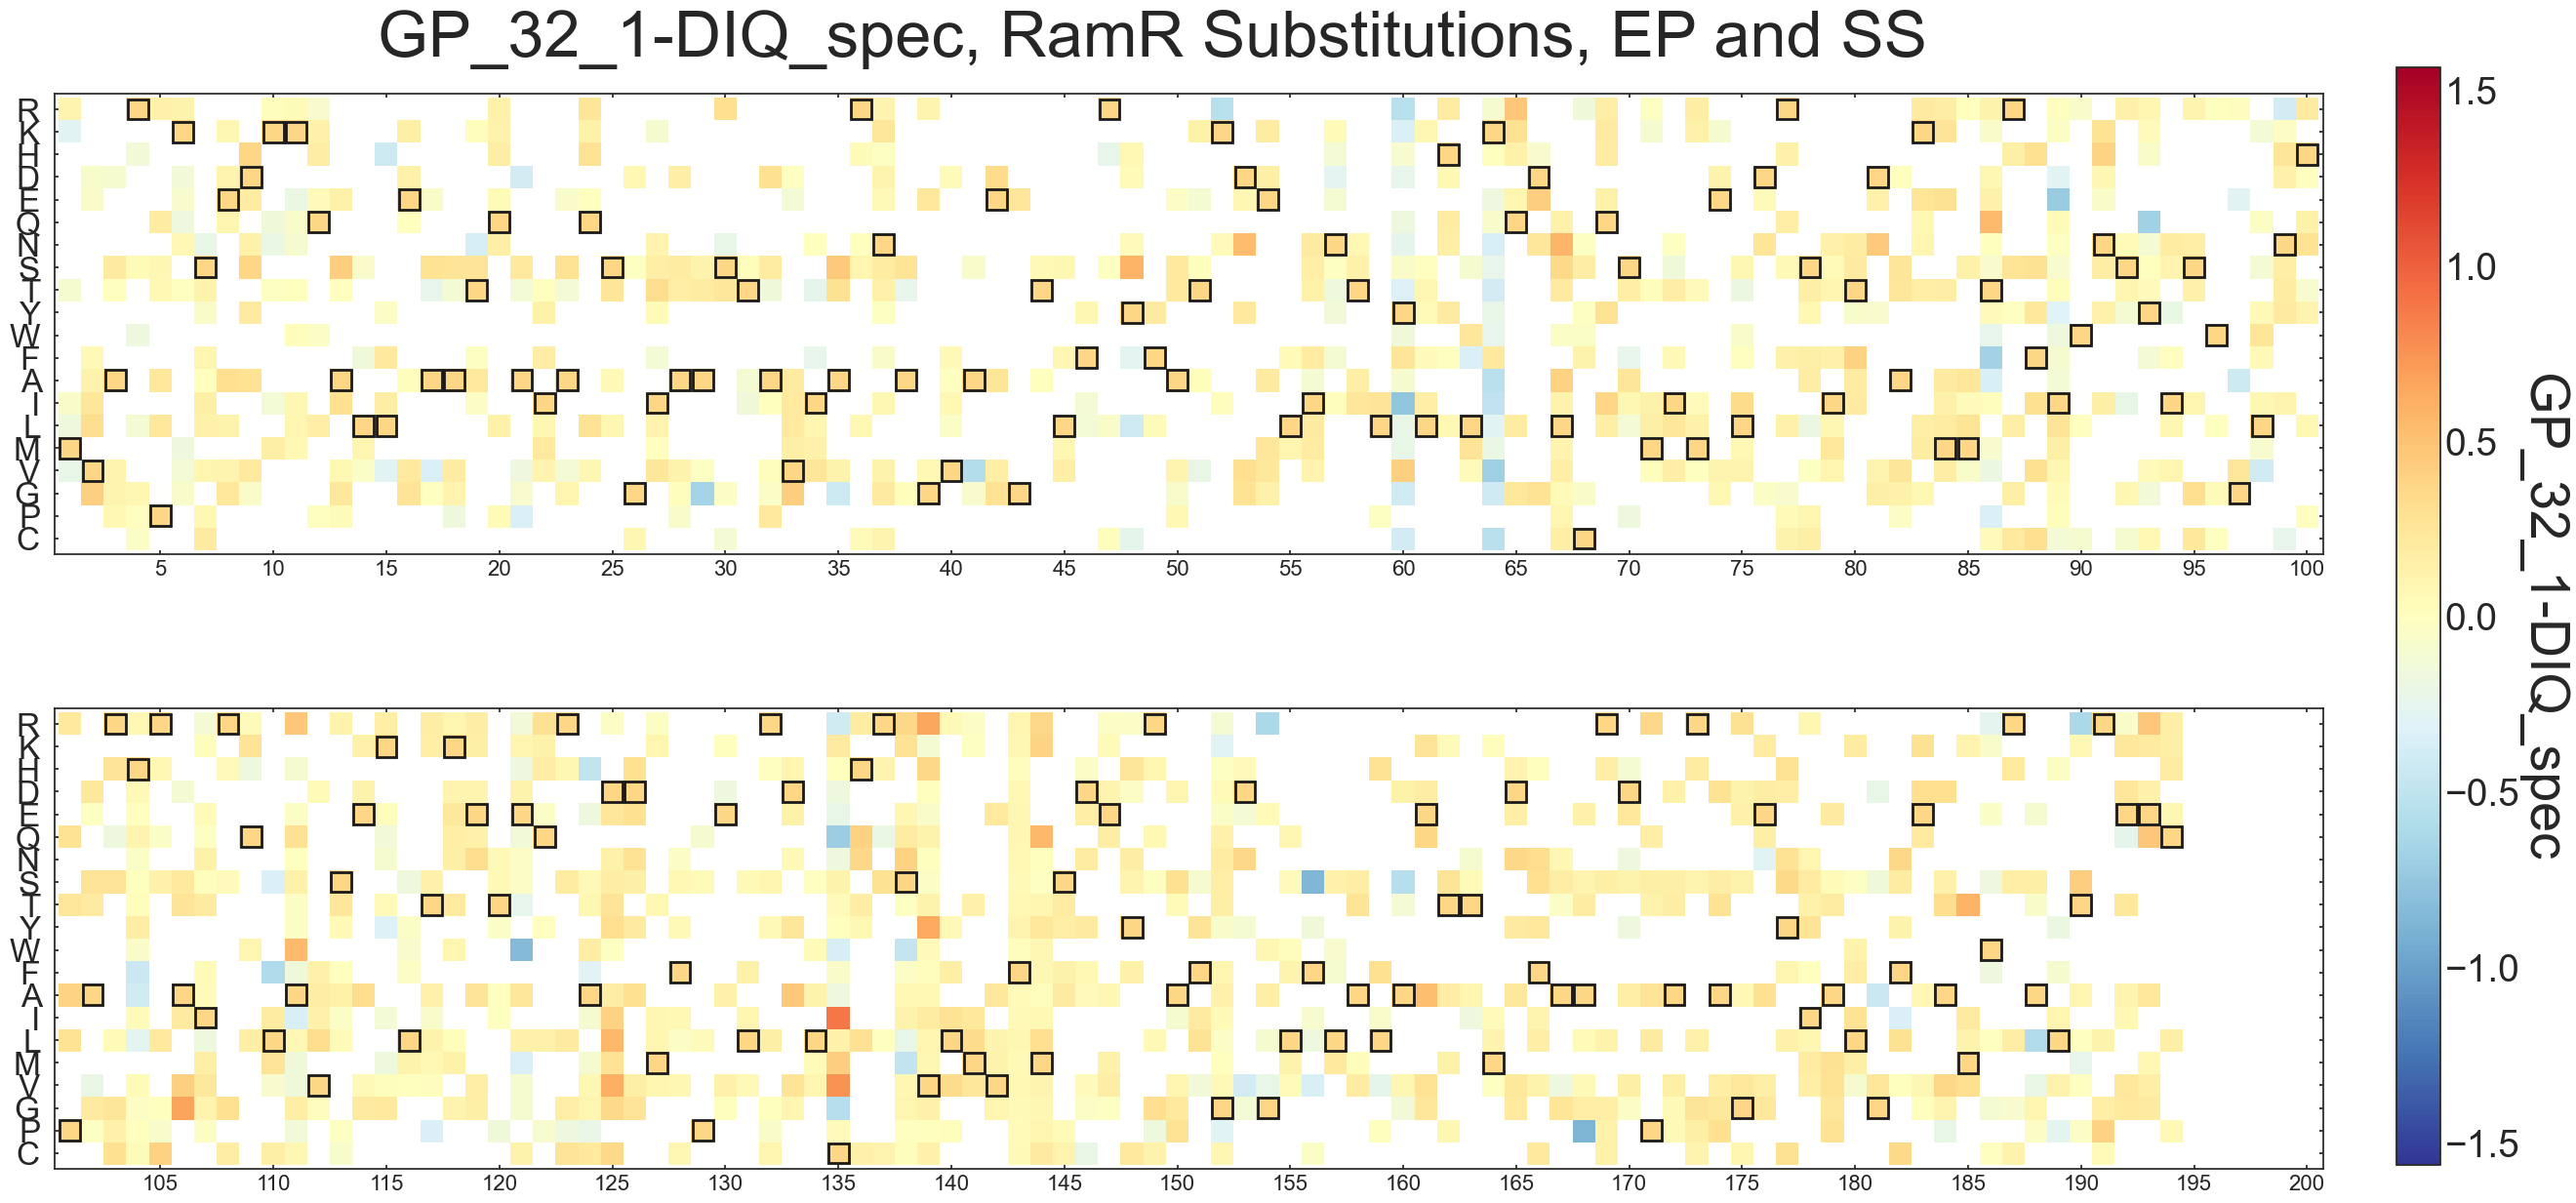

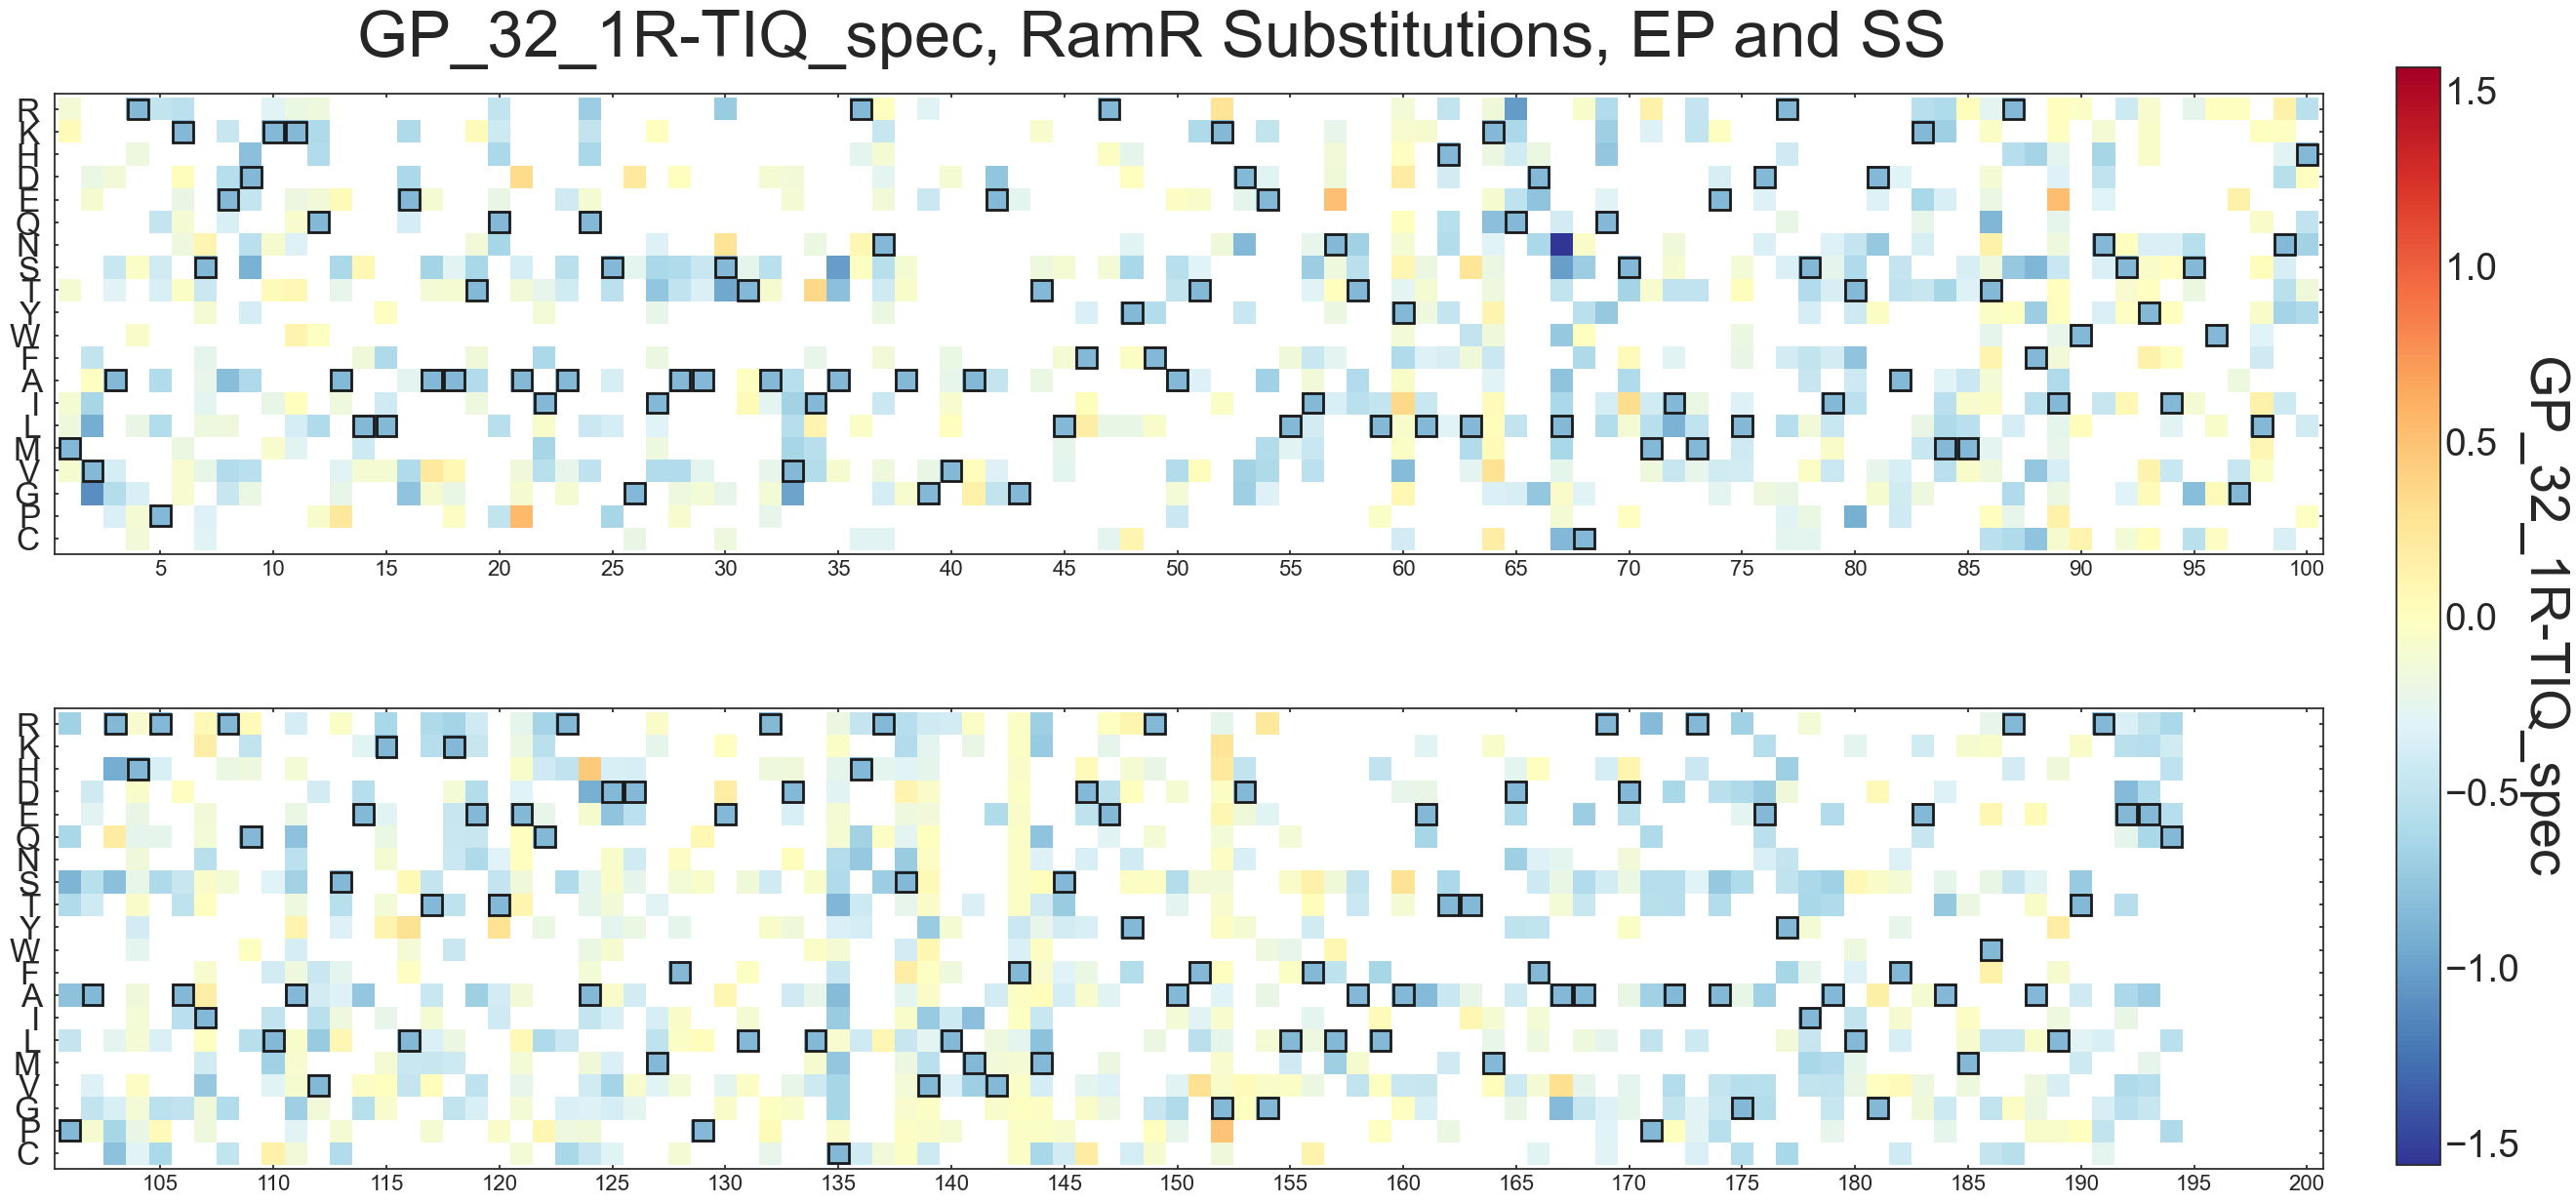

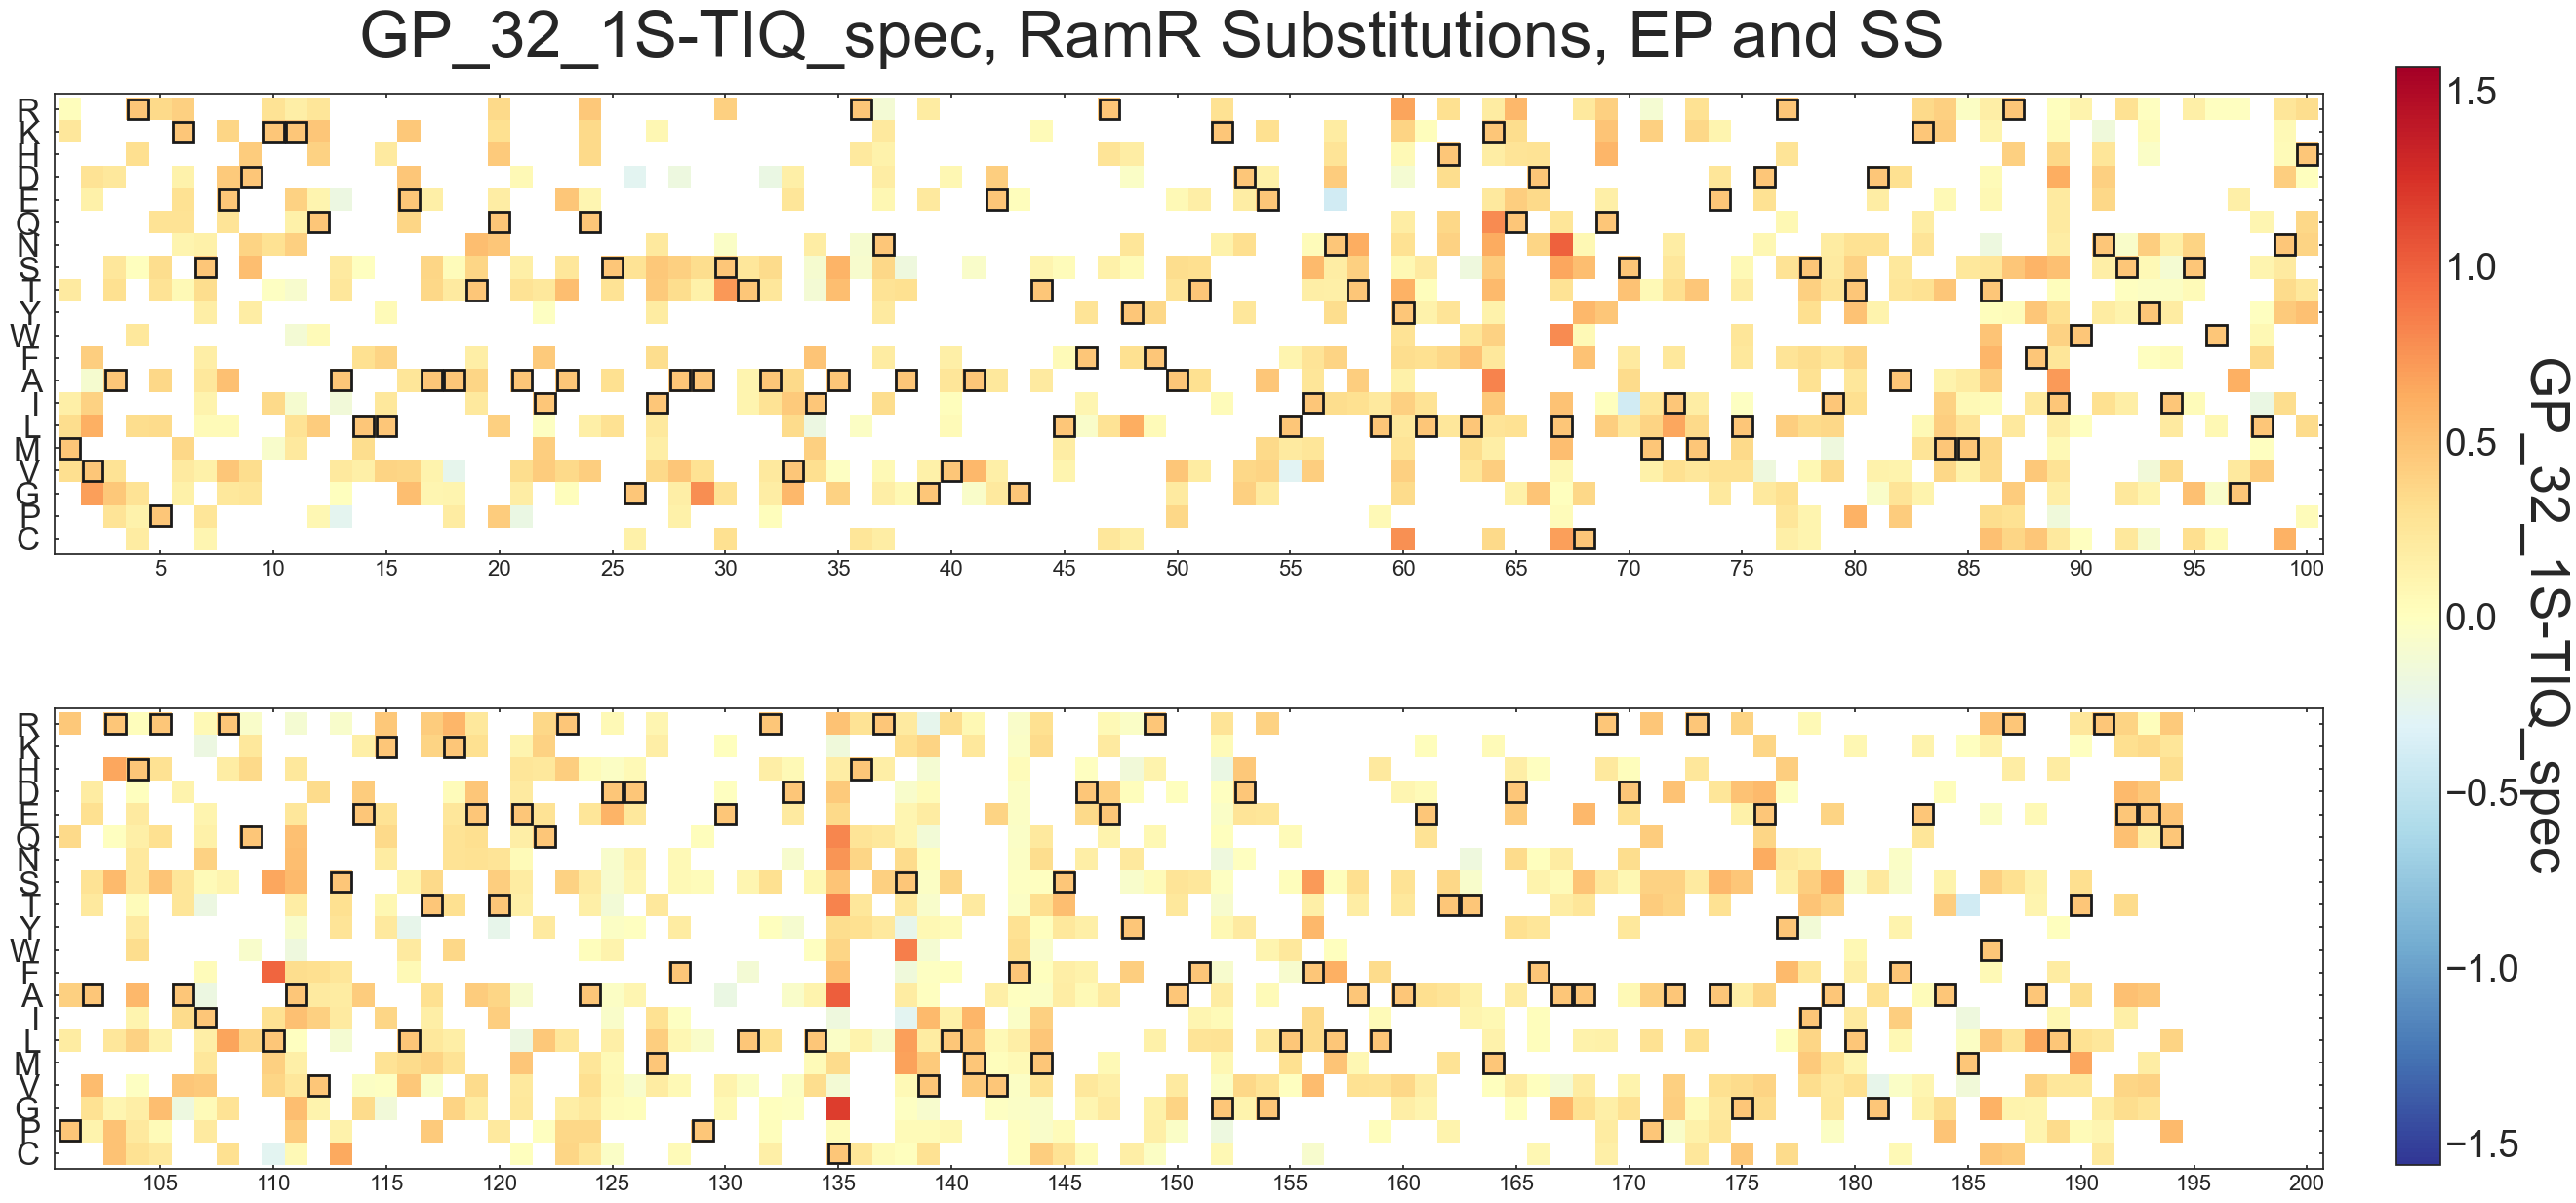

In [105]:
plt.rcParams["figure.figsize"] = [30,15]

for k in ['merged']:
    for lig in ligand_list:
        plot_param = f'GP_32_{lig}_spec'

        fig, axs = plt.subplots(2, 1)
        param_label = plot_param
        fig.suptitle(f'{plot_param}, RamR Substitutions, EP and SS', size=48, y=0.92)

        plot_arr = single_specificity_dict[k][lig]

        cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

        cmap = copy.copy(plot_param_cmap)
        #cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
        cmap.set_under(color='white')
        cmap.set_bad(color='white')

        axis_cut_point = 101

        plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

        for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
            #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
            im = ax.imshow(arr.transpose(), norm=colors.Normalize(vmin=vmin_plot_param, vmax=vmax_plot_param), cmap=cmap);
            #ax.set_axis_off();
            ax.grid(visible=False);
            if ax is axs[0]:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            else:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            ax.set_yticks([i for i in range(len(amino_codes))]);
            ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
            ax.set_yticklabels(ylabels) #, size=16);
            #ax.set_ylim(-0.5, 7.5);
            ax.tick_params(length=3);
            xlim = ax.get_xlim()
            ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
            ylim = ax.get_ylim()
            ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

            #for i, c in enumerate(arr):
            #    x_pos = i + 1
            #    for y_pos in np.where(c==10**missing_fill_value)[0]:
            #        draw_x_pos((x_pos, y_pos), ax)

        fig.colorbar(im, cax=cb_ax);

        # outline and draw X to mark wild-type 
        for i, c in enumerate(wild_type_aminos):
            y_pos = np.where(amino_codes==c)[0][0]
            if i < axis_cut_point - 1:
                x_pos = i + 1
                ax = axs[0]
            else:
                x_pos = i - axis_cut_point + 2
                ax = axs[1]
            outline_pos((x_pos, y_pos), ax)
            #draw_x_pos((x_pos, y_pos), ax)

        cb_ax.tick_params(axis='y', labelsize=28)
        cb_ax.set_ylabel(param_label, size=40, rotation=270, labelpad=35)

        axs[1].set_xlim(axs[0].get_xlim())

        os.chdir(notebook_directory)
        #fig.savefig(f"{plot_param} heatmap.EP and SS.svg", dpi=None, bbox_inches="tight")

## Dynamic range for each ligand

In [106]:
# Make array for heat-map plot of plot_param for each substitution, and for each ligand
missing_fill_value = -5
err_cutoff = 0.7

k = 'merged'
plot_param_dict = {}
for lig in ligand_list:
    plot_param = f'GP_log_g500_g0_ratio_{lig}'

    plot_param_arr = []
    for i, c1 in enumerate(wild_type_aminos):
        pos = i+1
        log_g_ratio_sub_arr = []
        for c2 in amino_codes:
            mut = f'{c1}{pos}{c2}'
            
            df_ep = single_mutations_frame_dict['EP']
            df_ep = df_ep[df_ep[f'{plot_param}_err']<err_cutoff]
            df_ep = df_ep[df_ep.mutation==mut]

            df_ss = single_mutations_frame_dict['SS']
            df_ss = df_ss[df_ss[f'{plot_param}_err']<err_cutoff]
            df_ss = df_ss[df_ss.mutation==mut]
        
        
            if (len(df_ep)==0) and (len(df_ss)==0):
                if c1 == c2:
                    param_value = wild_type_params_dict['EP'][f'log_g500_g0_ratio_{lig}'][0]
                else:
                    param_value = missing_fill_value

            elif (len(df_ep)==0):
                param_value = df_ss.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]
            elif (len(df_ss)==0):
                param_value = df_ep.sort_values(by='total_counts', ascending=False).iloc[0][plot_param]
            else:
                param_value = [df.sort_values(by='total_counts', ascending=False).iloc[0][plot_param] for df in [df_ep, df_ss]]
                param_value_err = [df.sort_values(by='total_counts', ascending=False).iloc[0][f'{plot_param}_err'] for df in [df_ep, df_ss]]

                param_value_err = np.array(param_value_err)
                param_value = np.average(param_value, weights=1/param_value_err**2)

            log_g_ratio_sub_arr.append(param_value)
        plot_param_arr.append(log_g_ratio_sub_arr)
    plot_param_arr = np.array(plot_param_arr)
    print(plot_param_arr.shape)
    plot_param_dict[lig] = plot_param_arr
single_dynamic_range_dict[k] = plot_param_dict

(194, 20)
(194, 20)
(194, 20)


In [107]:
min_max_list = []
for k in single_mutations_frame_dict:
    for lig in ligand_list:
        plot_param = f'GP_log_g500_g0_ratio_{lig}'
        df = single_mutations_frame_dict[k]
        df = df[df[f'{plot_param}_err']<err_cutoff]
        
        min_max_list.append(df[plot_param].min())
        min_max_list.append(df[plot_param].max())
        print(single_mutations_frame_dict[k][plot_param].min(), single_mutations_frame_dict[k][plot_param].max())

-0.480890650711 3.75326564
-0.01454252142525 3.663551755
-0.0278628107745 3.839958325
-0.132120472273 3.6928835045
0.1229390514105 3.57932213
0.0149131017604999 3.53235469


In [108]:
plot_param_min = min(min_max_list)
plot_param_max = max(min_max_list)


vmin_plot_param = plot_param_min
vmax_plot_param = plot_param_max

vmin_plot_param, vmax_plot_param

(-0.480890650711, 3.839958325)

In [109]:
plot_param_cmap = colormaps['plasma']

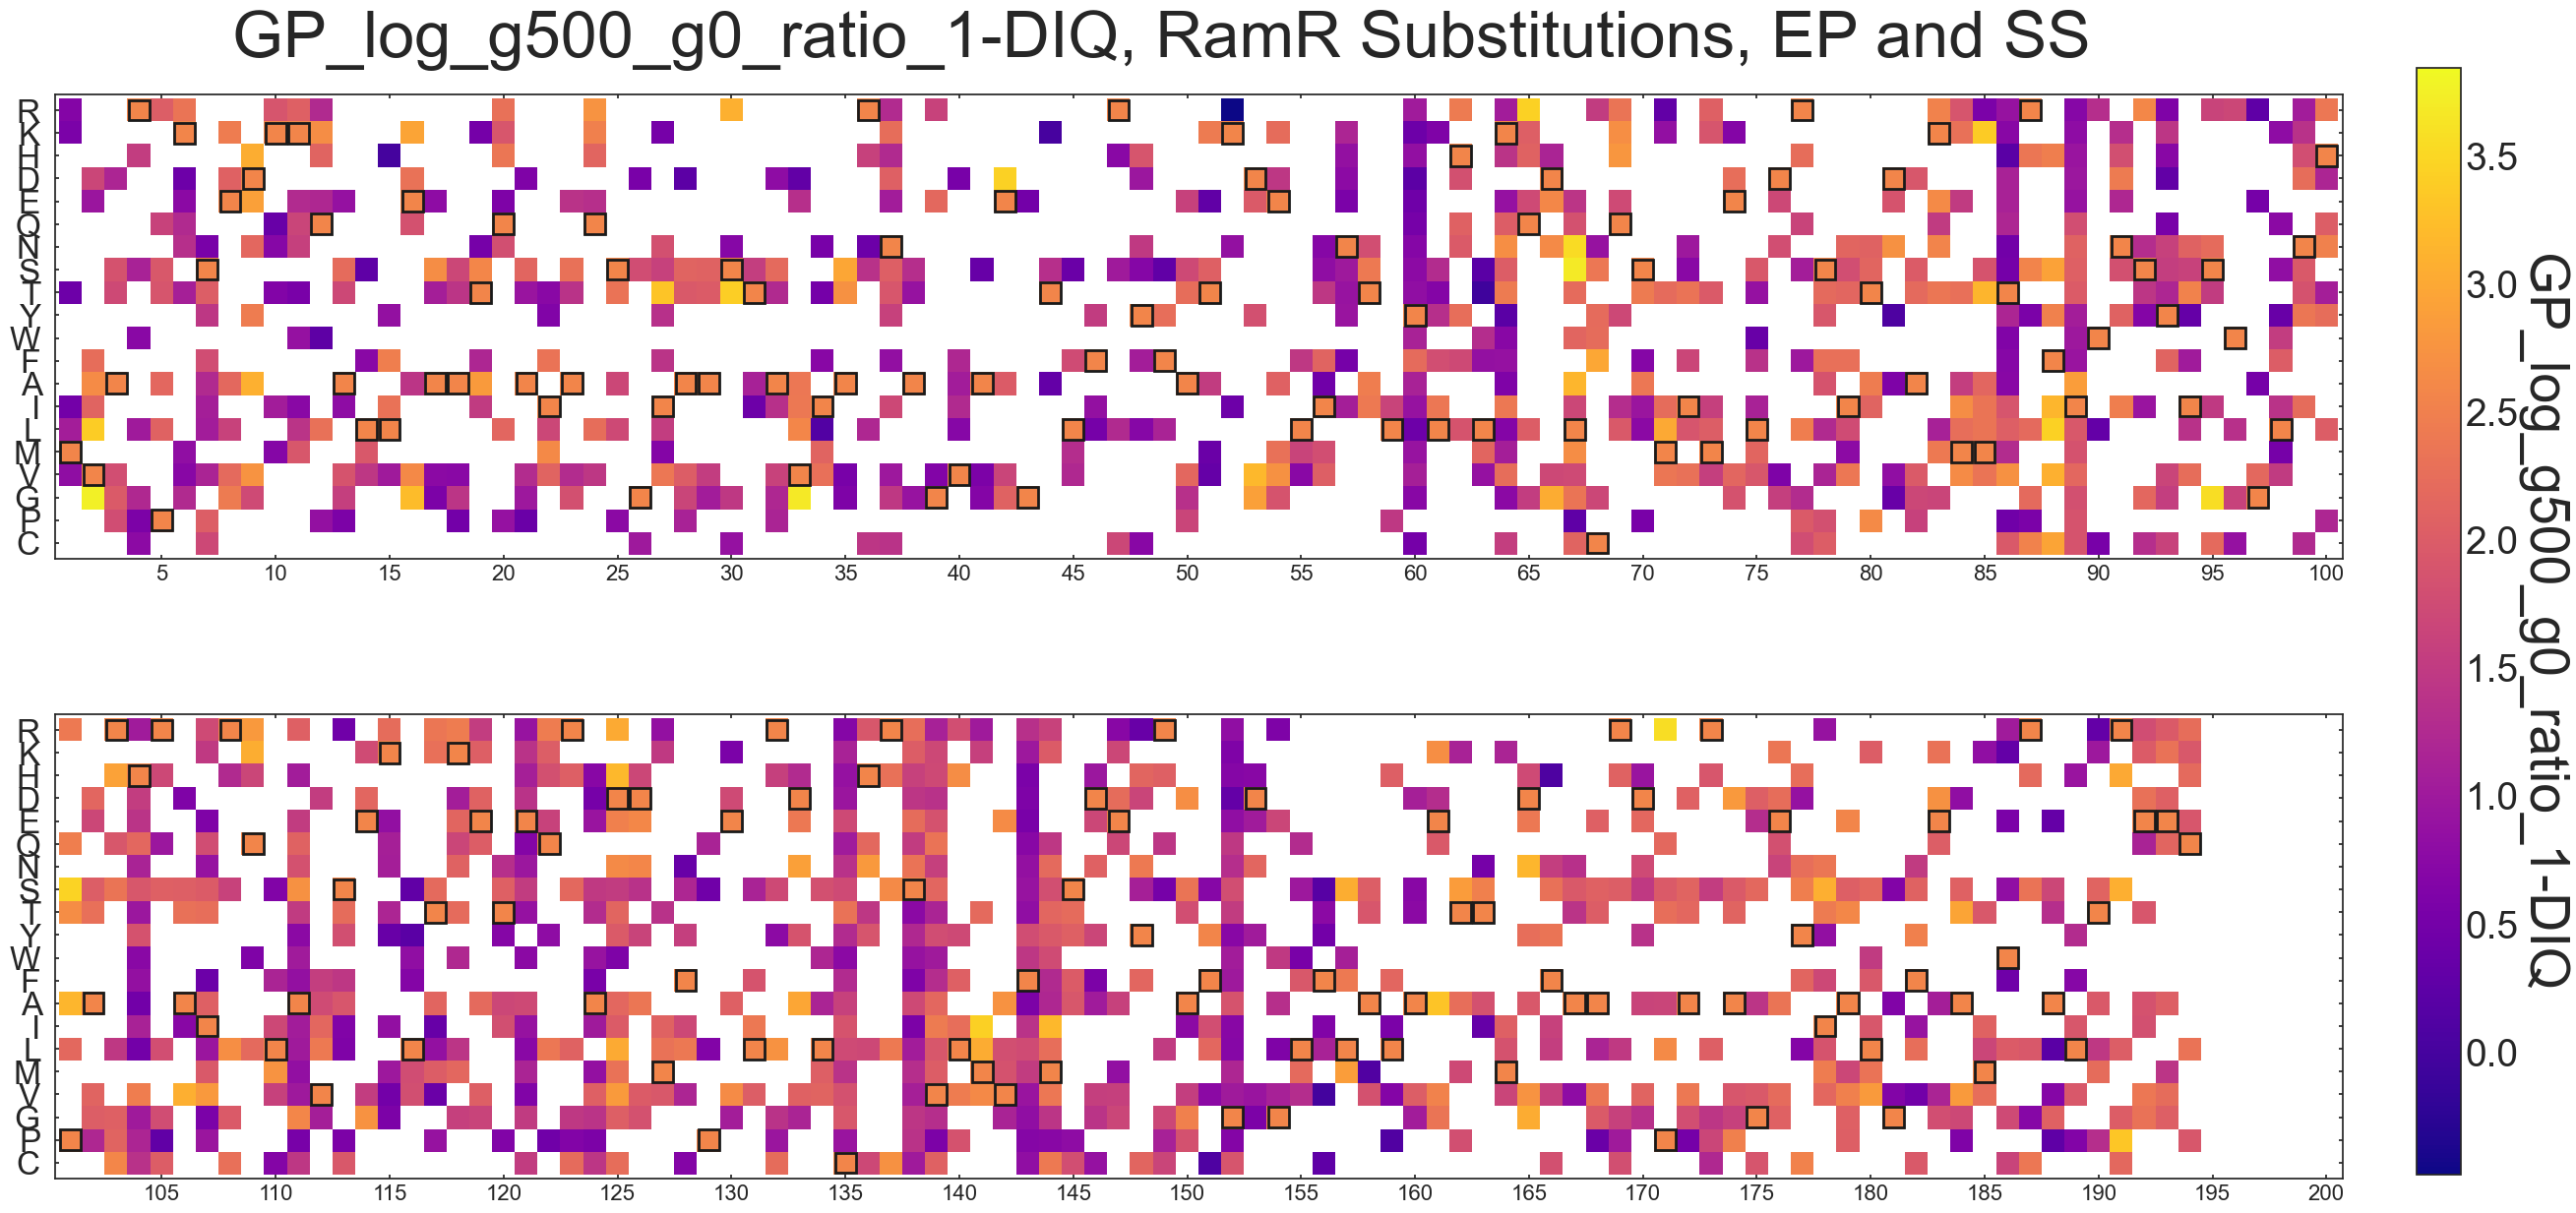

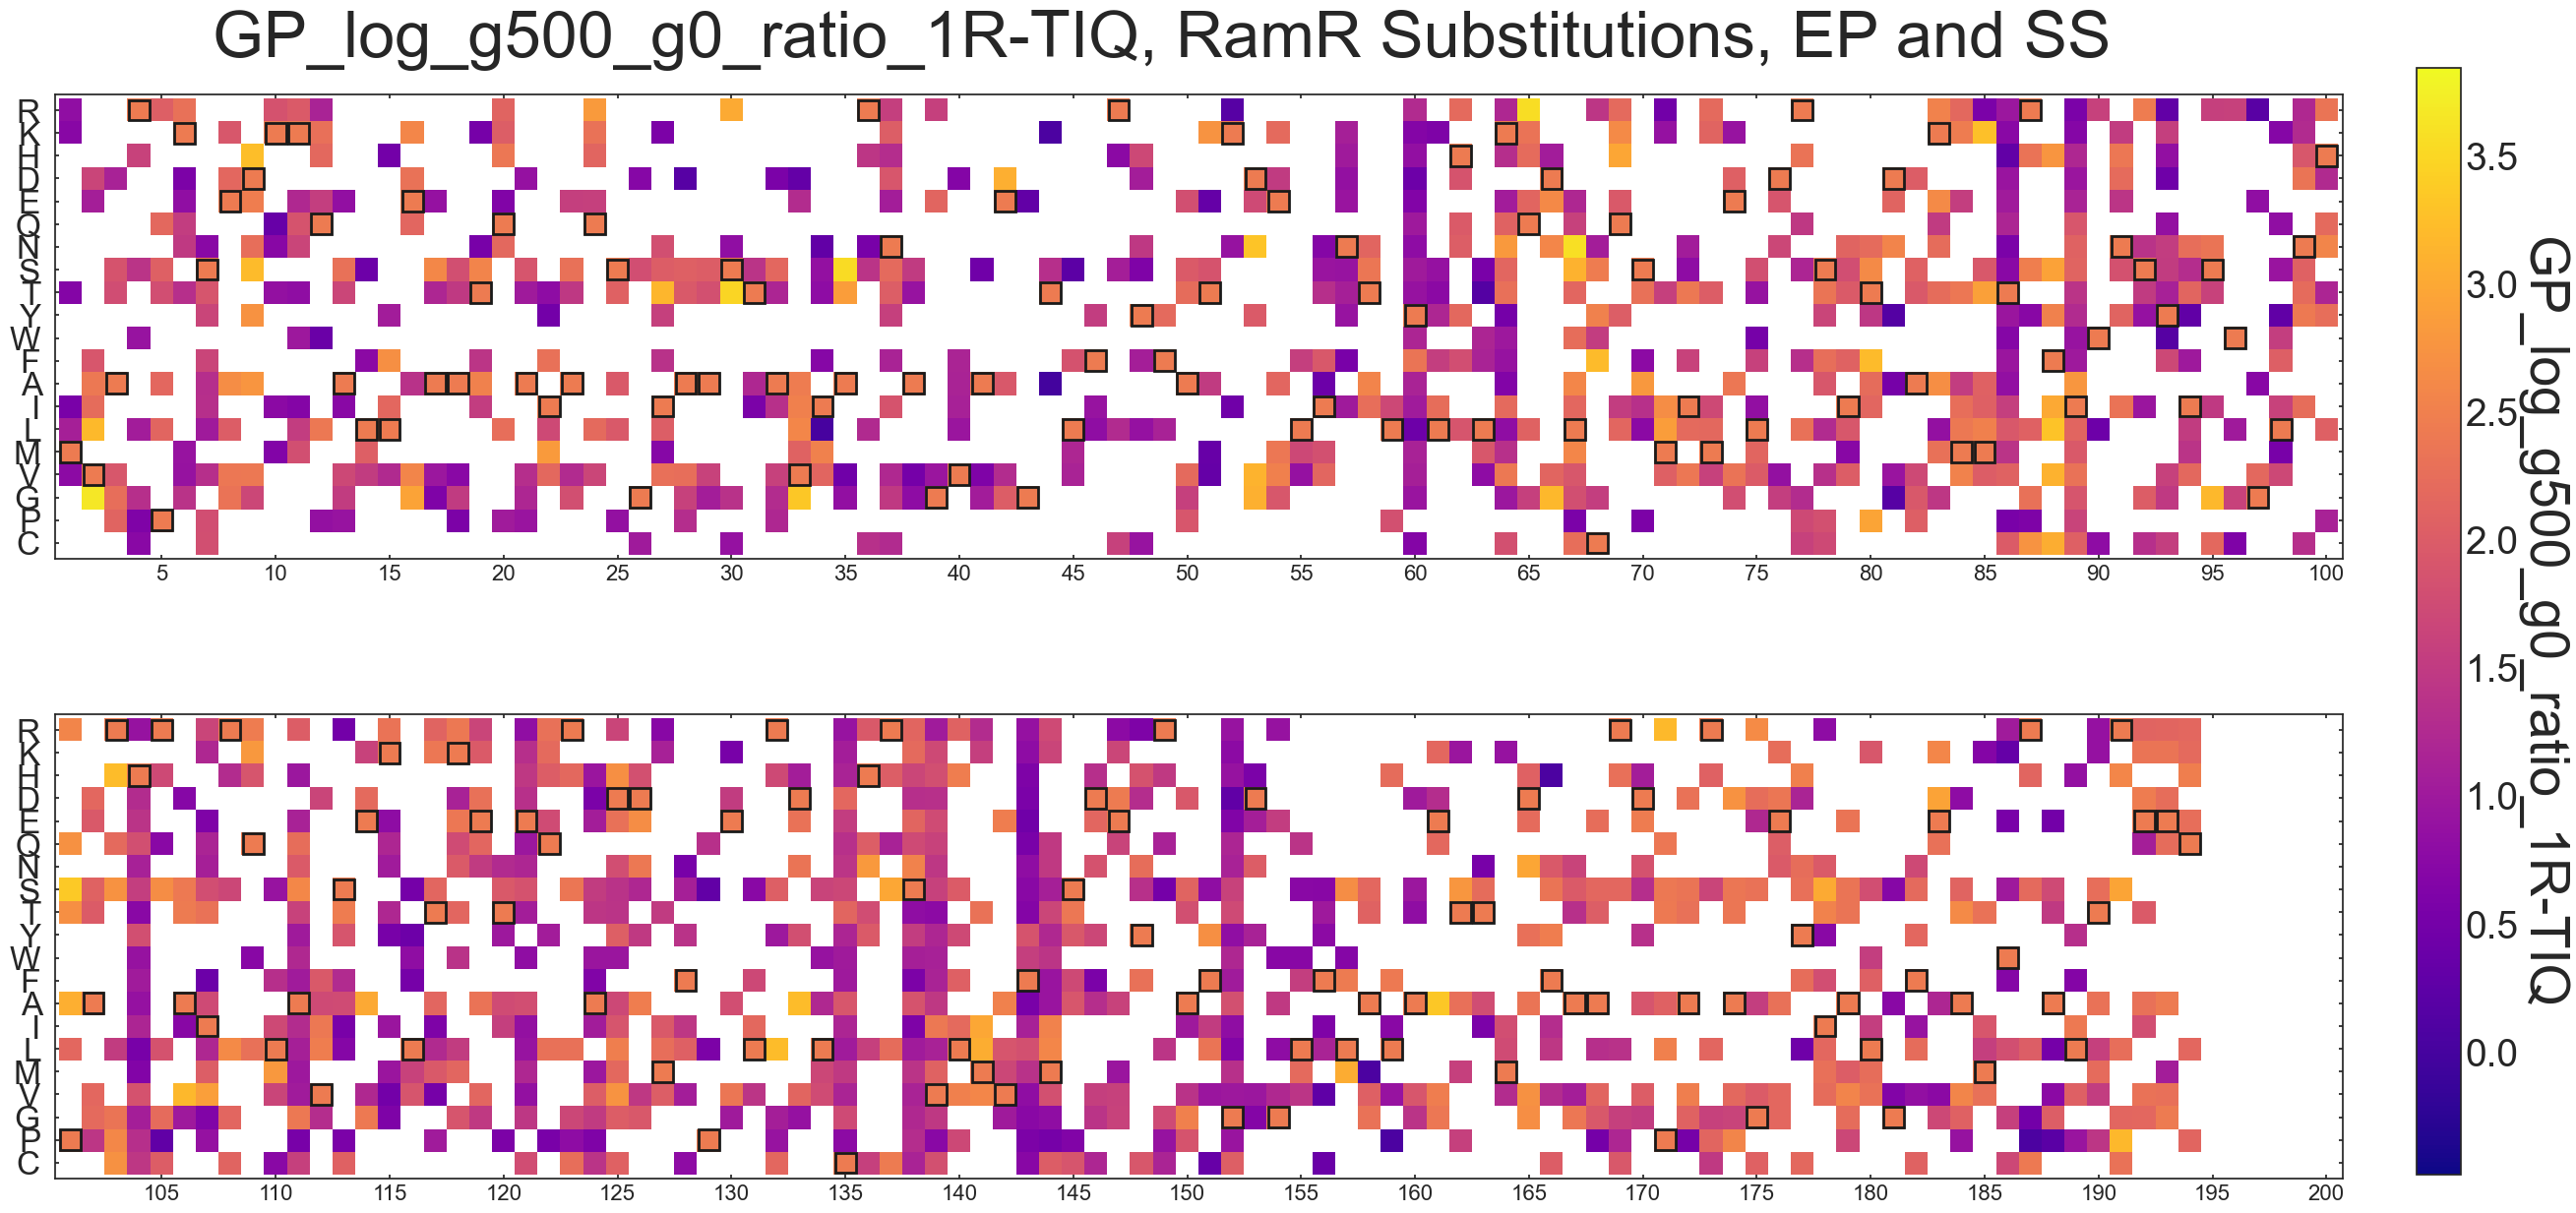

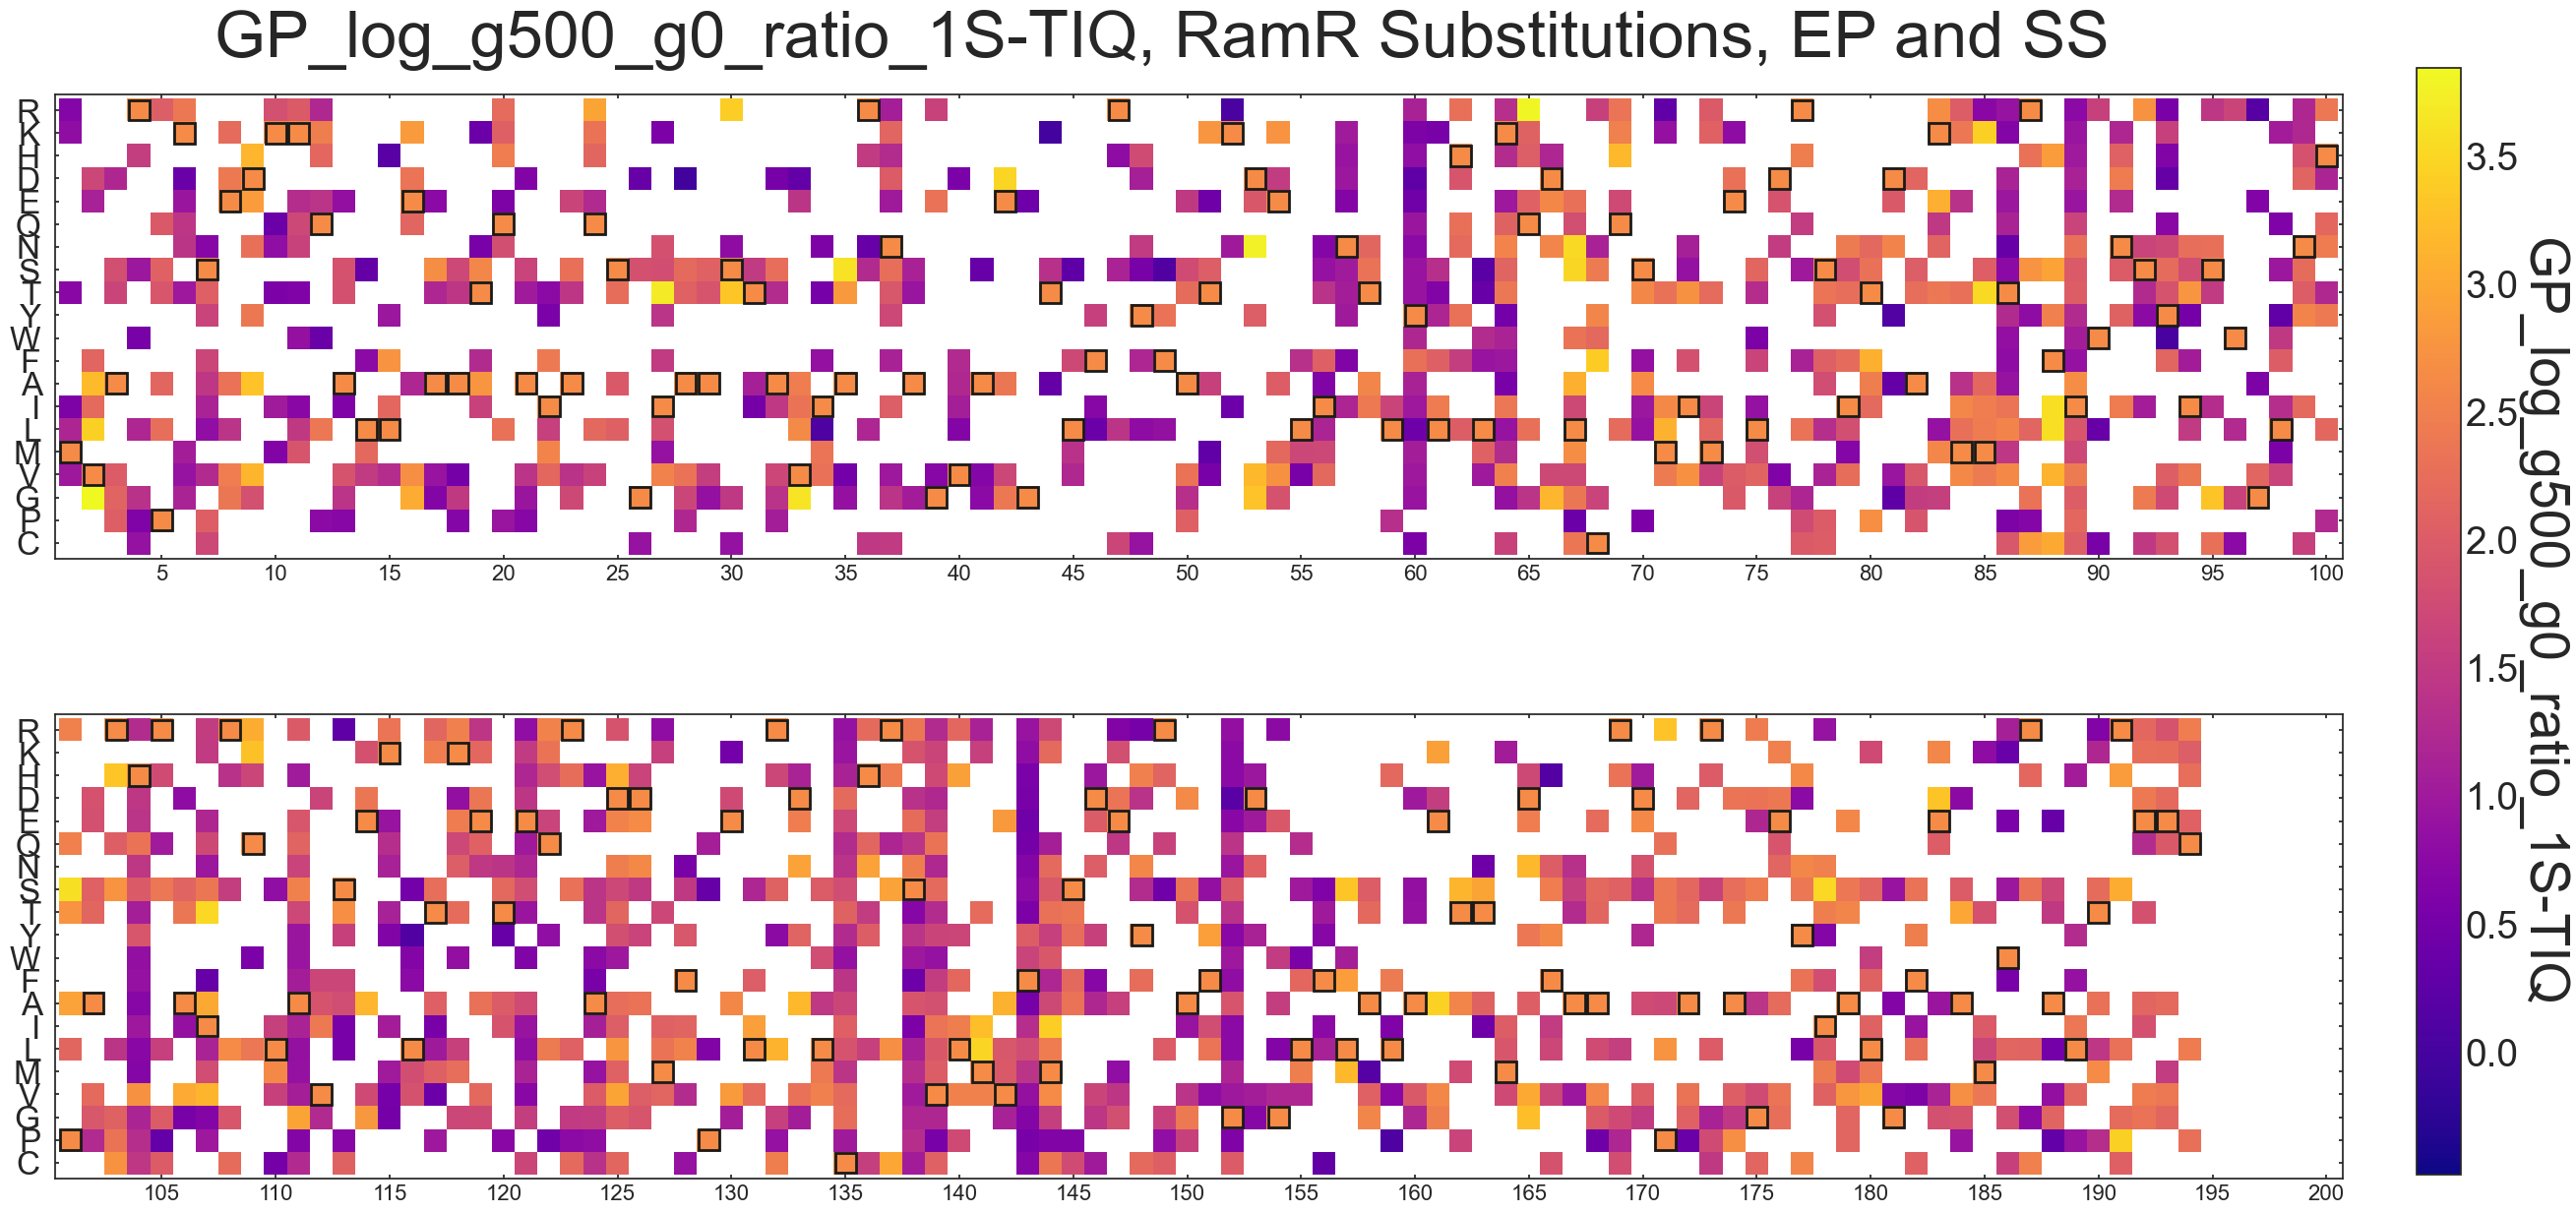

In [110]:
plt.rcParams["figure.figsize"] = [30,15]

for k in ['merged']:
    for lig in ligand_list:
        plot_param = f'GP_log_g500_g0_ratio_{lig}'

        fig, axs = plt.subplots(2, 1)
        param_label = plot_param
        fig.suptitle(f'{plot_param}, RamR Substitutions, EP and SS', size=48, y=0.92)

        plot_arr = single_dynamic_range_dict[k][lig]

        cb_ax = fig.add_axes([0.925, 0.13, 0.015, 0.75])

        cmap = copy.copy(plot_param_cmap)
        #cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
        cmap.set_under(color='white')
        cmap.set_bad(color='white')

        axis_cut_point = 101

        plot_arr = [ plot_arr[:axis_cut_point-1], plot_arr[axis_cut_point-1:] ]

        for ax, arr, p_0 in zip(axs, plot_arr, [1, axis_cut_point]):
            #im = ax.matshow(arr.transpose(), norm=colors.LogNorm(), cmap="plasma");
            im = ax.imshow(arr.transpose(), norm=colors.Normalize(vmin=vmin_plot_param, vmax=vmax_plot_param), cmap=cmap);
            #ax.set_axis_off();
            ax.grid(visible=False);
            if ax is axs[0]:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            else:
                ax.set_xticks([i-1 for i in range(5, 105, 5)]);
                ax.set_xticklabels([i+p_0-1 for i in range(5, 105, 5)], size=16);
            ax.set_yticks([i for i in range(len(amino_codes))]);
            ylabels = [ r + " " if r!='d' else 'del ' for r in amino_codes ]
            ax.set_yticklabels(ylabels) #, size=16);
            #ax.set_ylim(-0.5, 7.5);
            ax.tick_params(length=3);
            xlim = ax.get_xlim()
            ax.set_xlim(xlim[0]-0.2, xlim[1]+0.2)
            ylim = ax.get_ylim()
            ax.set_ylim(ylim[0]+0.2, ylim[1]-0.2)

            #for i, c in enumerate(arr):
            #    x_pos = i + 1
            #    for y_pos in np.where(c==10**missing_fill_value)[0]:
            #        draw_x_pos((x_pos, y_pos), ax)

        fig.colorbar(im, cax=cb_ax);

        # outline and draw X to mark wild-type 
        for i, c in enumerate(wild_type_aminos):
            y_pos = np.where(amino_codes==c)[0][0]
            if i < axis_cut_point - 1:
                x_pos = i + 1
                ax = axs[0]
            else:
                x_pos = i - axis_cut_point + 2
                ax = axs[1]
            outline_pos((x_pos, y_pos), ax)
            #draw_x_pos((x_pos, y_pos), ax)

        cb_ax.tick_params(axis='y', labelsize=28)
        cb_ax.set_ylabel(param_label, size=40, rotation=270, labelpad=35)

        axs[1].set_xlim(axs[0].get_xlim())

        os.chdir(notebook_directory)
        #fig.savefig(f"Dynamic range {lig} heatmap.EP and SS.svg", dpi=None, bbox_inches="tight")